#### Summary:
This notebook contains code to rigorously and repeatably quantify donor level covars with large influence on RNA and ATAC profiles (to control for in downstream analyses). In short, this implements a sample-level pseudobulk method to get PC embeddings for each sample and then perform cor.test (or anova) against all covariates. We don't include outliers in these analyses and also run multiple test correction for all tests per PC. This code requires the following inputs:
- Per-cell type RNA sum of counts per donor matrix (genes x samples)
- Per-cell type ATAC sum of counts per donor matrix (peaks x samples)
- Per-cell type list of expressed genes to include when calculating PCA (Here we use pseudobulk TPM>=1)
- Per-cell type list of accessible peaks (Here we use all peaks called by MACS2, formatted as bed files)

In [1]:
suppressMessages(library(hdf5r))
suppressMessages(library(Seurat))
suppressMessages(library(DESeq2))
suppressMessages(library(enrichR))
suppressMessages(library(fgsea))

suppressMessages(library(dplyr)) 
suppressMessages(library(Matrix)) 
suppressMessages(library(data.table))
suppressMessages(library(future)) 
suppressMessages(library(stringr))
suppressMessages(library(stringi))
suppressMessages(library(parallel))
suppressMessages(library(readr))

suppressMessages(library(ggplot2)) 
suppressMessages(library(ggpubr)) 
suppressMessages(library(ggrepel))
suppressMessages(library(RColorBrewer))
suppressMessages(library(shadowtext))
suppressMessages(library(forcats))
suppressMessages(library(qvalue))

In [2]:
samples <- c('R207','R217','R218','R221','R223','R226','R228',
             'R234','R237','R238','R246','R247','R275','R284',
             'R290','R292','R316','R317','R319','R325','R326',
             'R327','R332','R353','R354','R362','R363','R364')

In [5]:
celltypes <- c('beta','alpha','delta','gamma','acinar','ductal','endothelial','immune','stellate')

In [194]:
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B',
            '#F5DE6C', '#752BBA', '#DF1681', '#FDBB84')
names(colors) <- celltypes

In [3]:
set.seed(10)

In [4]:
options(scipen=999)

In [5]:
#gene coord reference file
ref_df = read.table('non-diabetic-islet-multiomics/references/gene_coords.gencodev32.hg38.bed', sep='\t', header=FALSE) #read in gene coords ref
dim(ref_df)

# pull out list of autosomal genes
auto_genes <- subset(ref_df, V1 != 'chrX' & V1 != 'chrY')$V4
length(auto_genes)

[1] 36549     6

[1] 35292

In [ ]:
### CHANGE FILE PATHS
#inputs
rna_mt_dir <- '/path/to/rna/counts/matrices'
atac_mtx_dir <- '/path/to/atac/counts/matrices'
meta_fp <- '/path/to/per/donor/metadata/df'

genes_dir <- '/path/to/expressed/genes/lists'
peaks_dir <- '/path/to/accessible/peak/beds'

#outputs
overall_outdir <- '/path/to/store/outputs'
rna_dir <- file.path(overall_outdir,'RNA_pseudobulk')
atac_dir <- file.path(overall_outdir,'ATAC_pseudobulk')

# Read in donor pseudobulks (sum of counts per feature for all bcs from the same donor)

## RNA sum of counts

In [7]:
# Read in sum matrices by cell type
rna_tables <- list()
for (celltype in celltypes){
    fp <- file.path(rna_mt_dir, sprintf('%s_sample_gex_total_counts.txt', celltype))
    df <- read.table(fp, sep='\t', header=TRUE)
    rna_tables[[celltype]] <- df
}

## ATAC sum of counts

In [9]:
# Read in sum matrices by cell type
atac_tables <- list()
for (celltype in celltypes){
    fp <- file.path(atac_mtx_dir,sprintf('%s_sample_peak_total_counts.txt',celltype))
    df <- read.table(fp, sep='\t', header=TRUE)
    atac_tables[[celltype]] <- df
}

# Read in donor level metadata

In [6]:
#read in donor metadata
meta <- as.data.frame(fread(meta_fp, sep='\t', header=TRUE))

#change colnames to be more R friendly
init_names <- colnames(meta)
colnames(meta) <- tolower(stri_replace_all_regex(gsub(r"{\s*\([^\)]+\)}","",colnames(meta)),
                                                 pattern=c(' ', '%', ',', ':','-','/'), 
                                                 replacement=c('_','pct','','','_','_div_'), vectorize=FALSE))
meta_names <- init_names
names(meta_names) <- colnames(meta)

#make sure only includes samples in final object
meta2 <- meta[meta$record_id %in% samples,]

In [7]:
#remove unnecessary columns from meta
rm_cols <- c('rrid','known_medical_condition', 'was_the_tissue_purified?', 
             'excellent_pct','good_pct','fair_pct','poor_pct', 
             'ieq_per_cryopreservation_tube','number_of_cryopreserved_tubes_remaining',
             'ieq_per_cryopreservation_tube.1','number_of_snap_frozen_tubes_remaining',
             'is_an_embedded_biopsy_available_for_this_donor?', 'are_embedded_islets_available_for_this_donor?')
meta_cut <- meta2[,!colnames(meta2) %in% rm_cols]

In [8]:
meta_fin <- meta_cut[,-1]
row.names(meta_fin) <- meta_cut$record_id
meta_fin$library <- row.names(meta_fin)
head(meta_fin)

age sex    donation_type      height weight body_mass_index
R207 50  Female NDD - Neurological 1.75   68.0   22.2           
R217 71  Female NDD - Neurological 1.52   82.1   35.5           
R218 73  Female NDD - Neurological 1.60   72.6   28.4           
R221 44  Male   NDD - Neurological 1.62   80.0   30.5           
R223 54  Male   NDD - Neurological 1.80   87.5   27.0           
R226 30  Female NDD - Neurological 1.57   79.6   32.3           
     glycated_hemoglobin hla_a hla_b hla_bw ⋯ mean_16.7_mm_pct_content
R207  NA                                    ⋯ 0.31                    
R217 6.3                                    ⋯ 1.49                    
R218 5.9                                    ⋯ 1.50                    
R221 5.3                                    ⋯ 1.83                    
R223 5.8                                    ⋯ 4.37                    
R226 4.9                                    ⋯ 1.59                    
     mean_16.7_mm_to_1_mm_stimulation_index
R207  7.39                                 
R217  3.14                                 
R218  5.44                                 
R221   Inf                                 
R223 10.41                                 
R226  5.65                                 
     mean_2.8_mm_div_16.7_mm_content_value mean_2.8_mm_value
R207 1885.0050                               511.67         
R217 1583.5220                             14694.00         
R218 2984.2173                              6004.00         
R221  727.7933                              4770.78         
R223  570.9687                              3358.54         
R226 1570.7317                              1837.39         
     mean_2.8_mm_pct_content mean_16.7_mm_value.1 mean_16.7_mm_pct_content.1
R207 0.03                     7211.67             0.40                      
R217 1.13                    20509.33             1.32                      
R218 0.21                    23749.67             0.84                      
R221 0.64                    13949.07             1.93                      
R223 0.58                    24109.85             4.27                      
R226 0.13                    12703.11             0.83                      
     mean_16.7_mm_to_2.8_mm_stimulation_index culture_time library
R207 15.85                                     70          R207   
R217  1.58                                     15          R217   
R218  5.04                                     70          R218   
R221  3.11                                    136          R221   
R223  7.89                                     64          R223   
R226  7.91                                     16          R226

In [9]:
#make sure no metadata values are Inf
meta_fin[sapply(meta_fin, is.infinite)] <- NA

# Generate PC Embeddings

## Perform PCA on donor-pseudobulks for each cell type -- RNA

In [149]:
generate_pc_embeds <- function(celltype, counts_tables, select_features, test_vars, norm_method,
                               assay, ntop=2000, nPCs=20, out_dir){
    mat <- counts_tables[[celltype]]
    
    # Normal DESeq protocol
    # Light prefiltering
    counts <- mat[rowSums(mat) >= 10,] #select for features with >= 10 counts across samples
    counts_fin <- counts[row.names(counts) %in% select_features,]

    # Make DESeq object with filler metadata and function
    my_design <- as.formula('~ age + sex + body_mass_index')
    dds  <- DESeqDataSetFromMatrix(round(counts_fin), colData = meta_fin, design = my_design)

    # Normalize based on input method
    if (norm_method == 'vst'){
        print('Using vst normalization!')
        rld <- vst(dds) 
    } else if (norm_method == 'rlog'){
        print('Using rlog normalization')
        rld <- rlog(dds) 
    }
    
    # Generate normal PCA plots for all variables
    plots <- list()
    for (var in test_vars){
        plots[[var]] <- plotPCA(rld, intgroup=var, ntop=500) + ggtitle(paste(celltype, var, sep=' cells: '))
    }

    # base plot dimensions off of # vars in list
    if(length(test_vars) < 3){
        plot_width <- 5 * length(plots)
        plot_height <- 5
        ncols <- length(plots)
        nrows <- 1
    } else {
        plot_width <- 20
        plot_height <- 5 * ceiling(length(plots)/3)
        ncols <- 3
        nrows <- ceiling(length(plots)/3)
    }
    options(repr.plot.width = plot_width, repr.plot.height= plot_height)
    print(ggarrange(plotlist = plots, nrow=nrows, ncol=ncols))
    
    # Run PCA for set # PCs and extract the embeddings for each sample
    # Adjusted version of DESeq PCA (source code: https://github.com/thelovelab/DESeq2/blob/devel/R/plots.R)
    # Uses stats::prcomp to perform PCA (https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/prcomp)
    # calculate the variance for each gene
    rv <- rowVars(assay(rld))

    # select the ntop genes by variance
    select <- order(rv, decreasing=TRUE)[seq_len(min(ntop, length(rv)))]

    # perform a PCA on the data in assay(x) for the selected genes
    pca <- prcomp(t(assay(rld)[select,]), rank=nPCs)
    
    # Calculate the contribution to the total variance for each component
    percentVar <- pca$sdev^2 / sum( pca$sdev^2 )

    # Save embeddings to a file!
    df <- rbind(pca$x, percentVar)
    out_fp <- file.path(out_dir, sprintf('%s_%s_sample_pseudobulk_PC_embeds.txt', celltype, assay))
    write.table(df, out_fp, sep='\t', quote=FALSE)   
}

In [15]:
plot_vars <- c('age','sex','donation_type','body_mass_index','glycated_hemoglobin',
               'cold_ischemia_time','collagenase_type','pancreas_weight','culture_time')

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



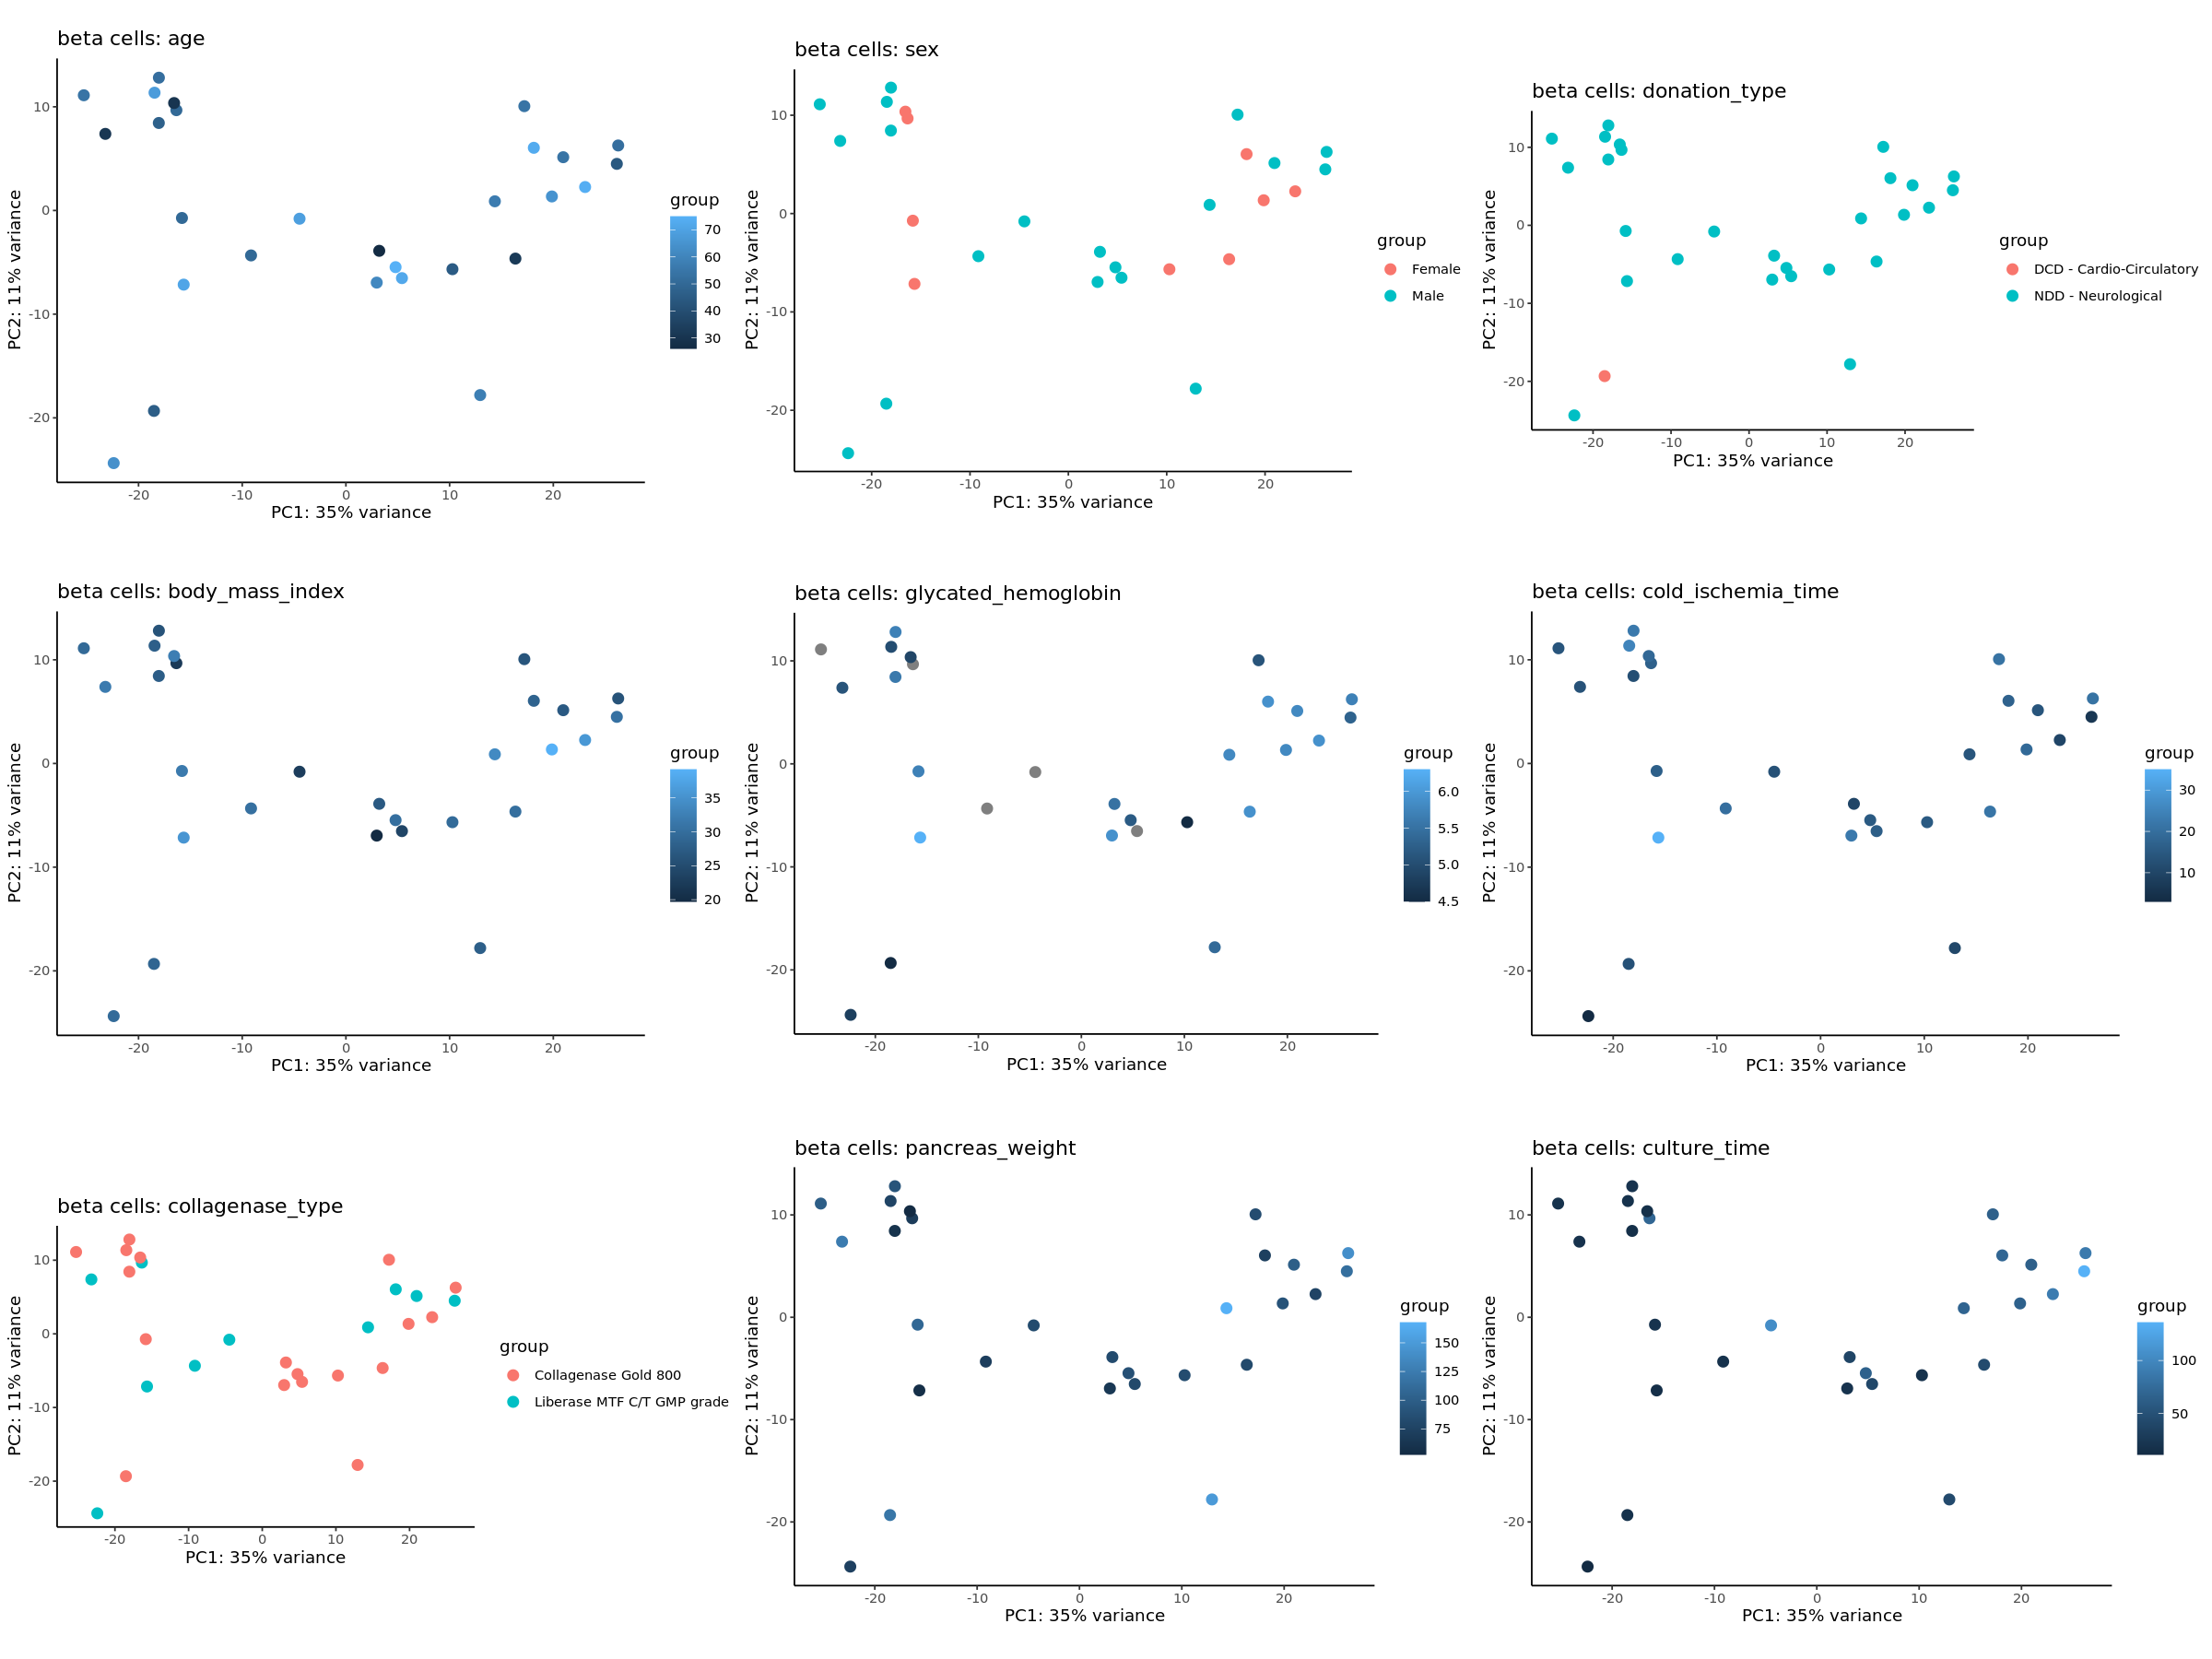

[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



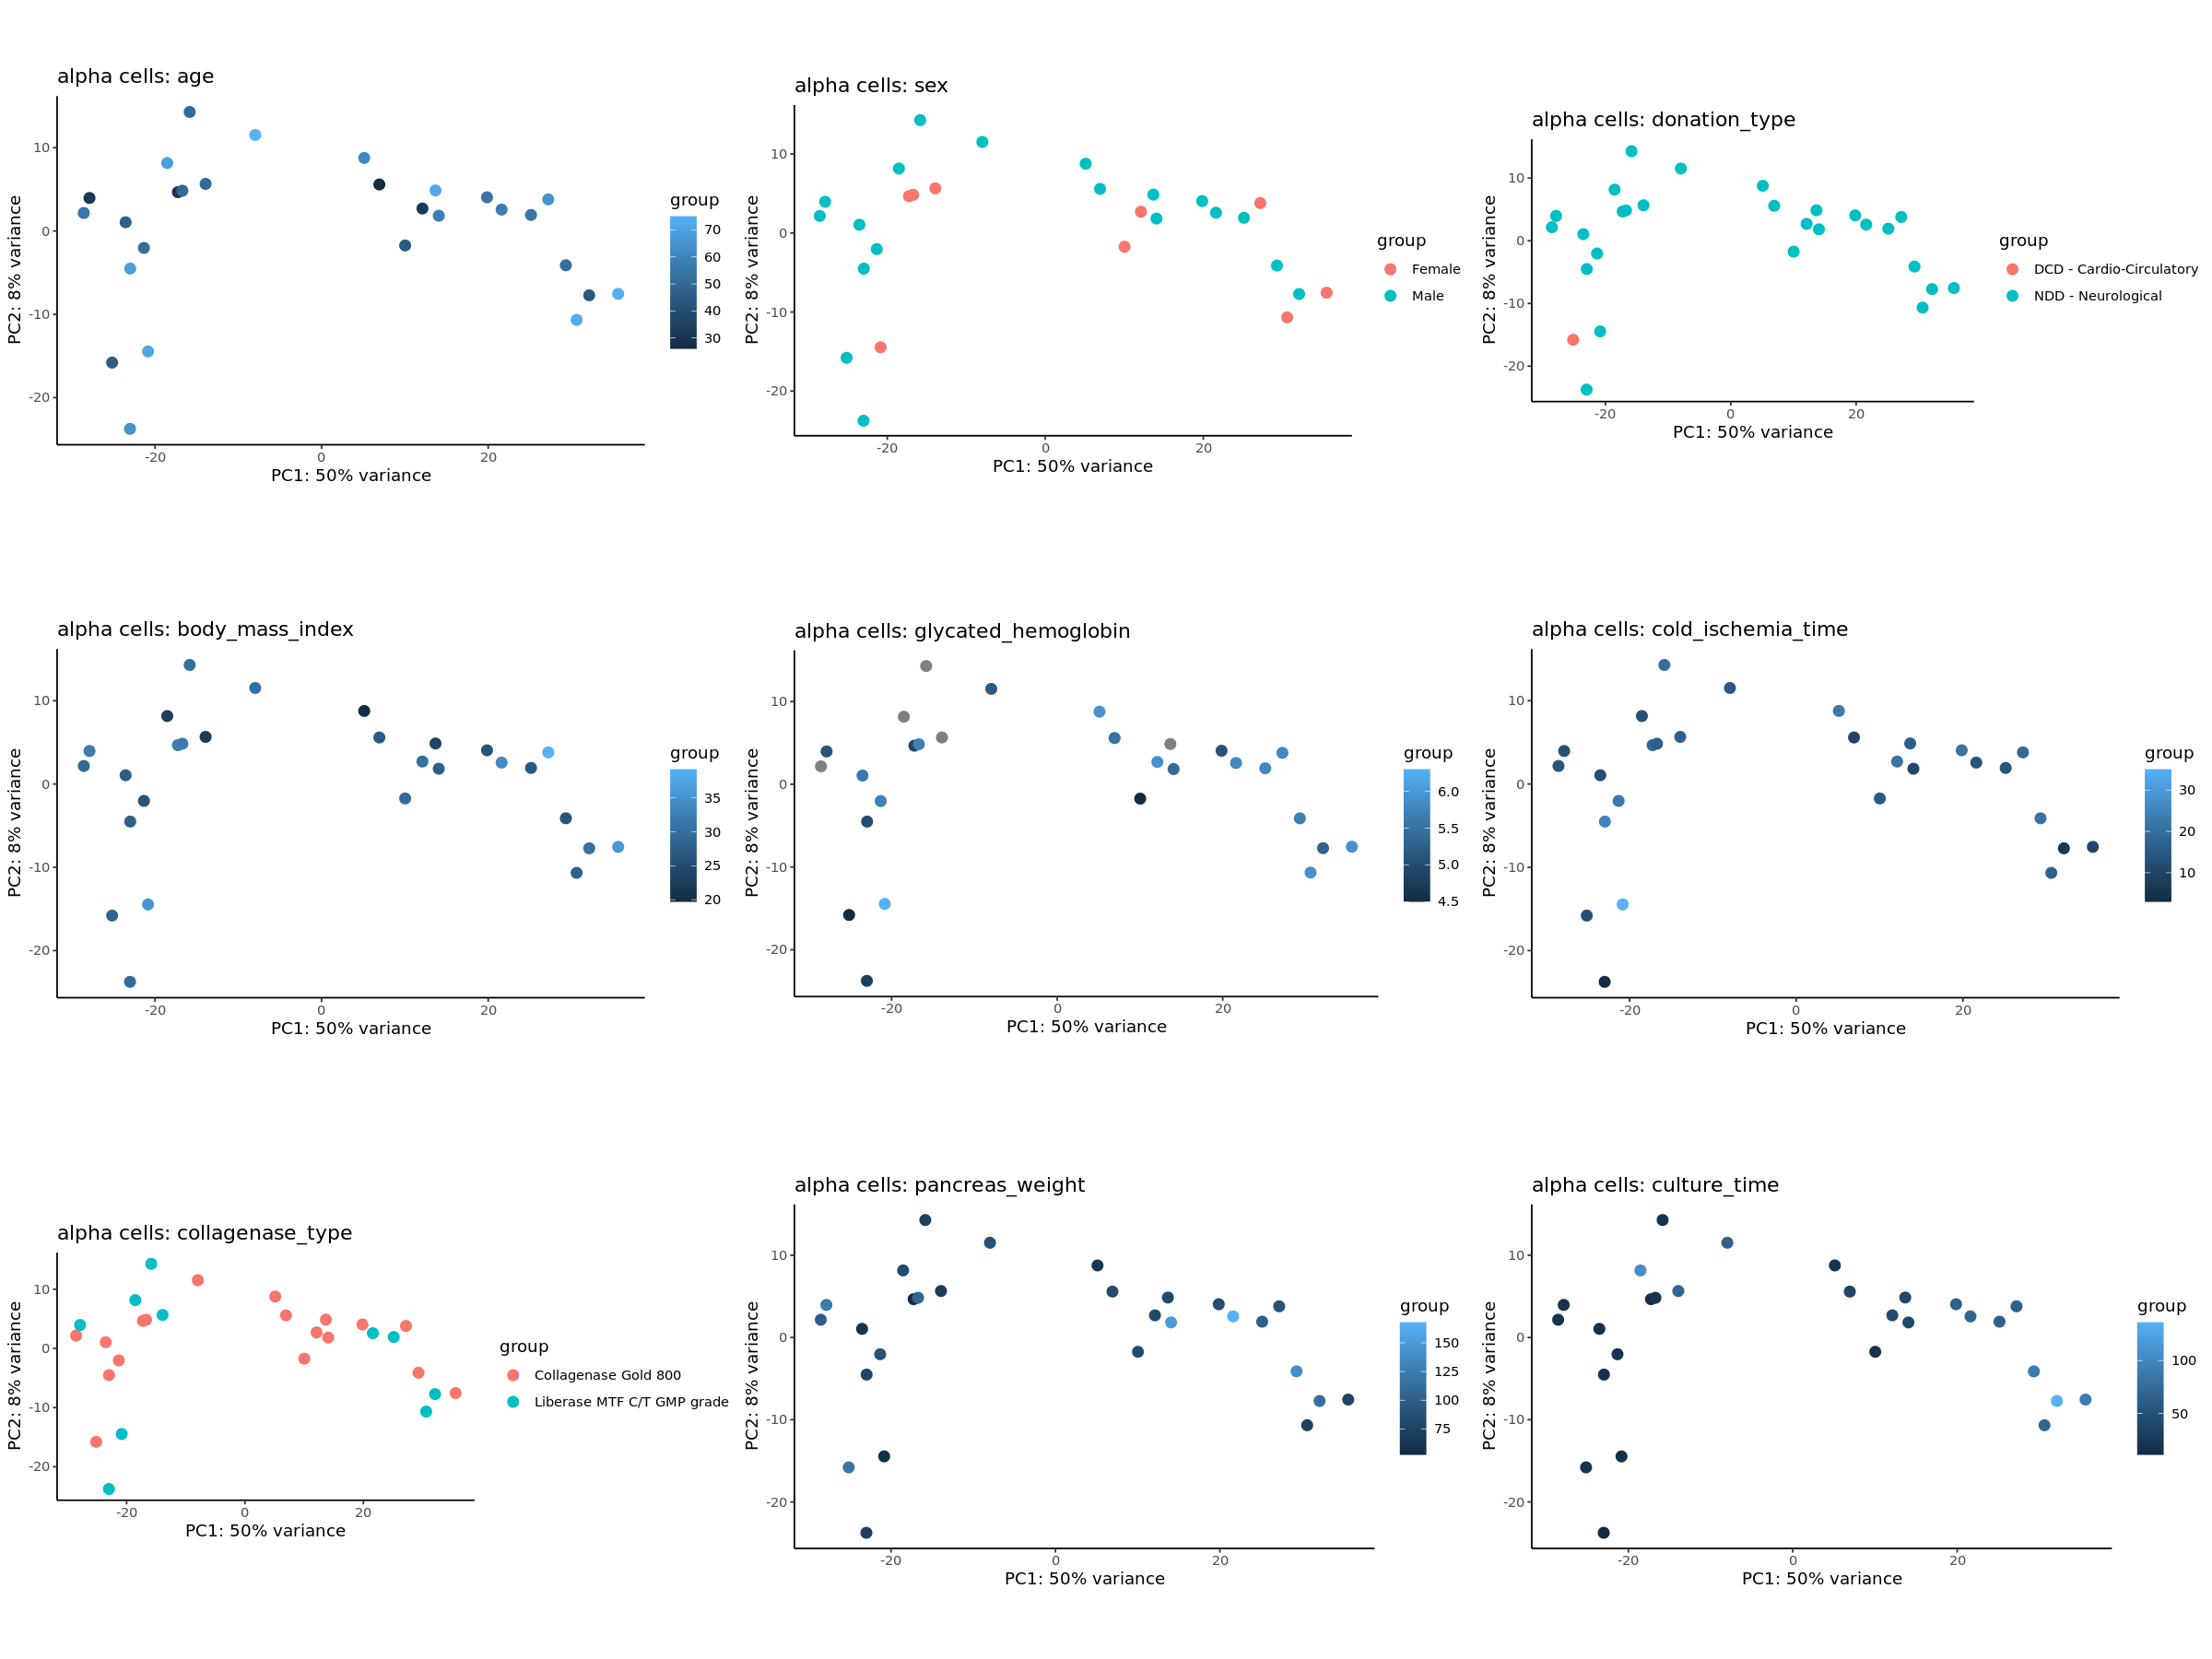

[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



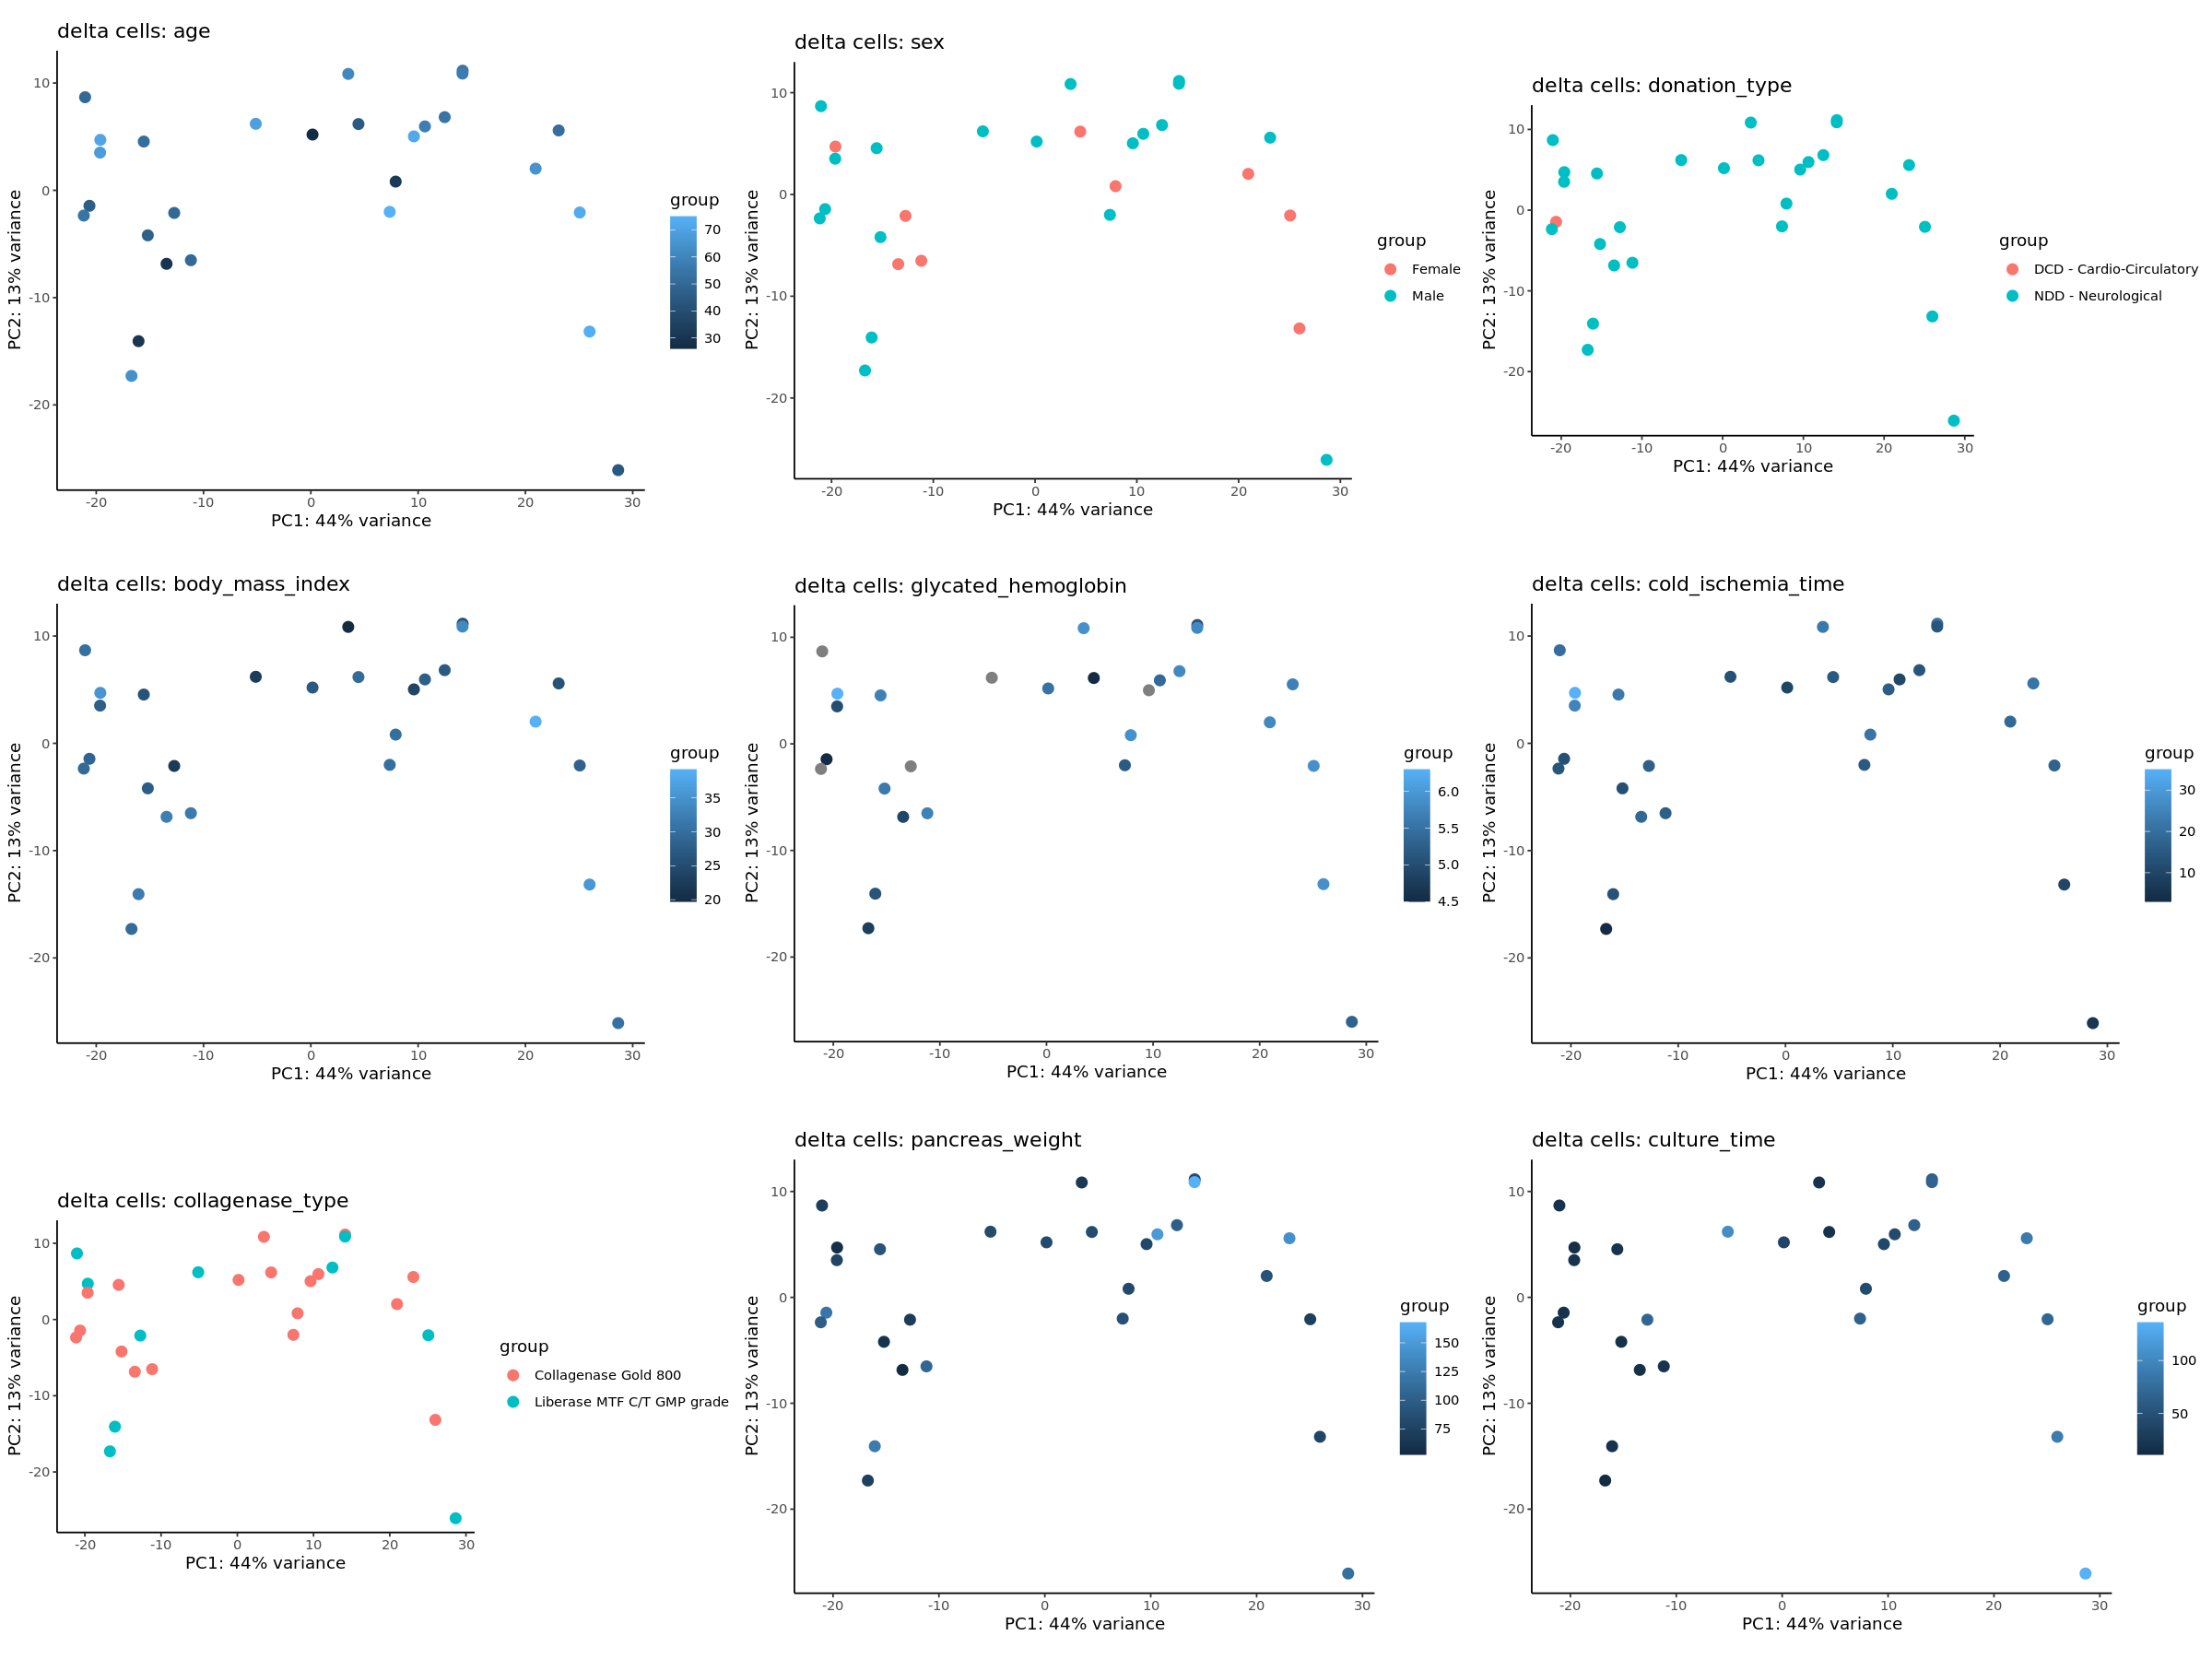

[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



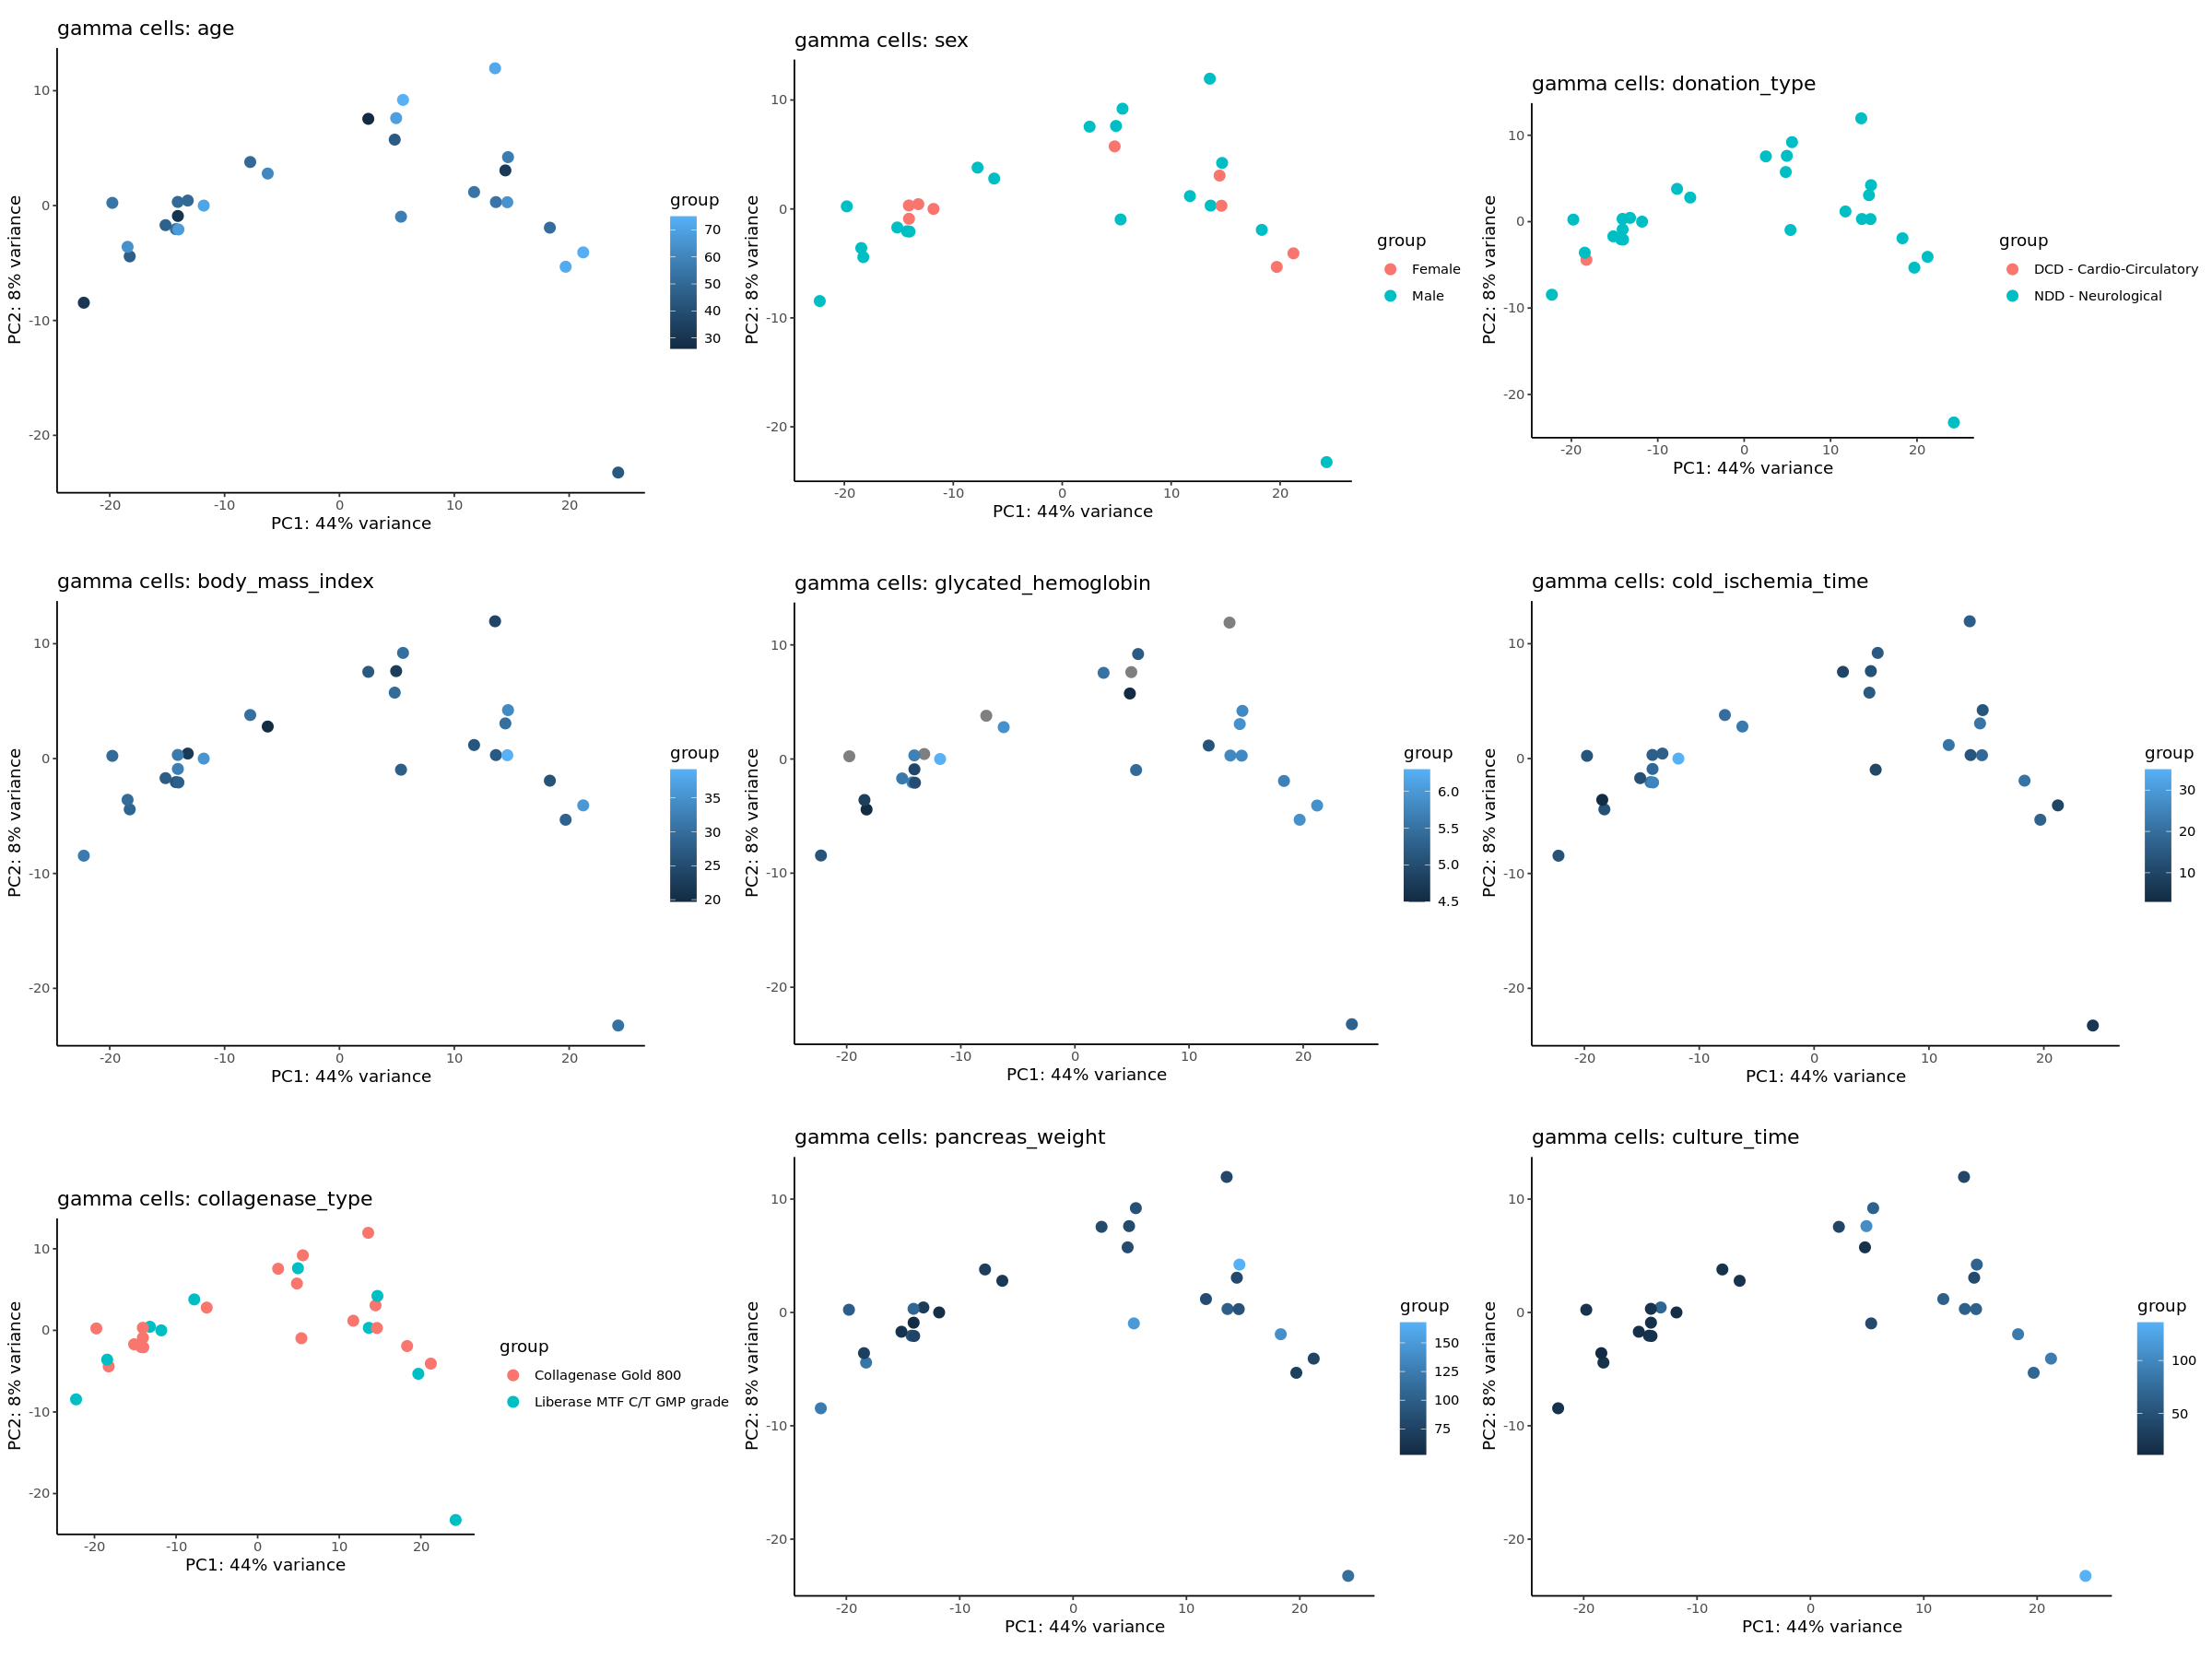

[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



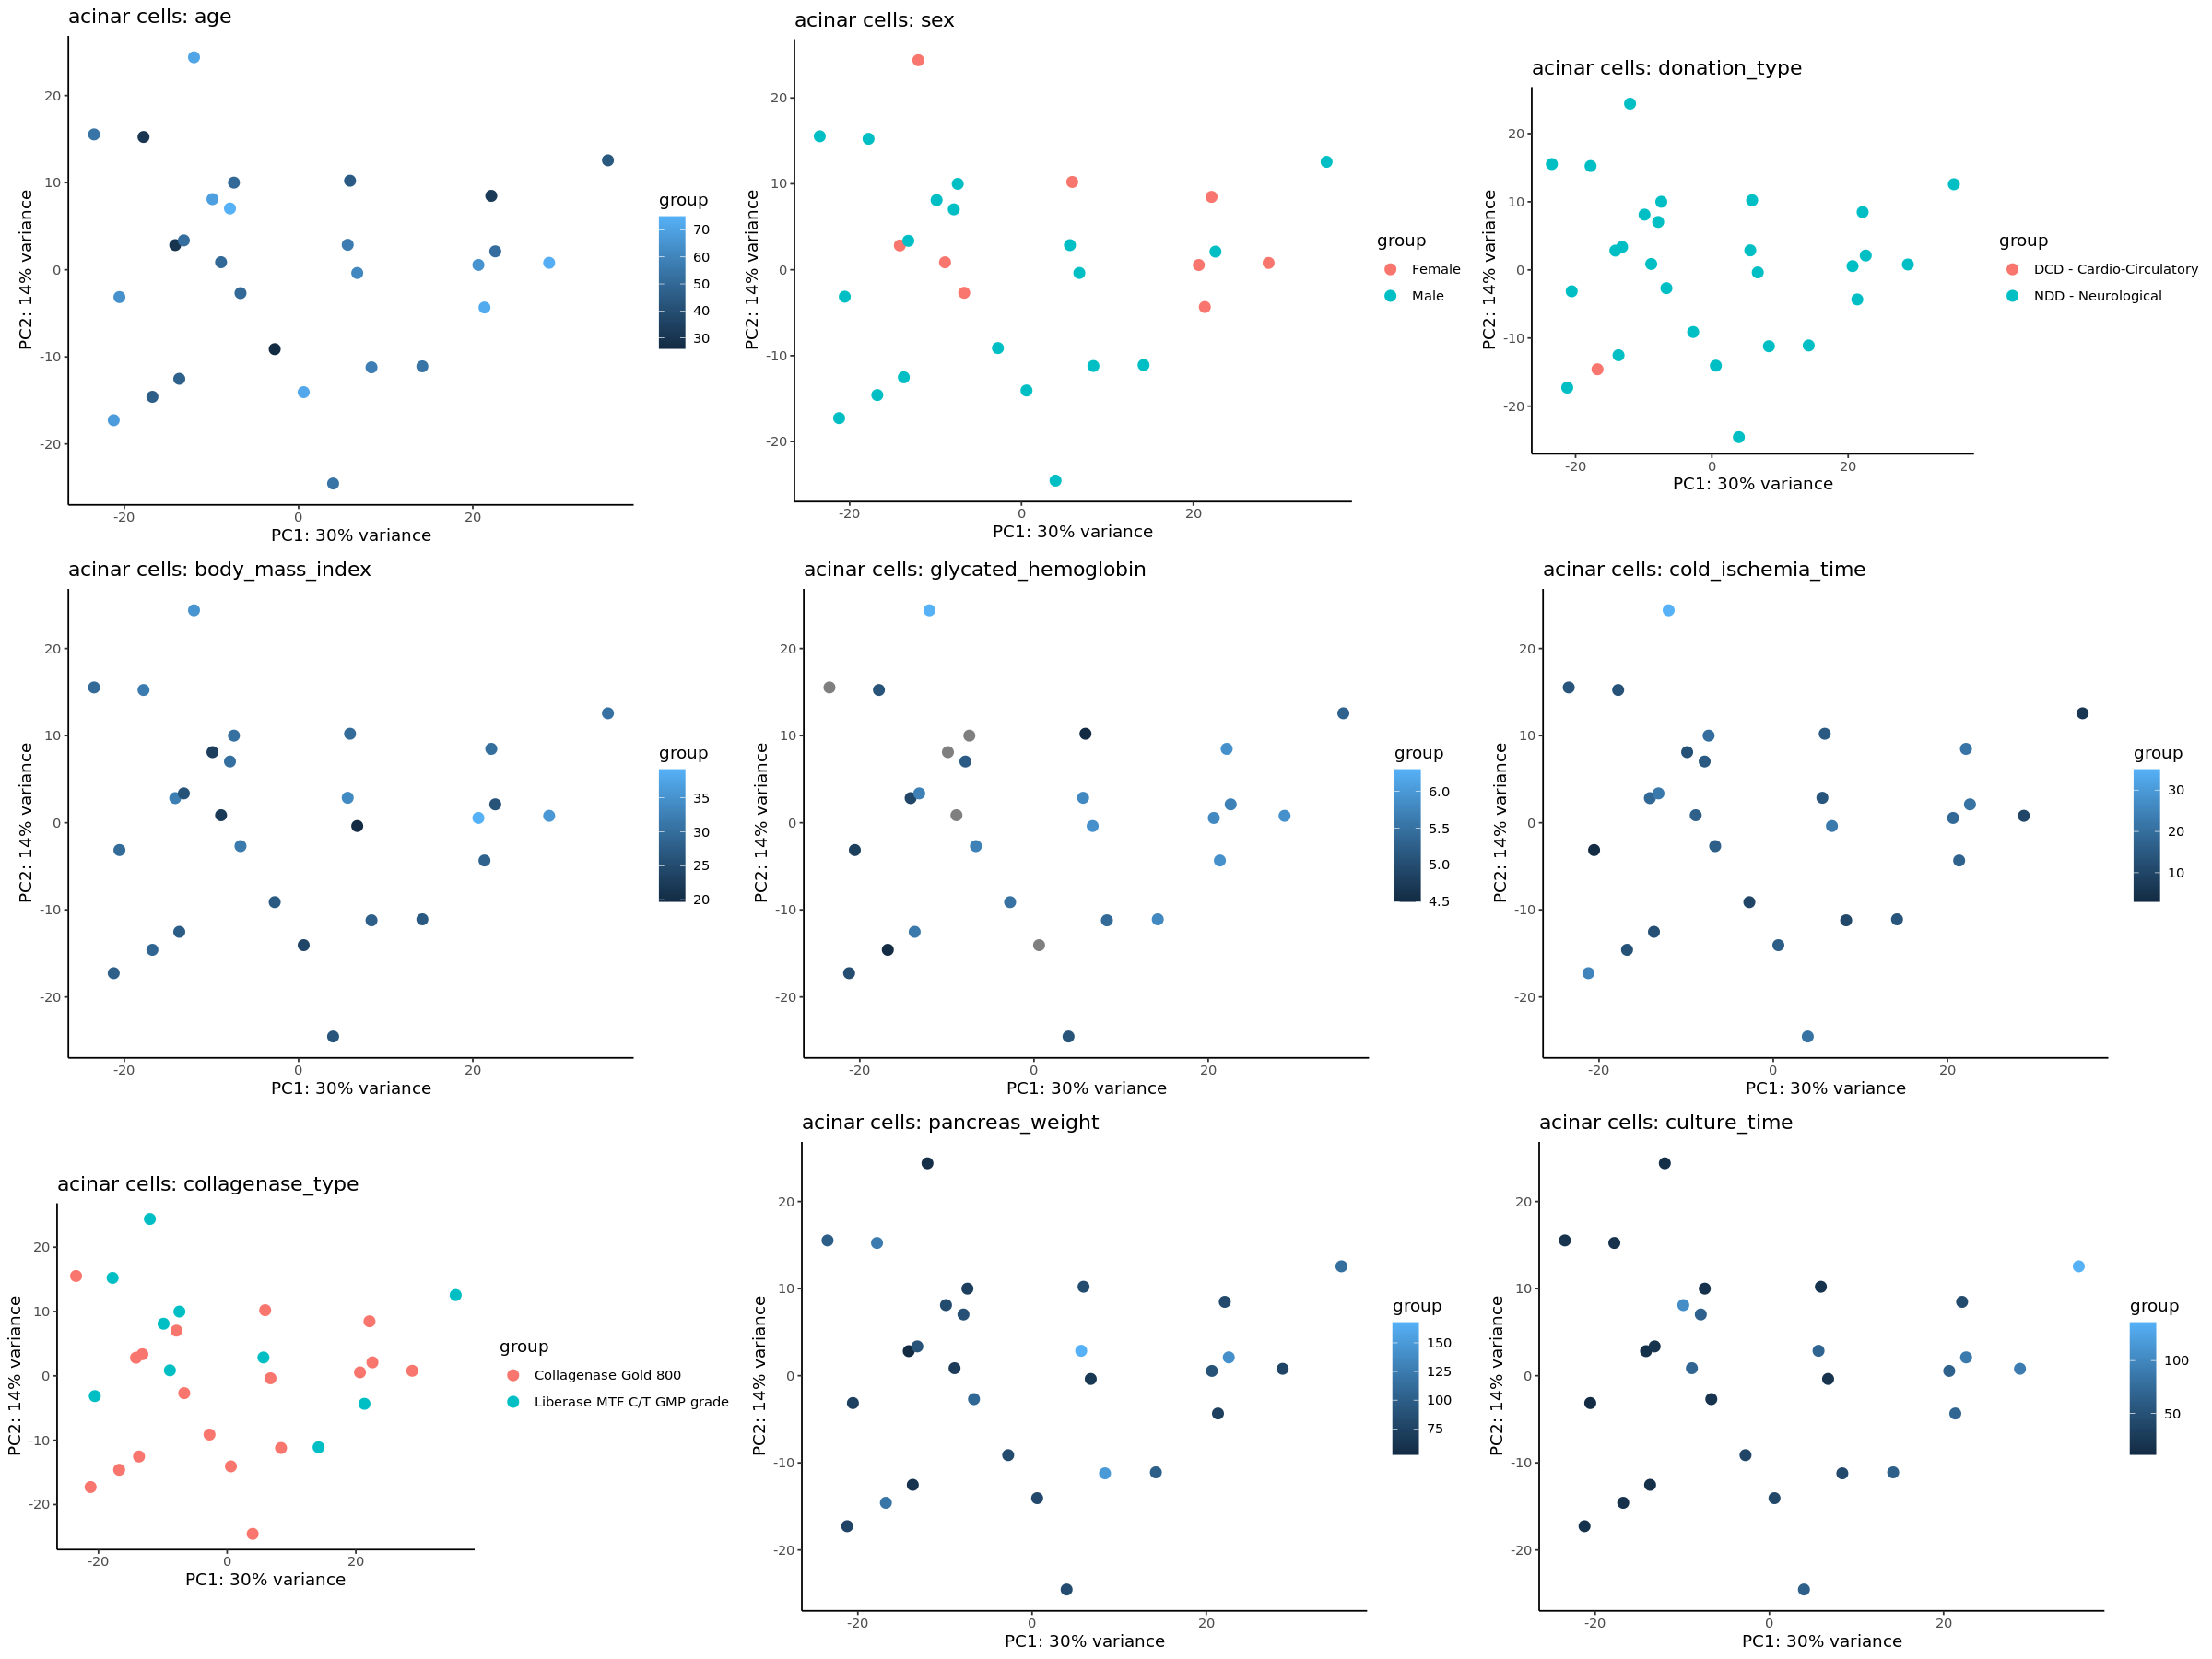

[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



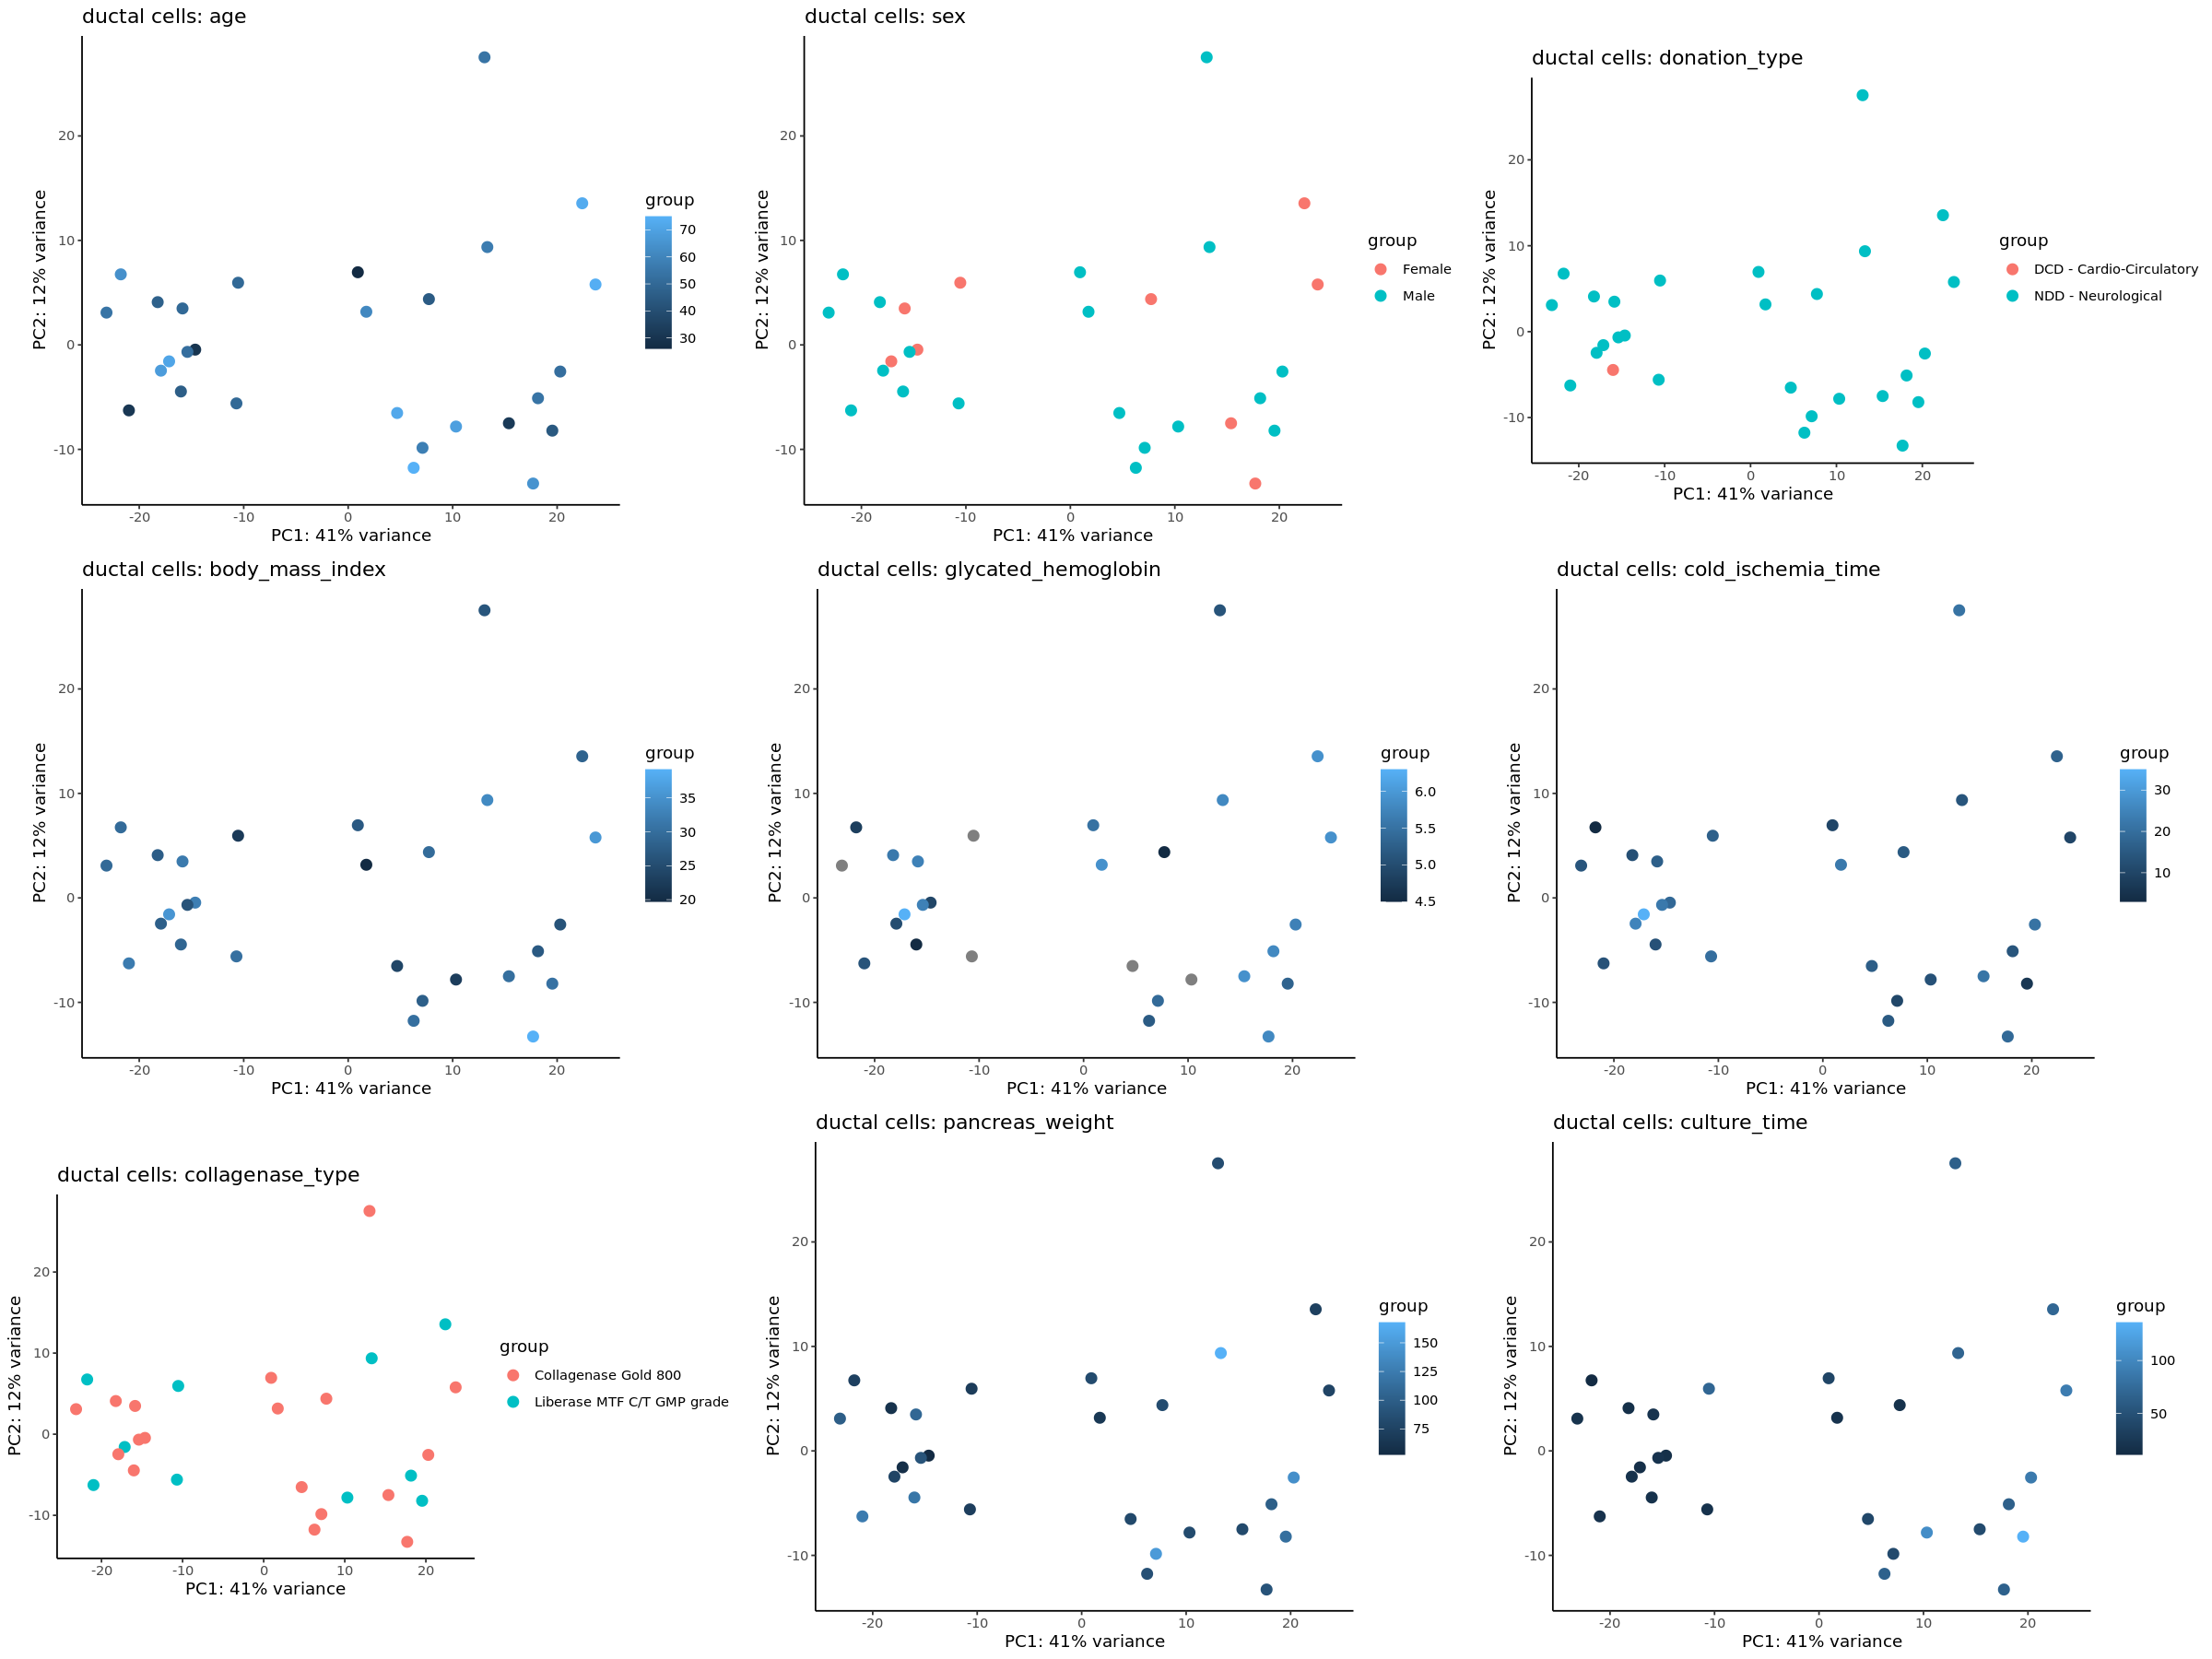

[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



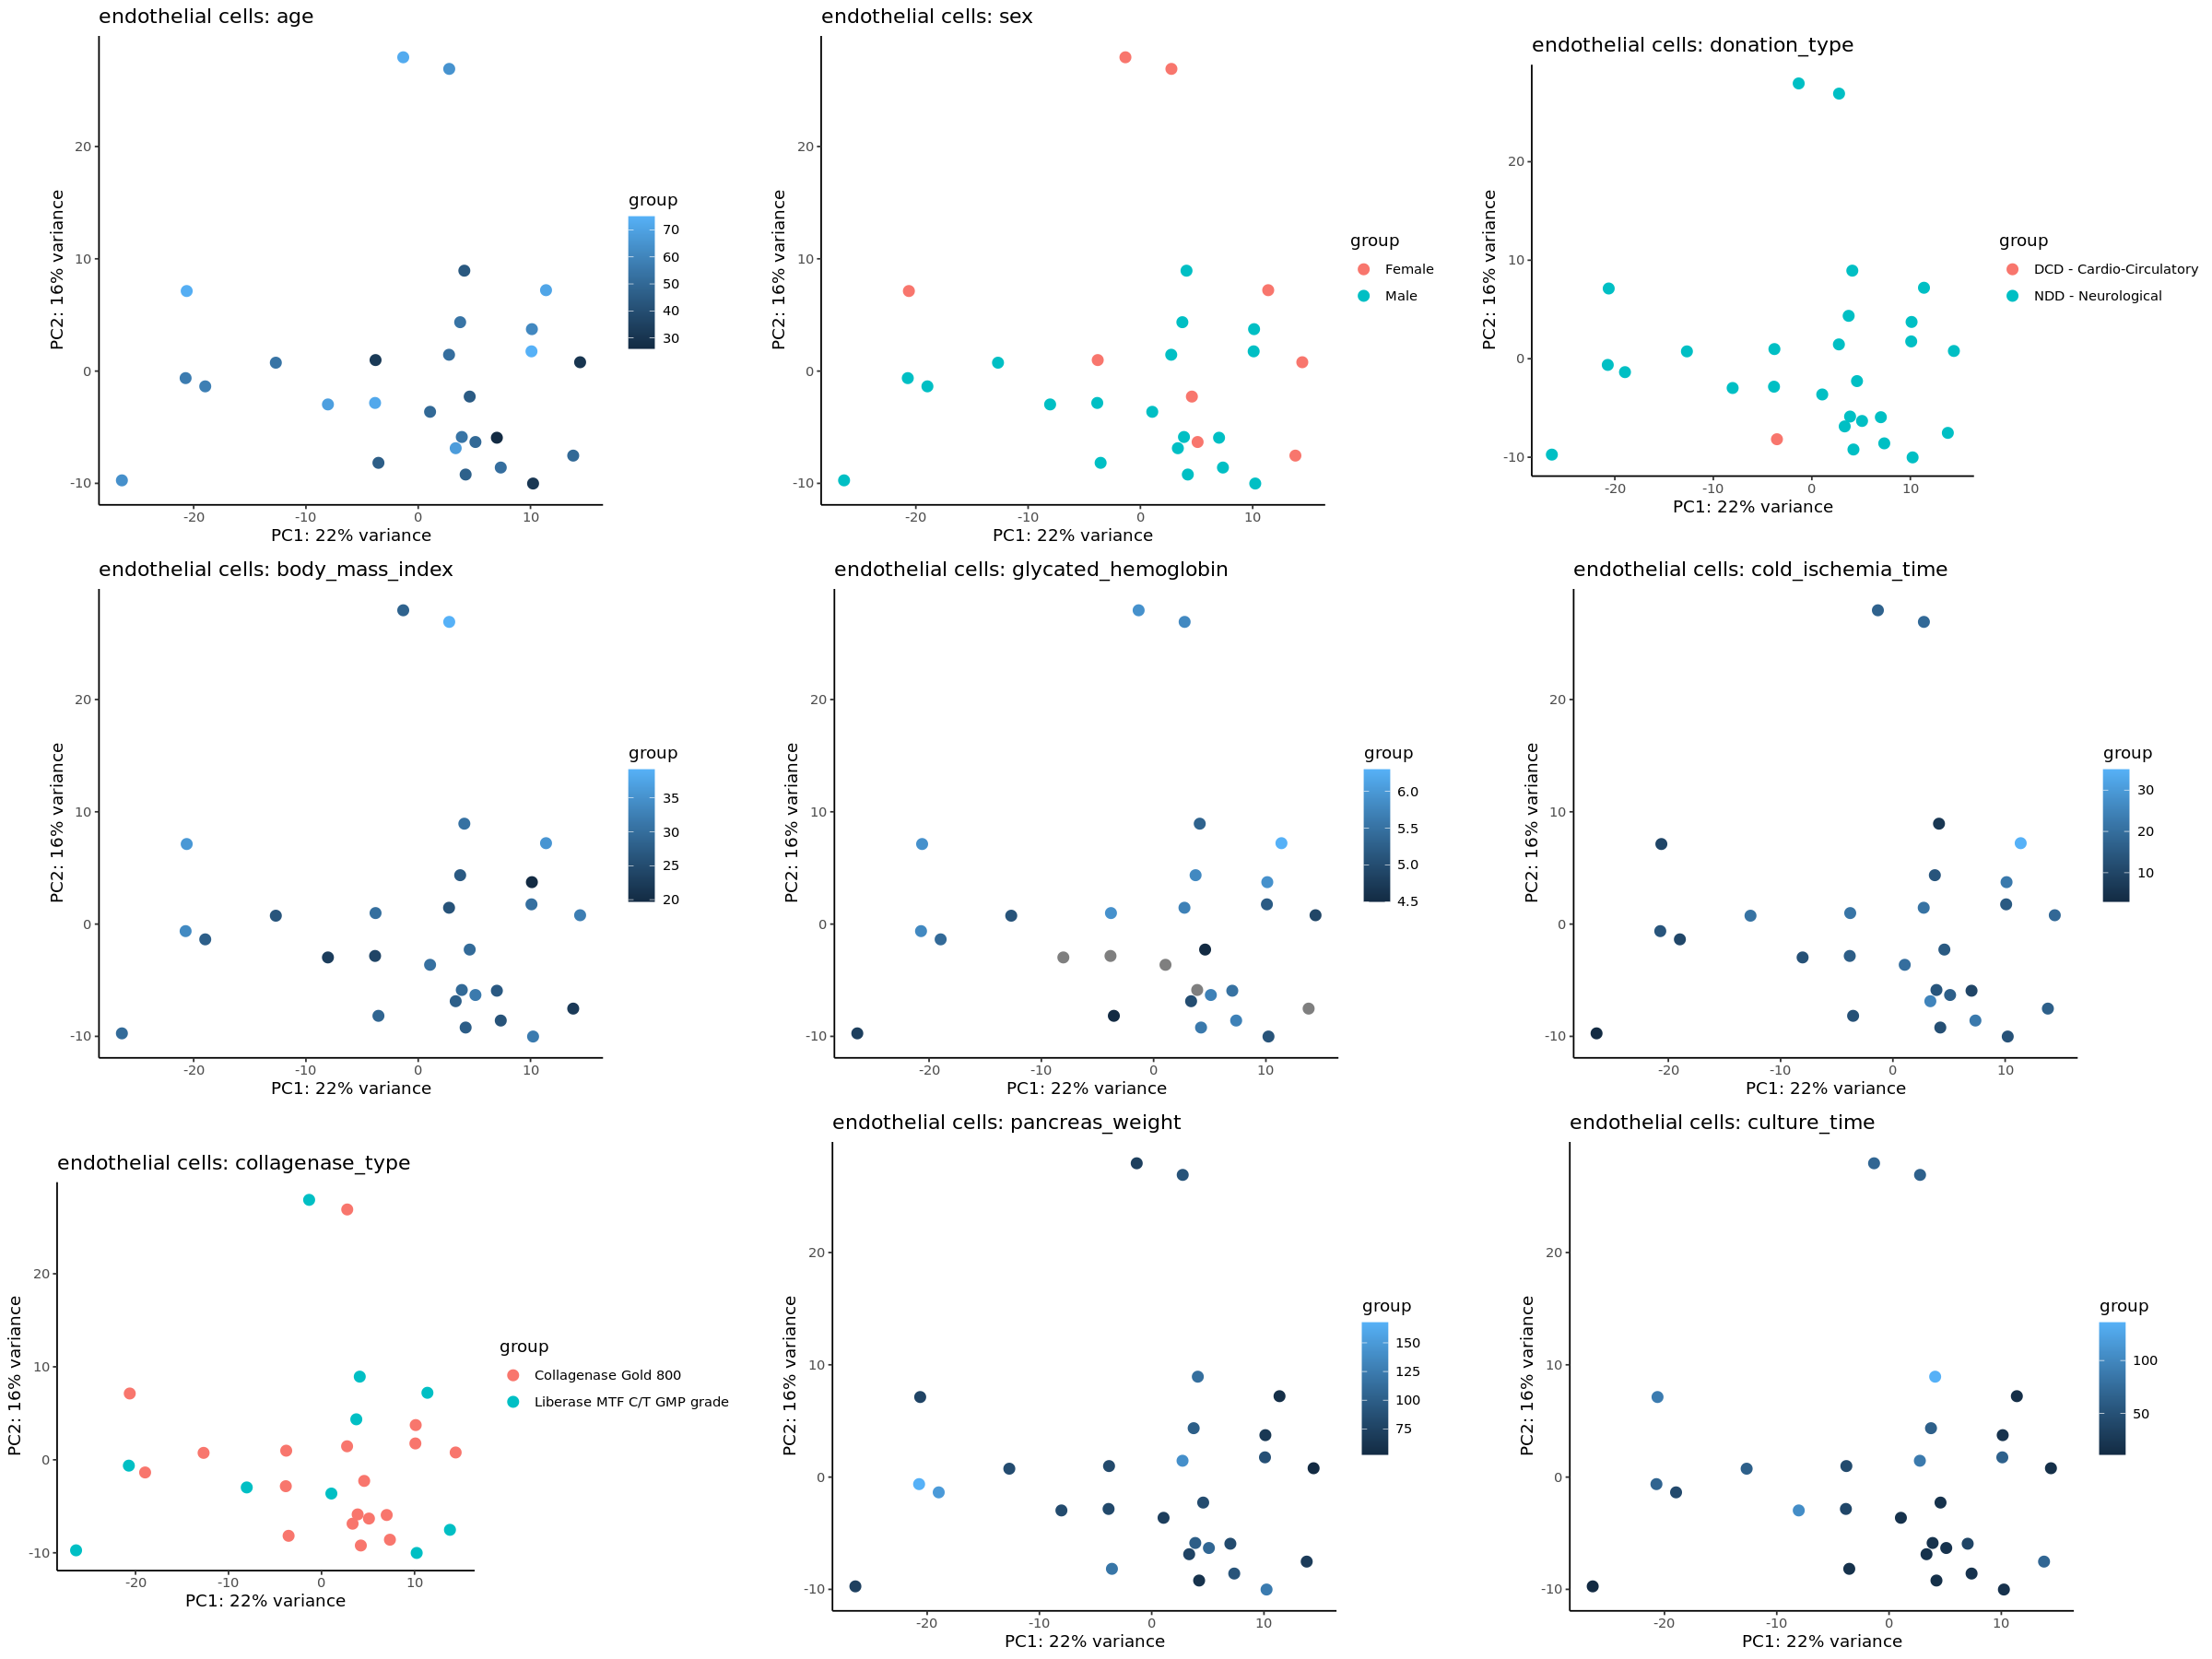

[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”


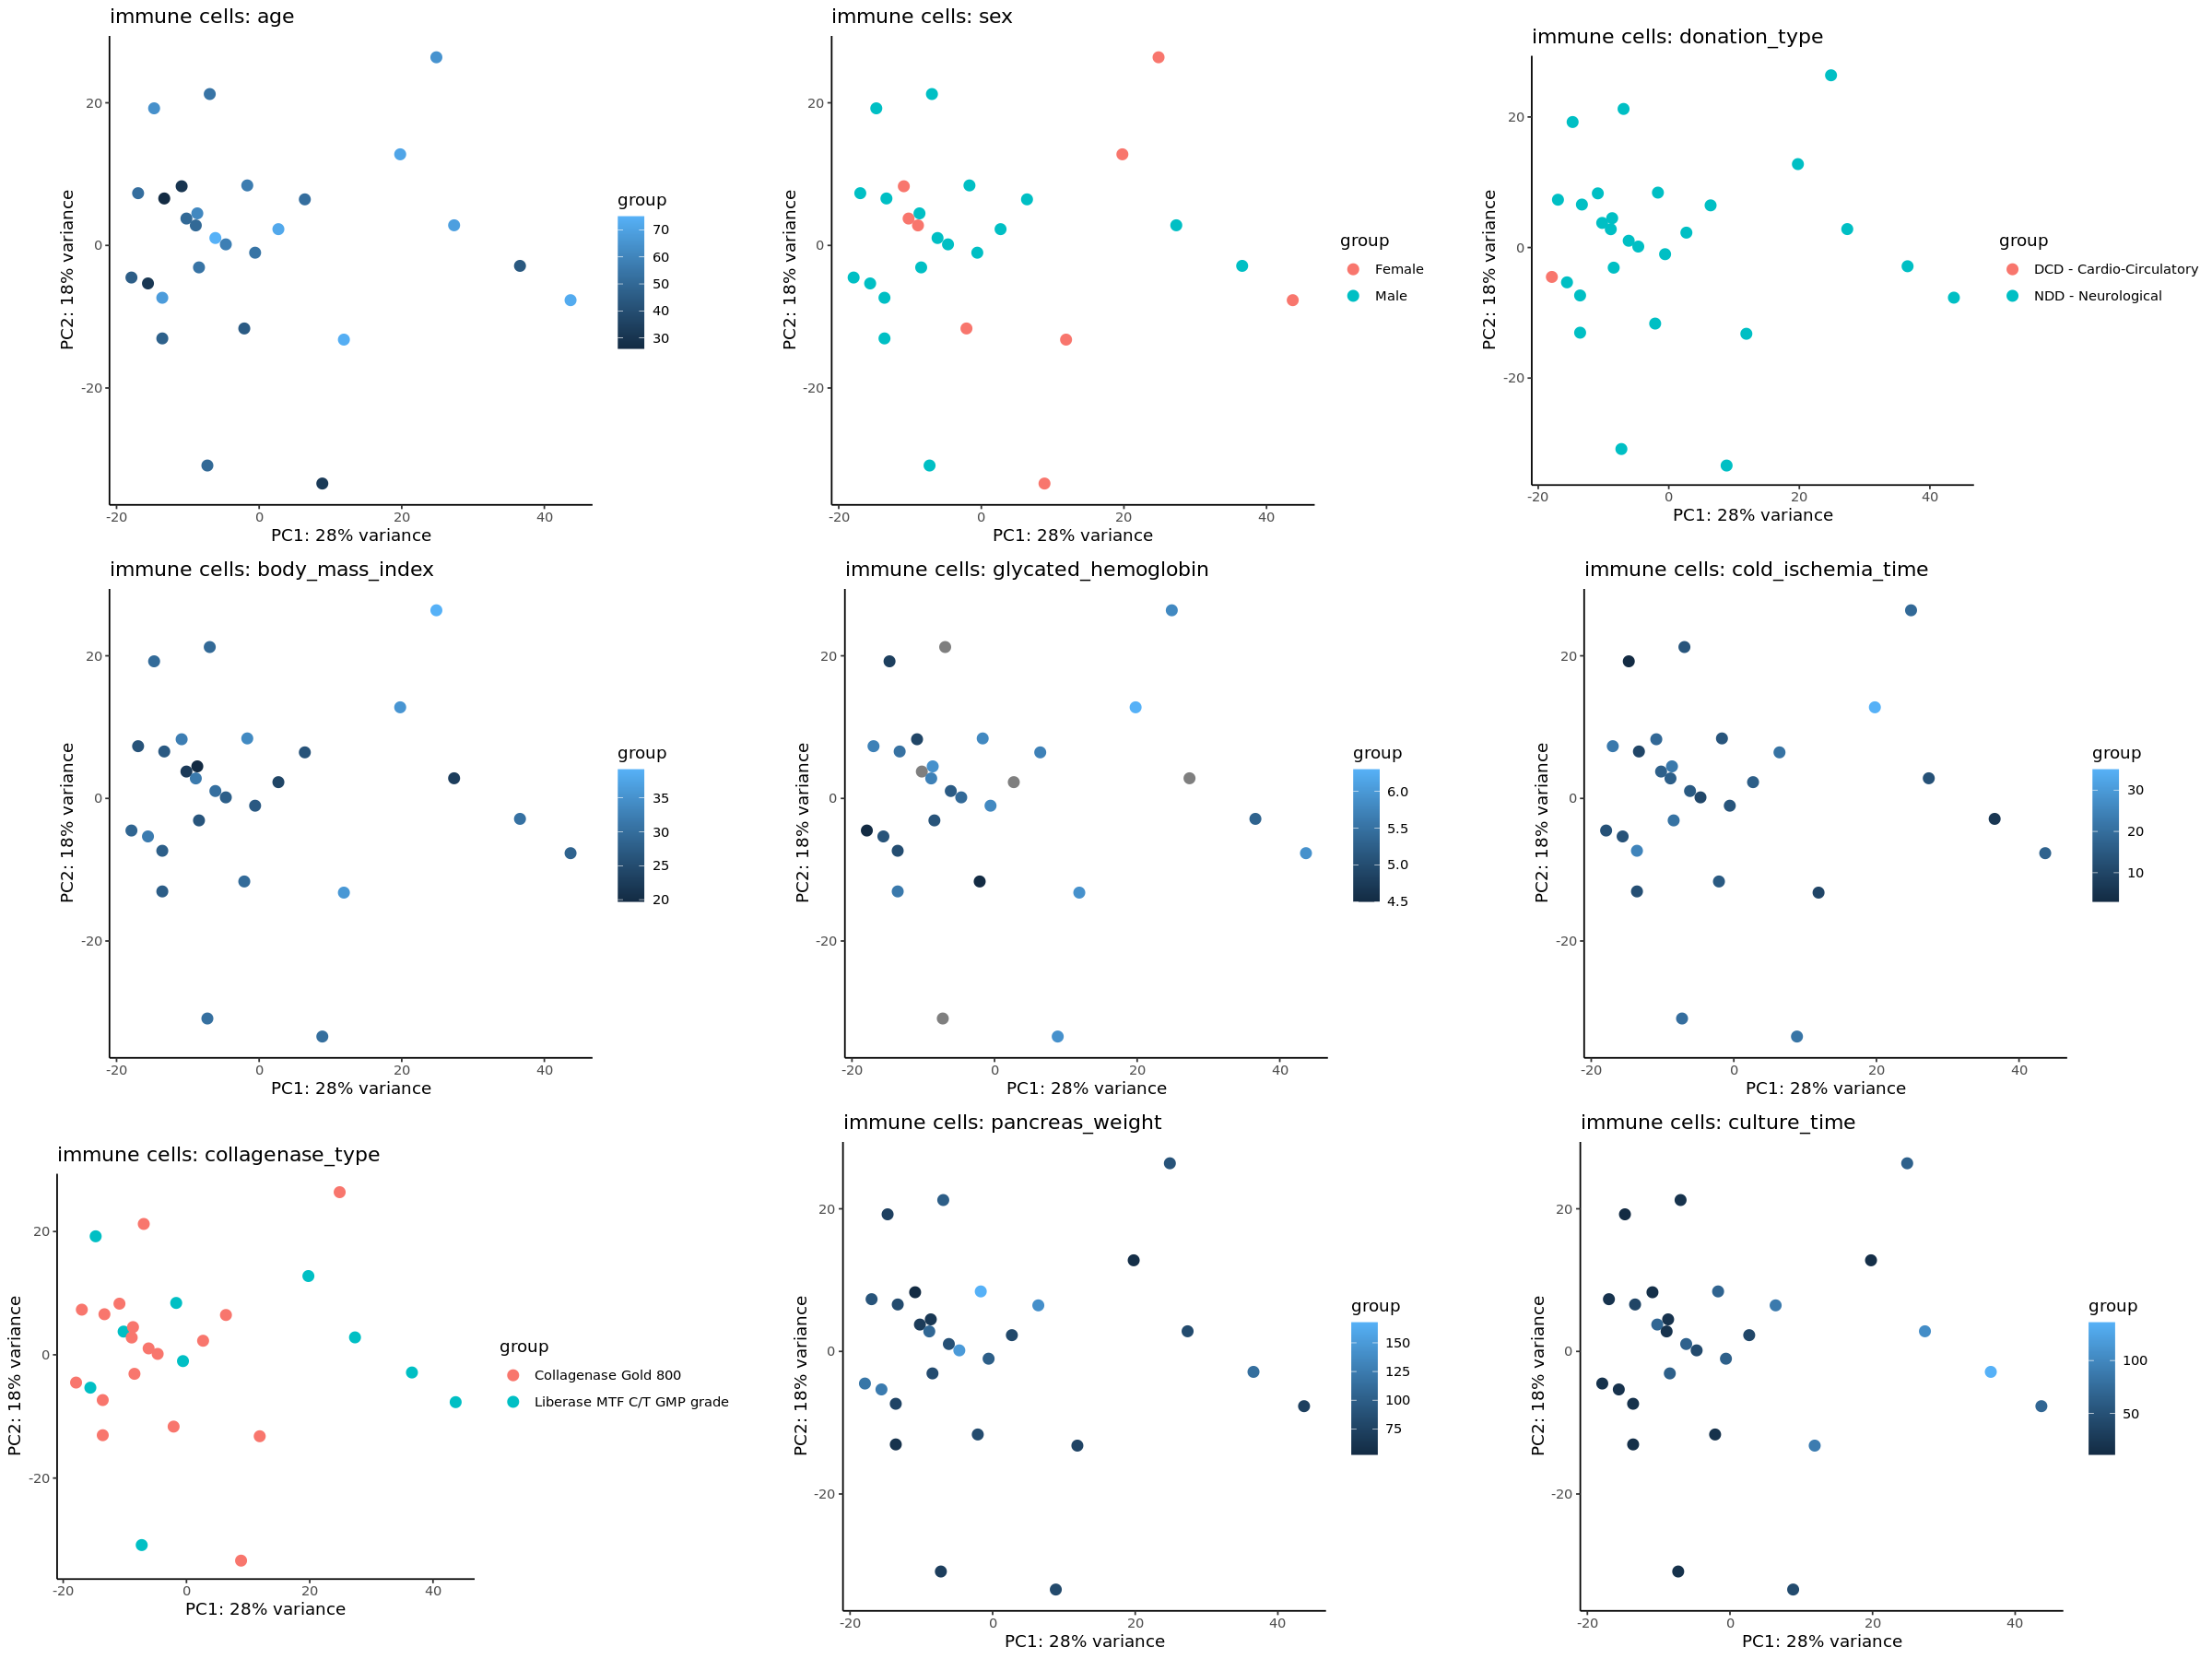

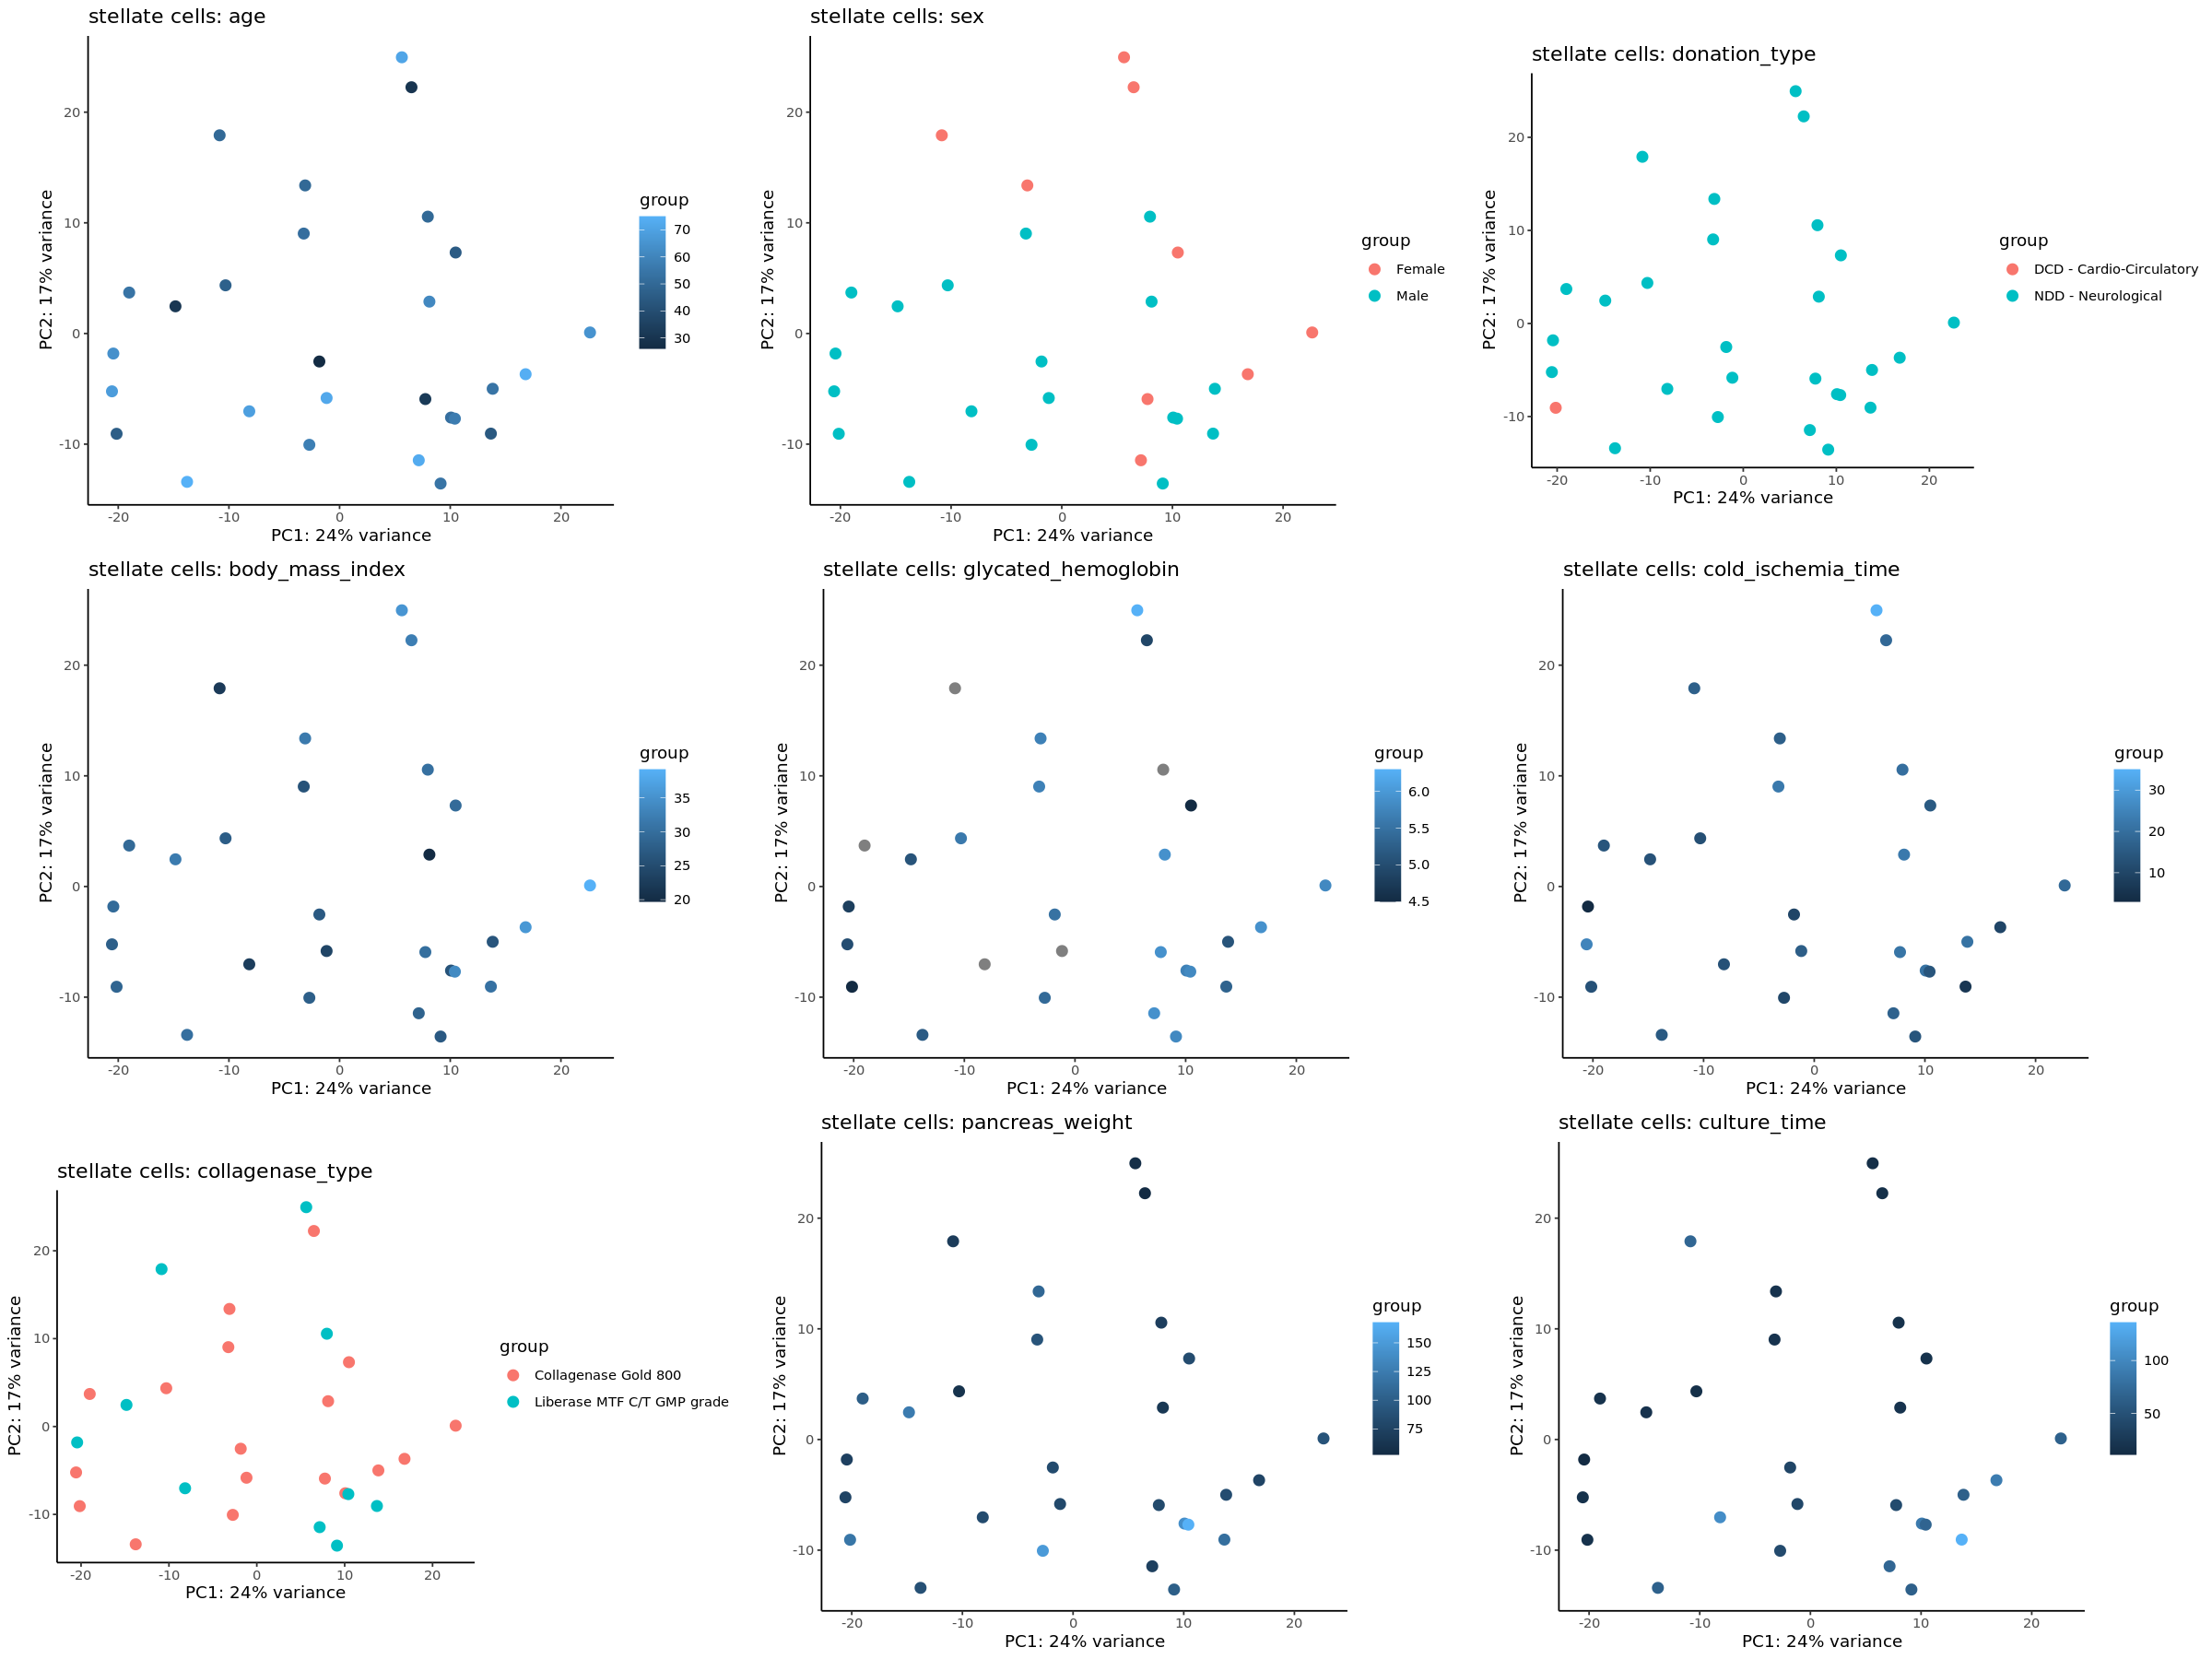

In [150]:
# VST normalized - autosomal genes
out_dir <- file.path(rna_dir,'embeds')
dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)

for (celltype in celltypes){
    # Get all genes expressed in the celltype
    fp <- file.path(genes_dir, sprintf('%s_expressed_genes_TPM1.txt', celltype))
    ct_genes <- scan(fp, what='', sep='\n')
    ct_genes_auto <- ct_genes[ct_genes %in% auto_genes]
    
    # Call function to calculate and save pc embeds
    generate_pc_embeds(celltype, rna_tables, ct_genes_auto, plot_vars, norm_method = 'vst', 'RNA', ntop=500, nPCs=20, out_dir)
}

## Perform PCA on donor-pseudobulks for each cell type -- ATAC

In [17]:
plot_vars <- c('age','sex','donation_type','body_mass_index','glycated_hemoglobin',
               'cold_ischemia_time','collagenase_type','pancreas_weight','culture_time')

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



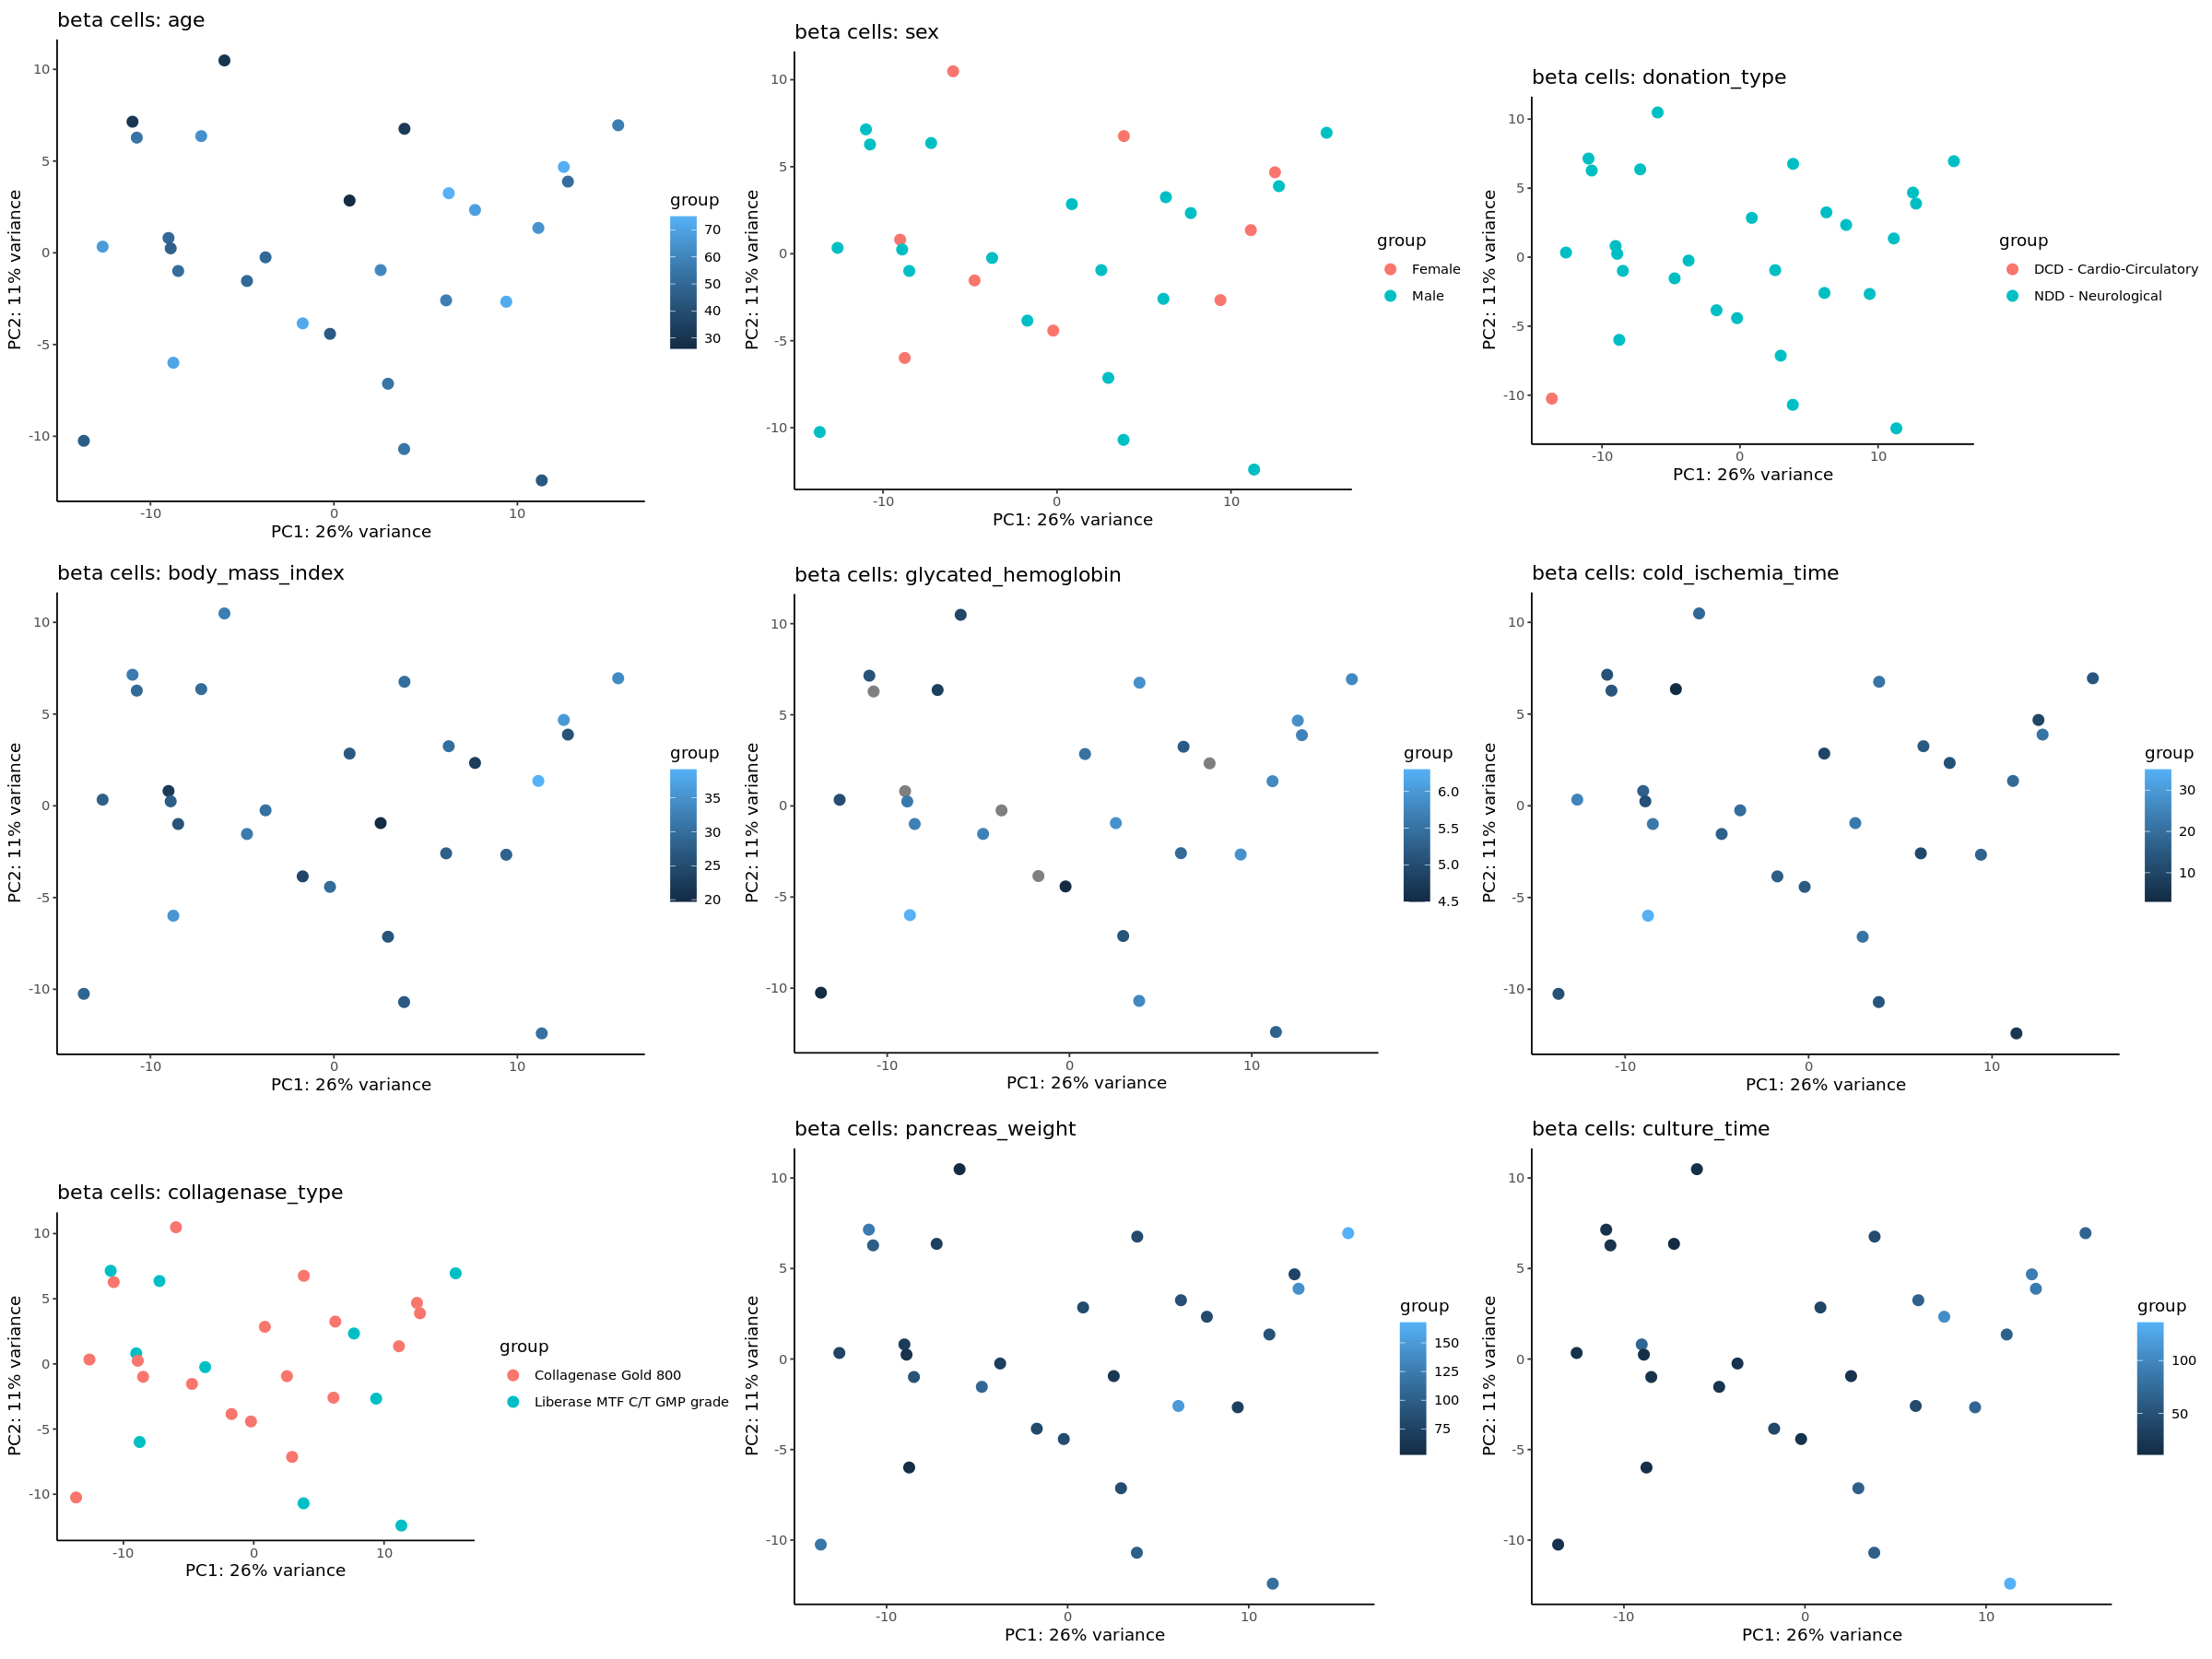

[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



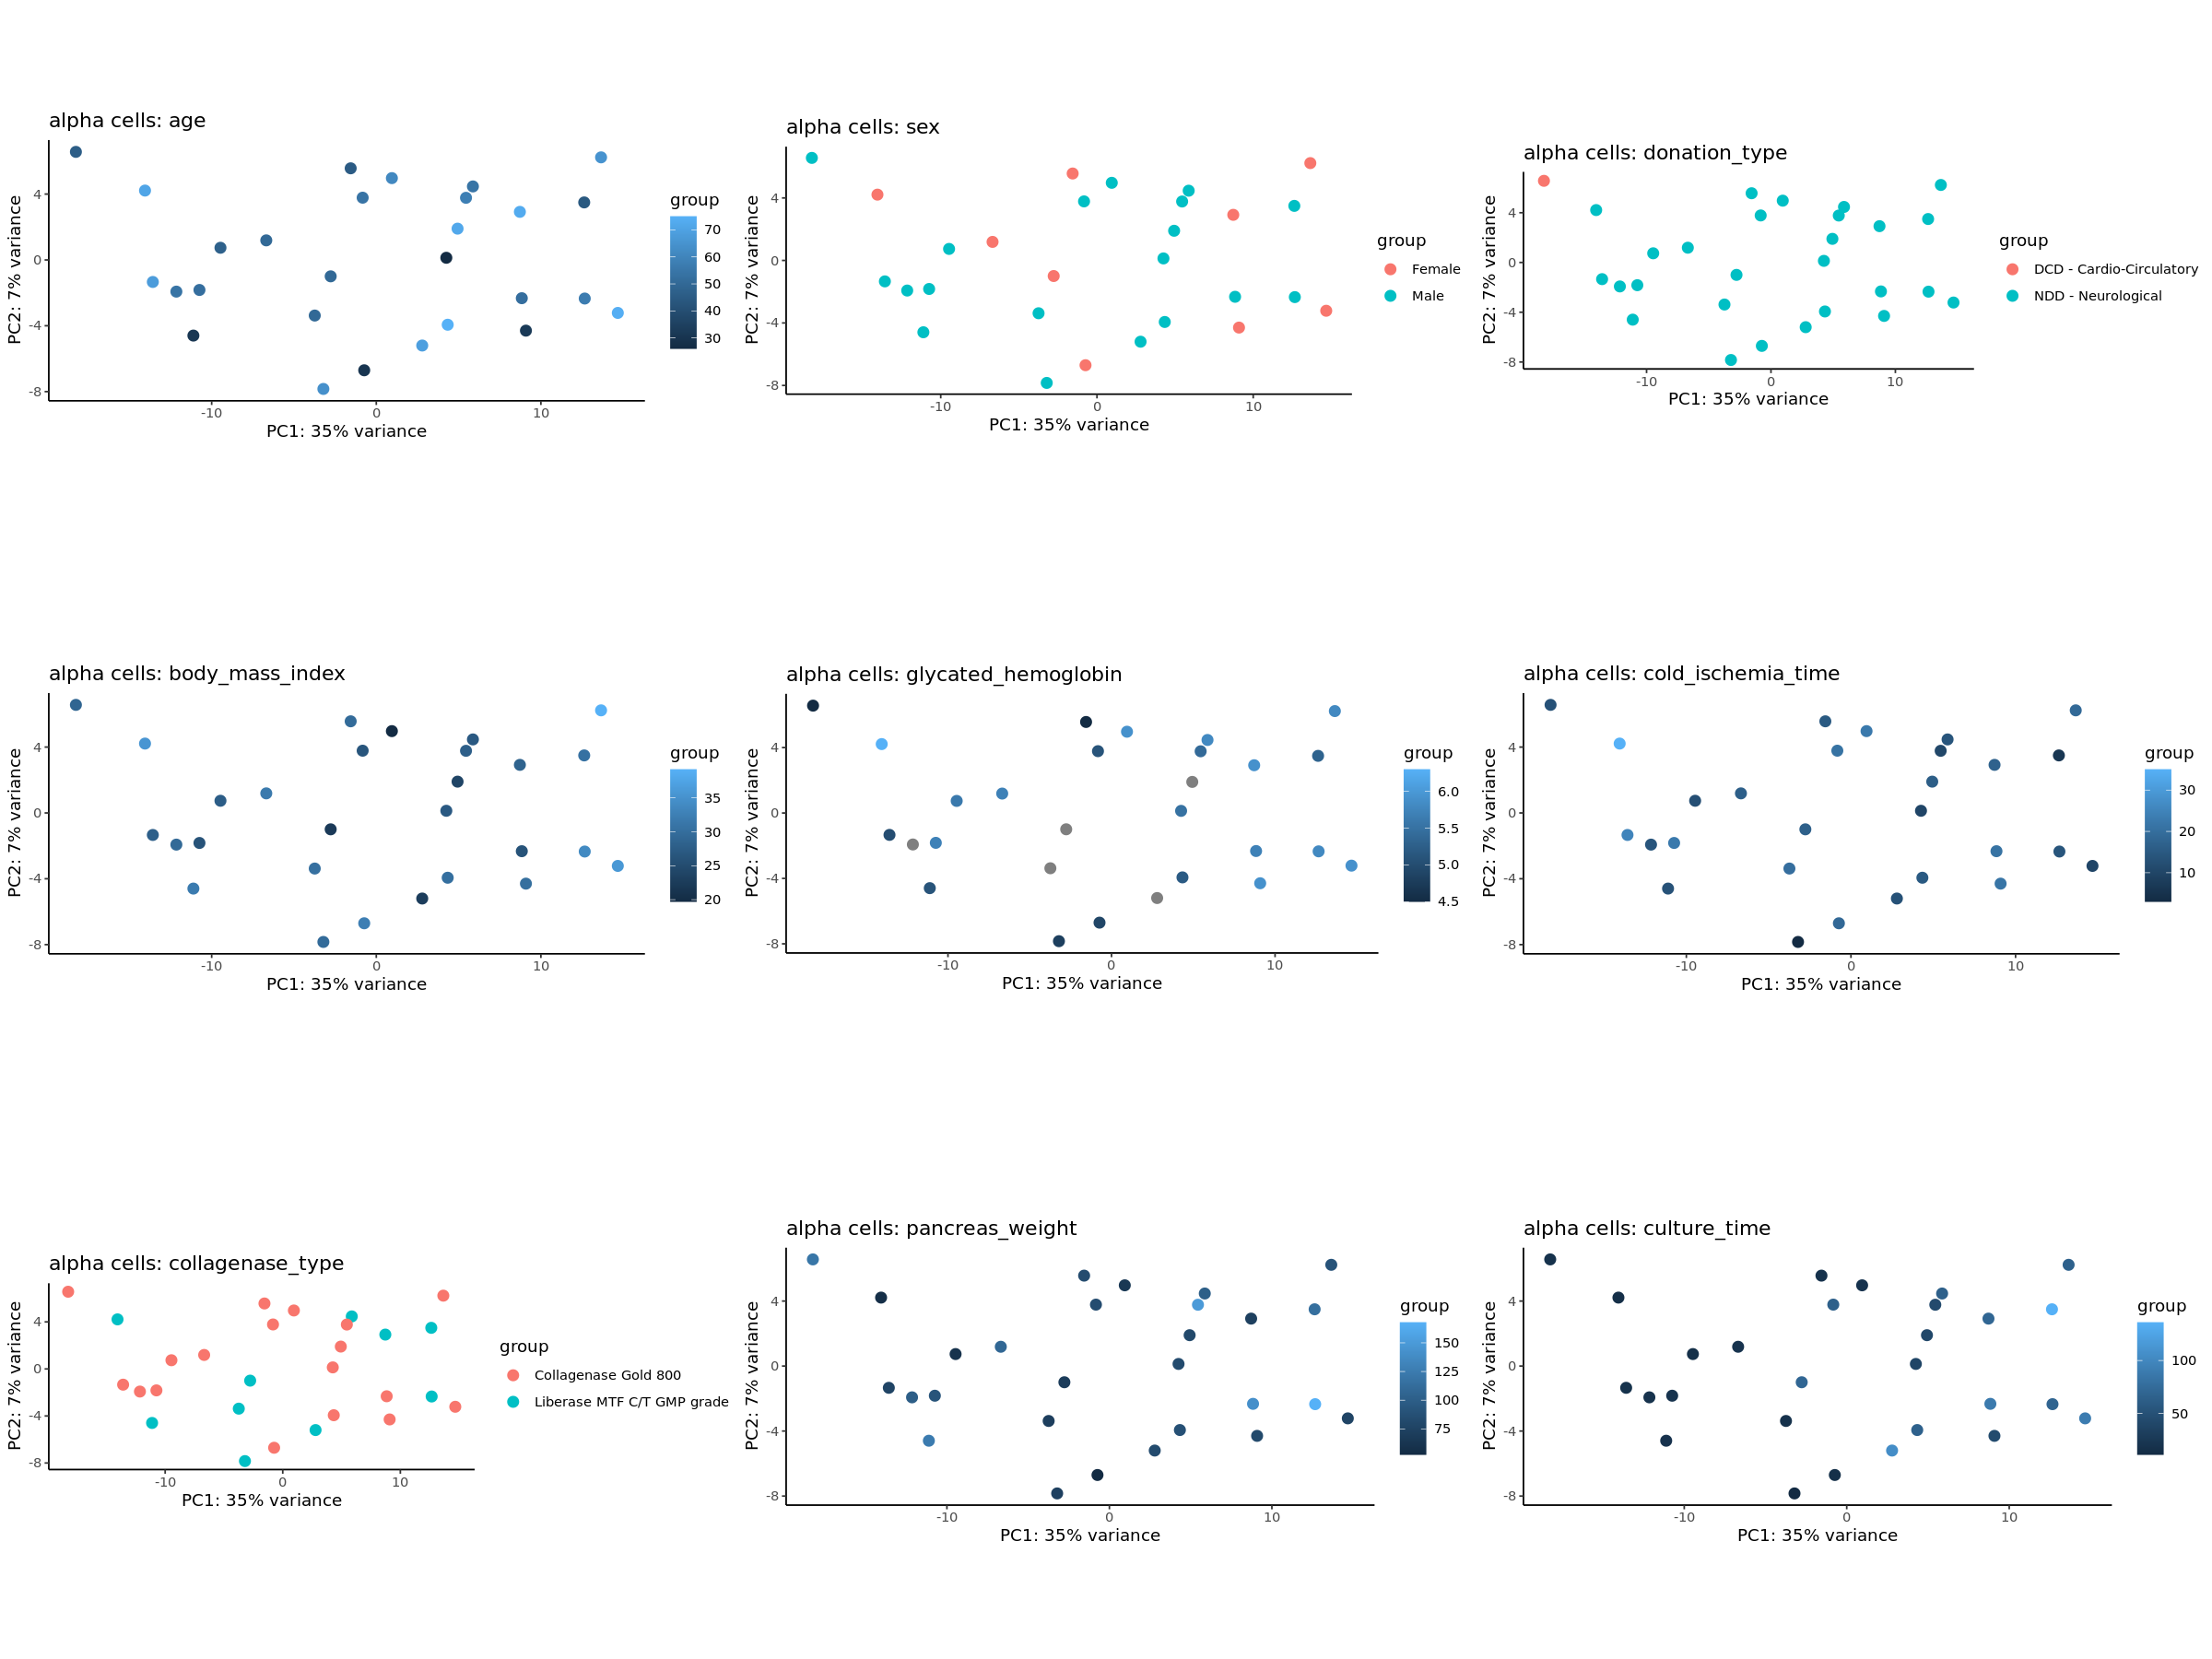

[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



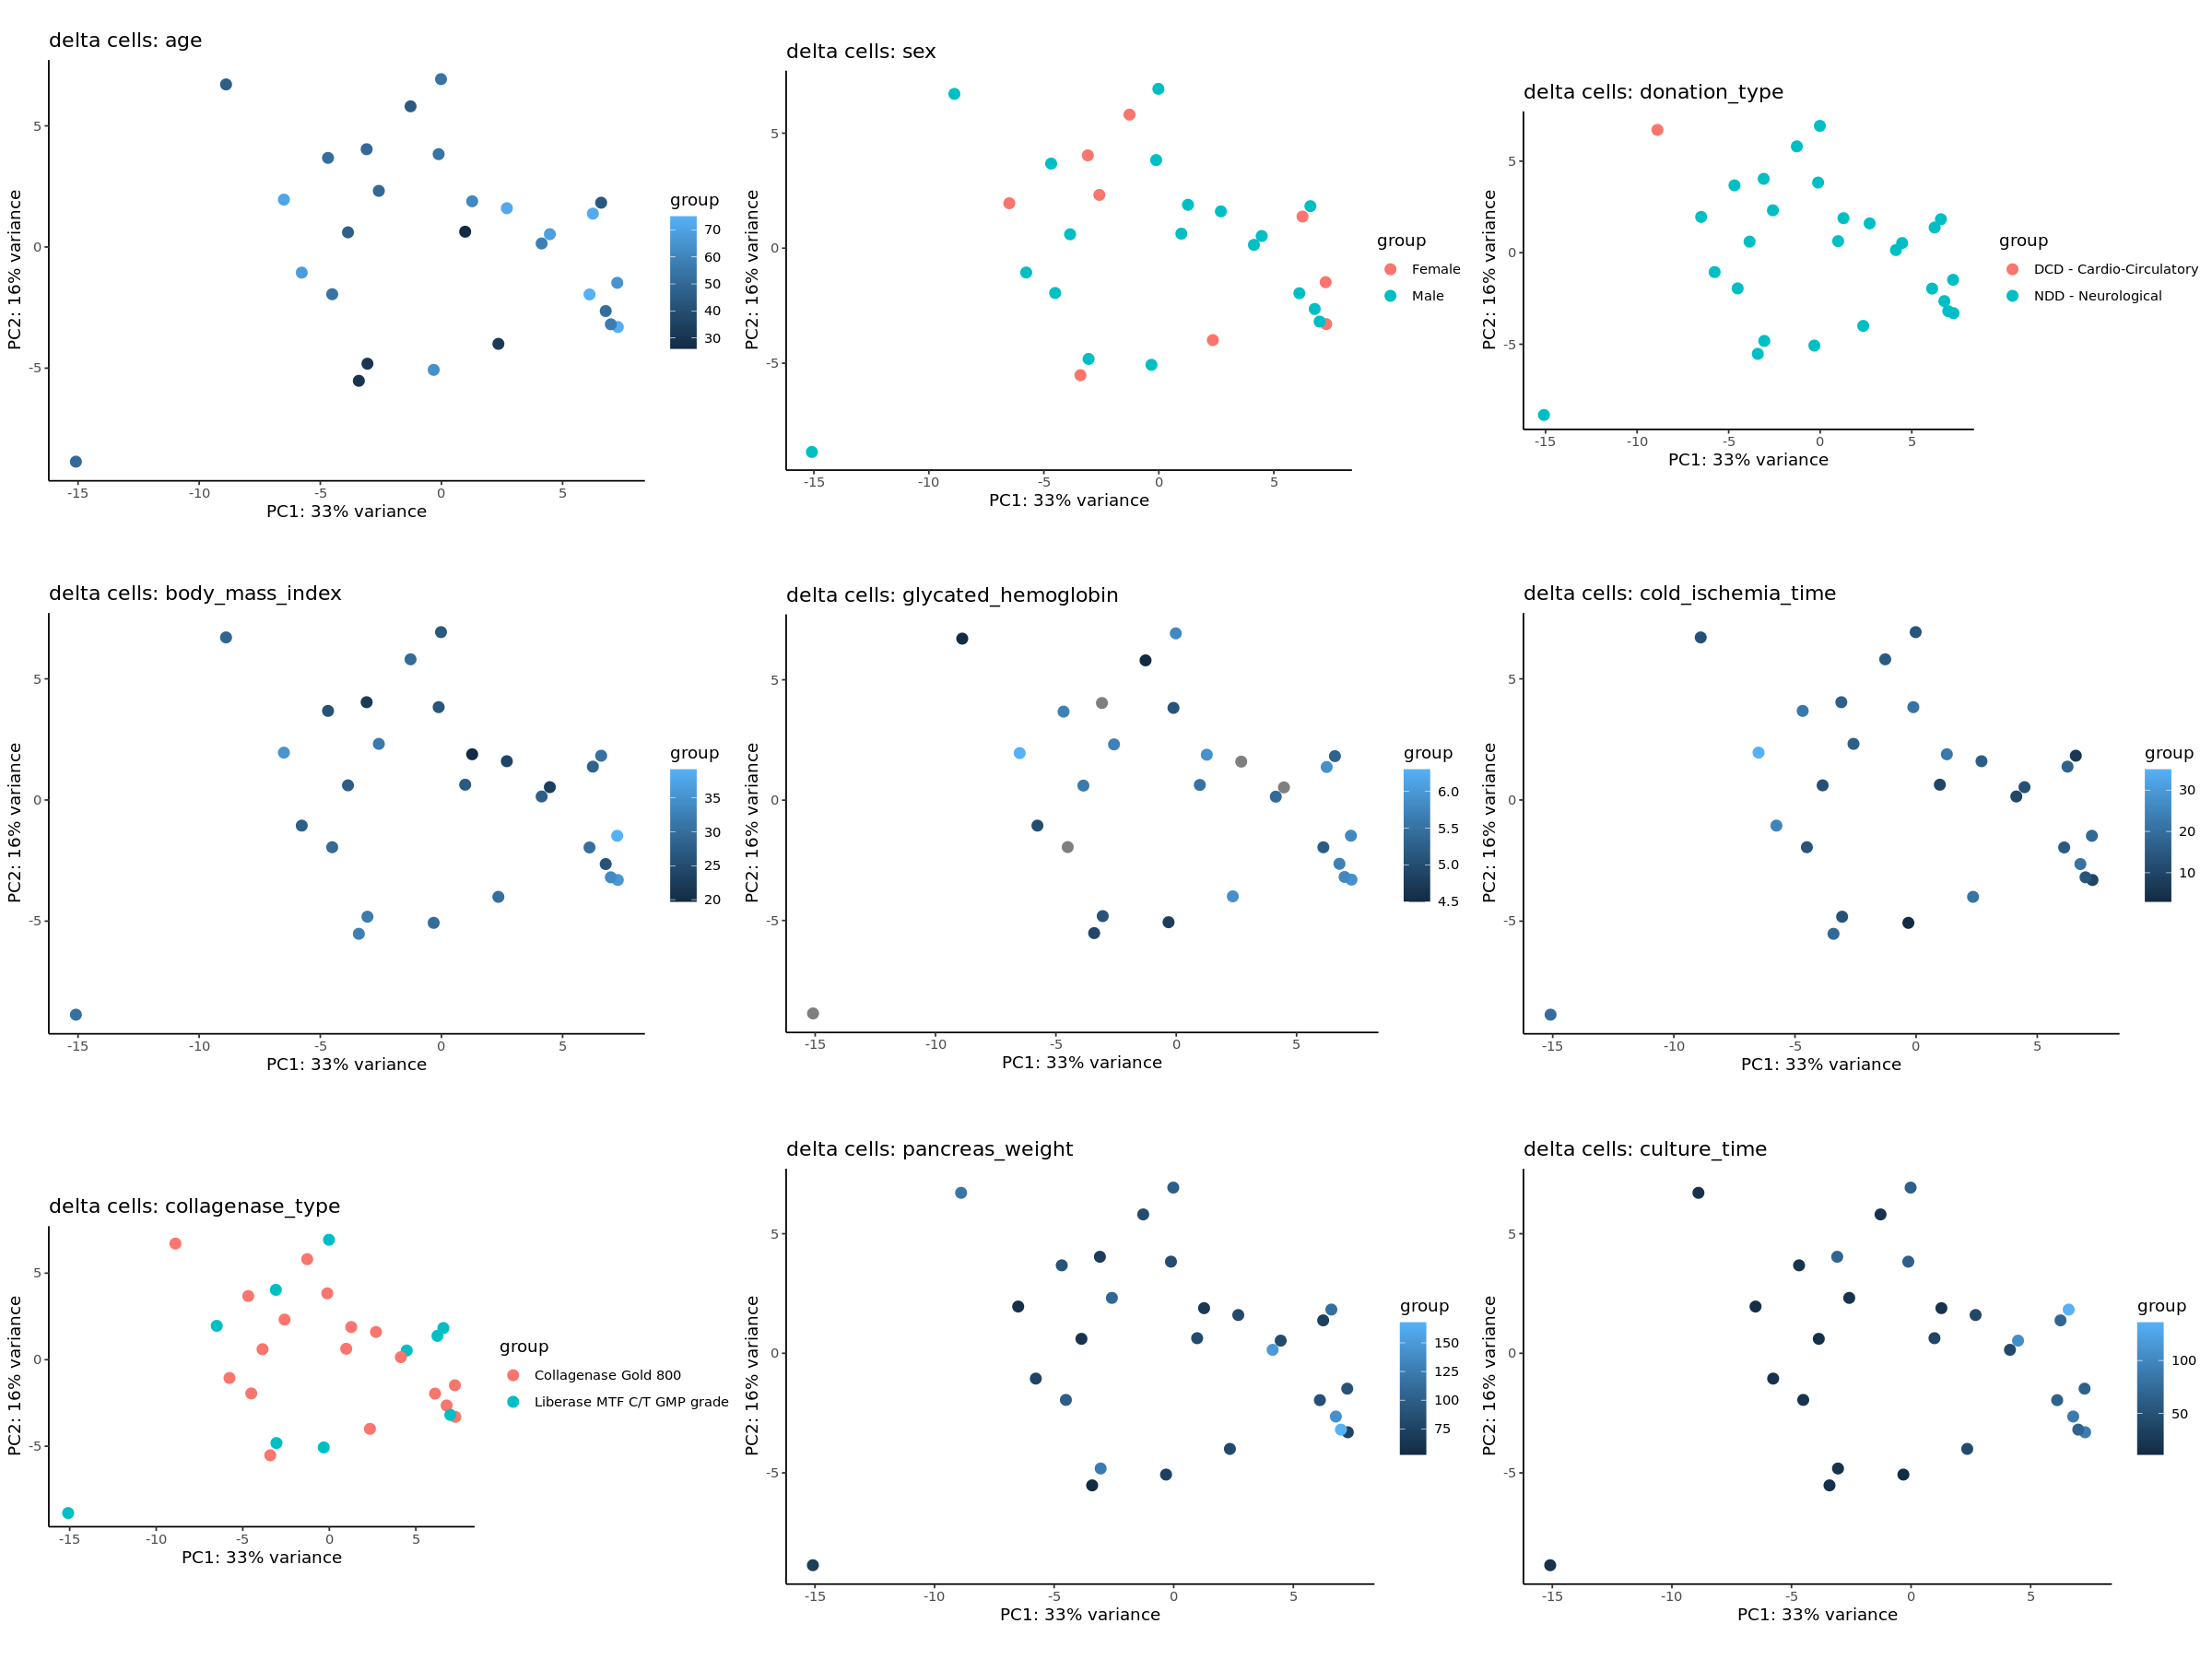

[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



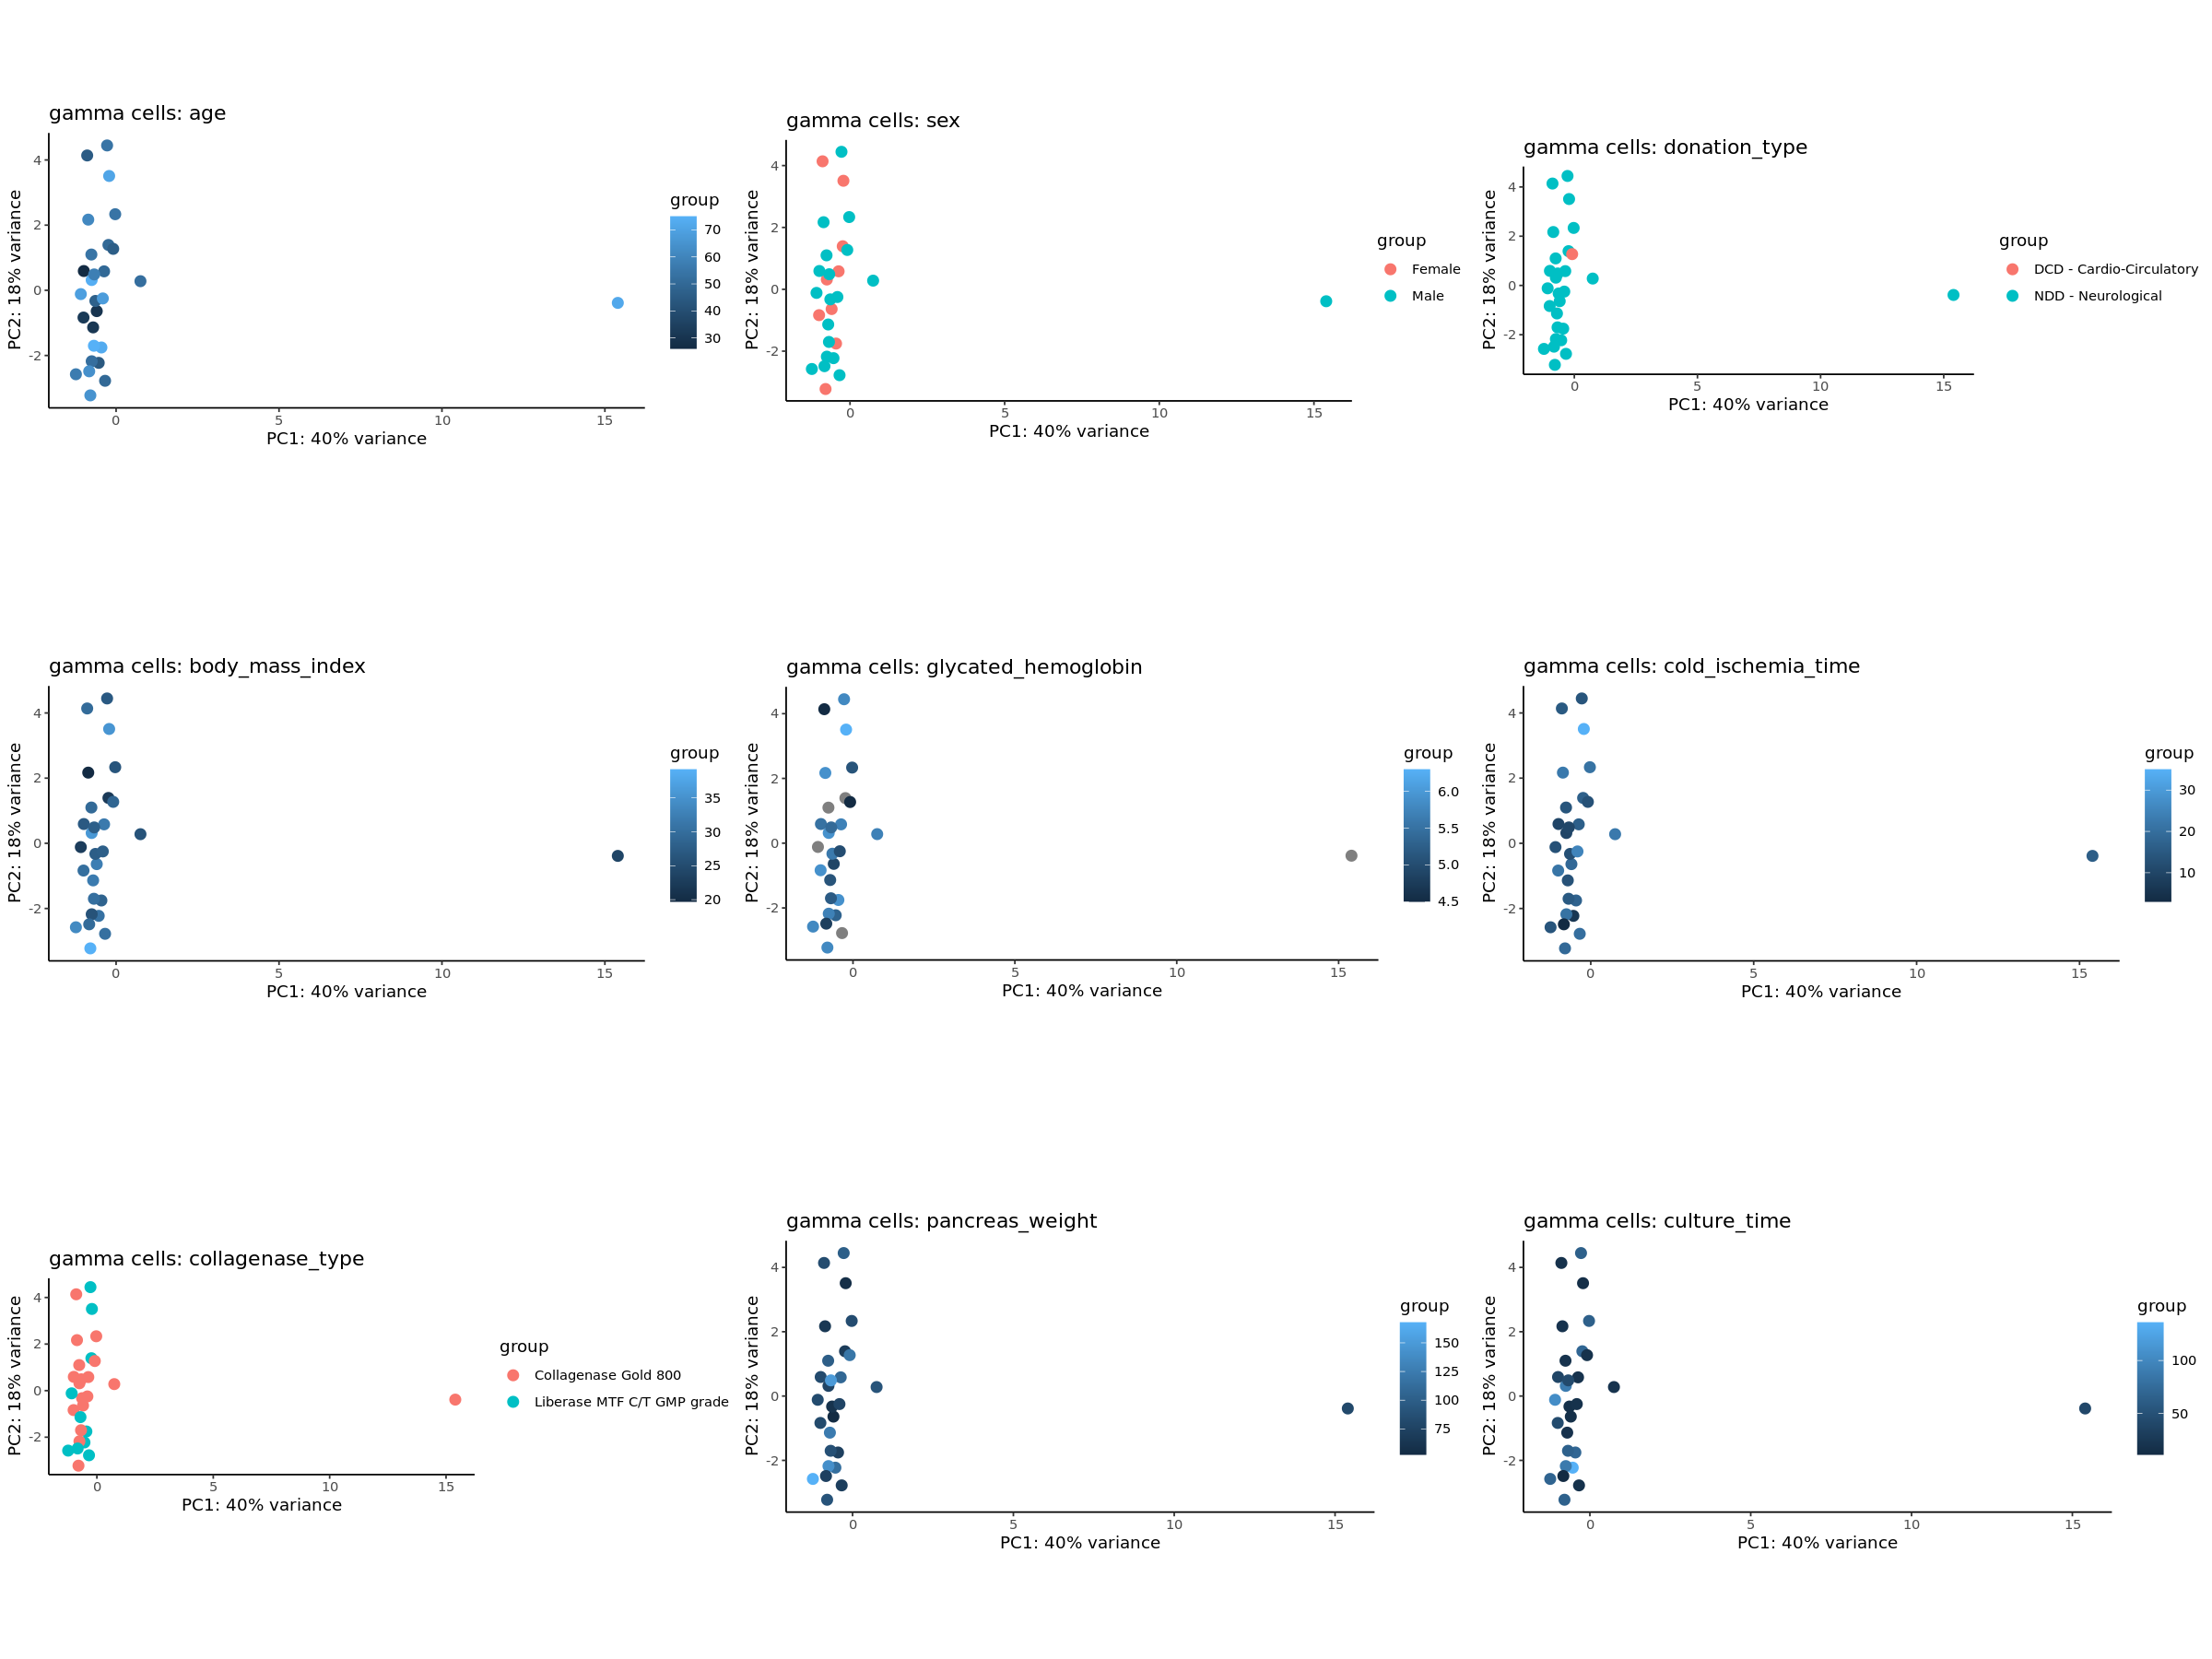

[1] "Using vst normalization!"


Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



[1] "Using vst normalization!"


-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



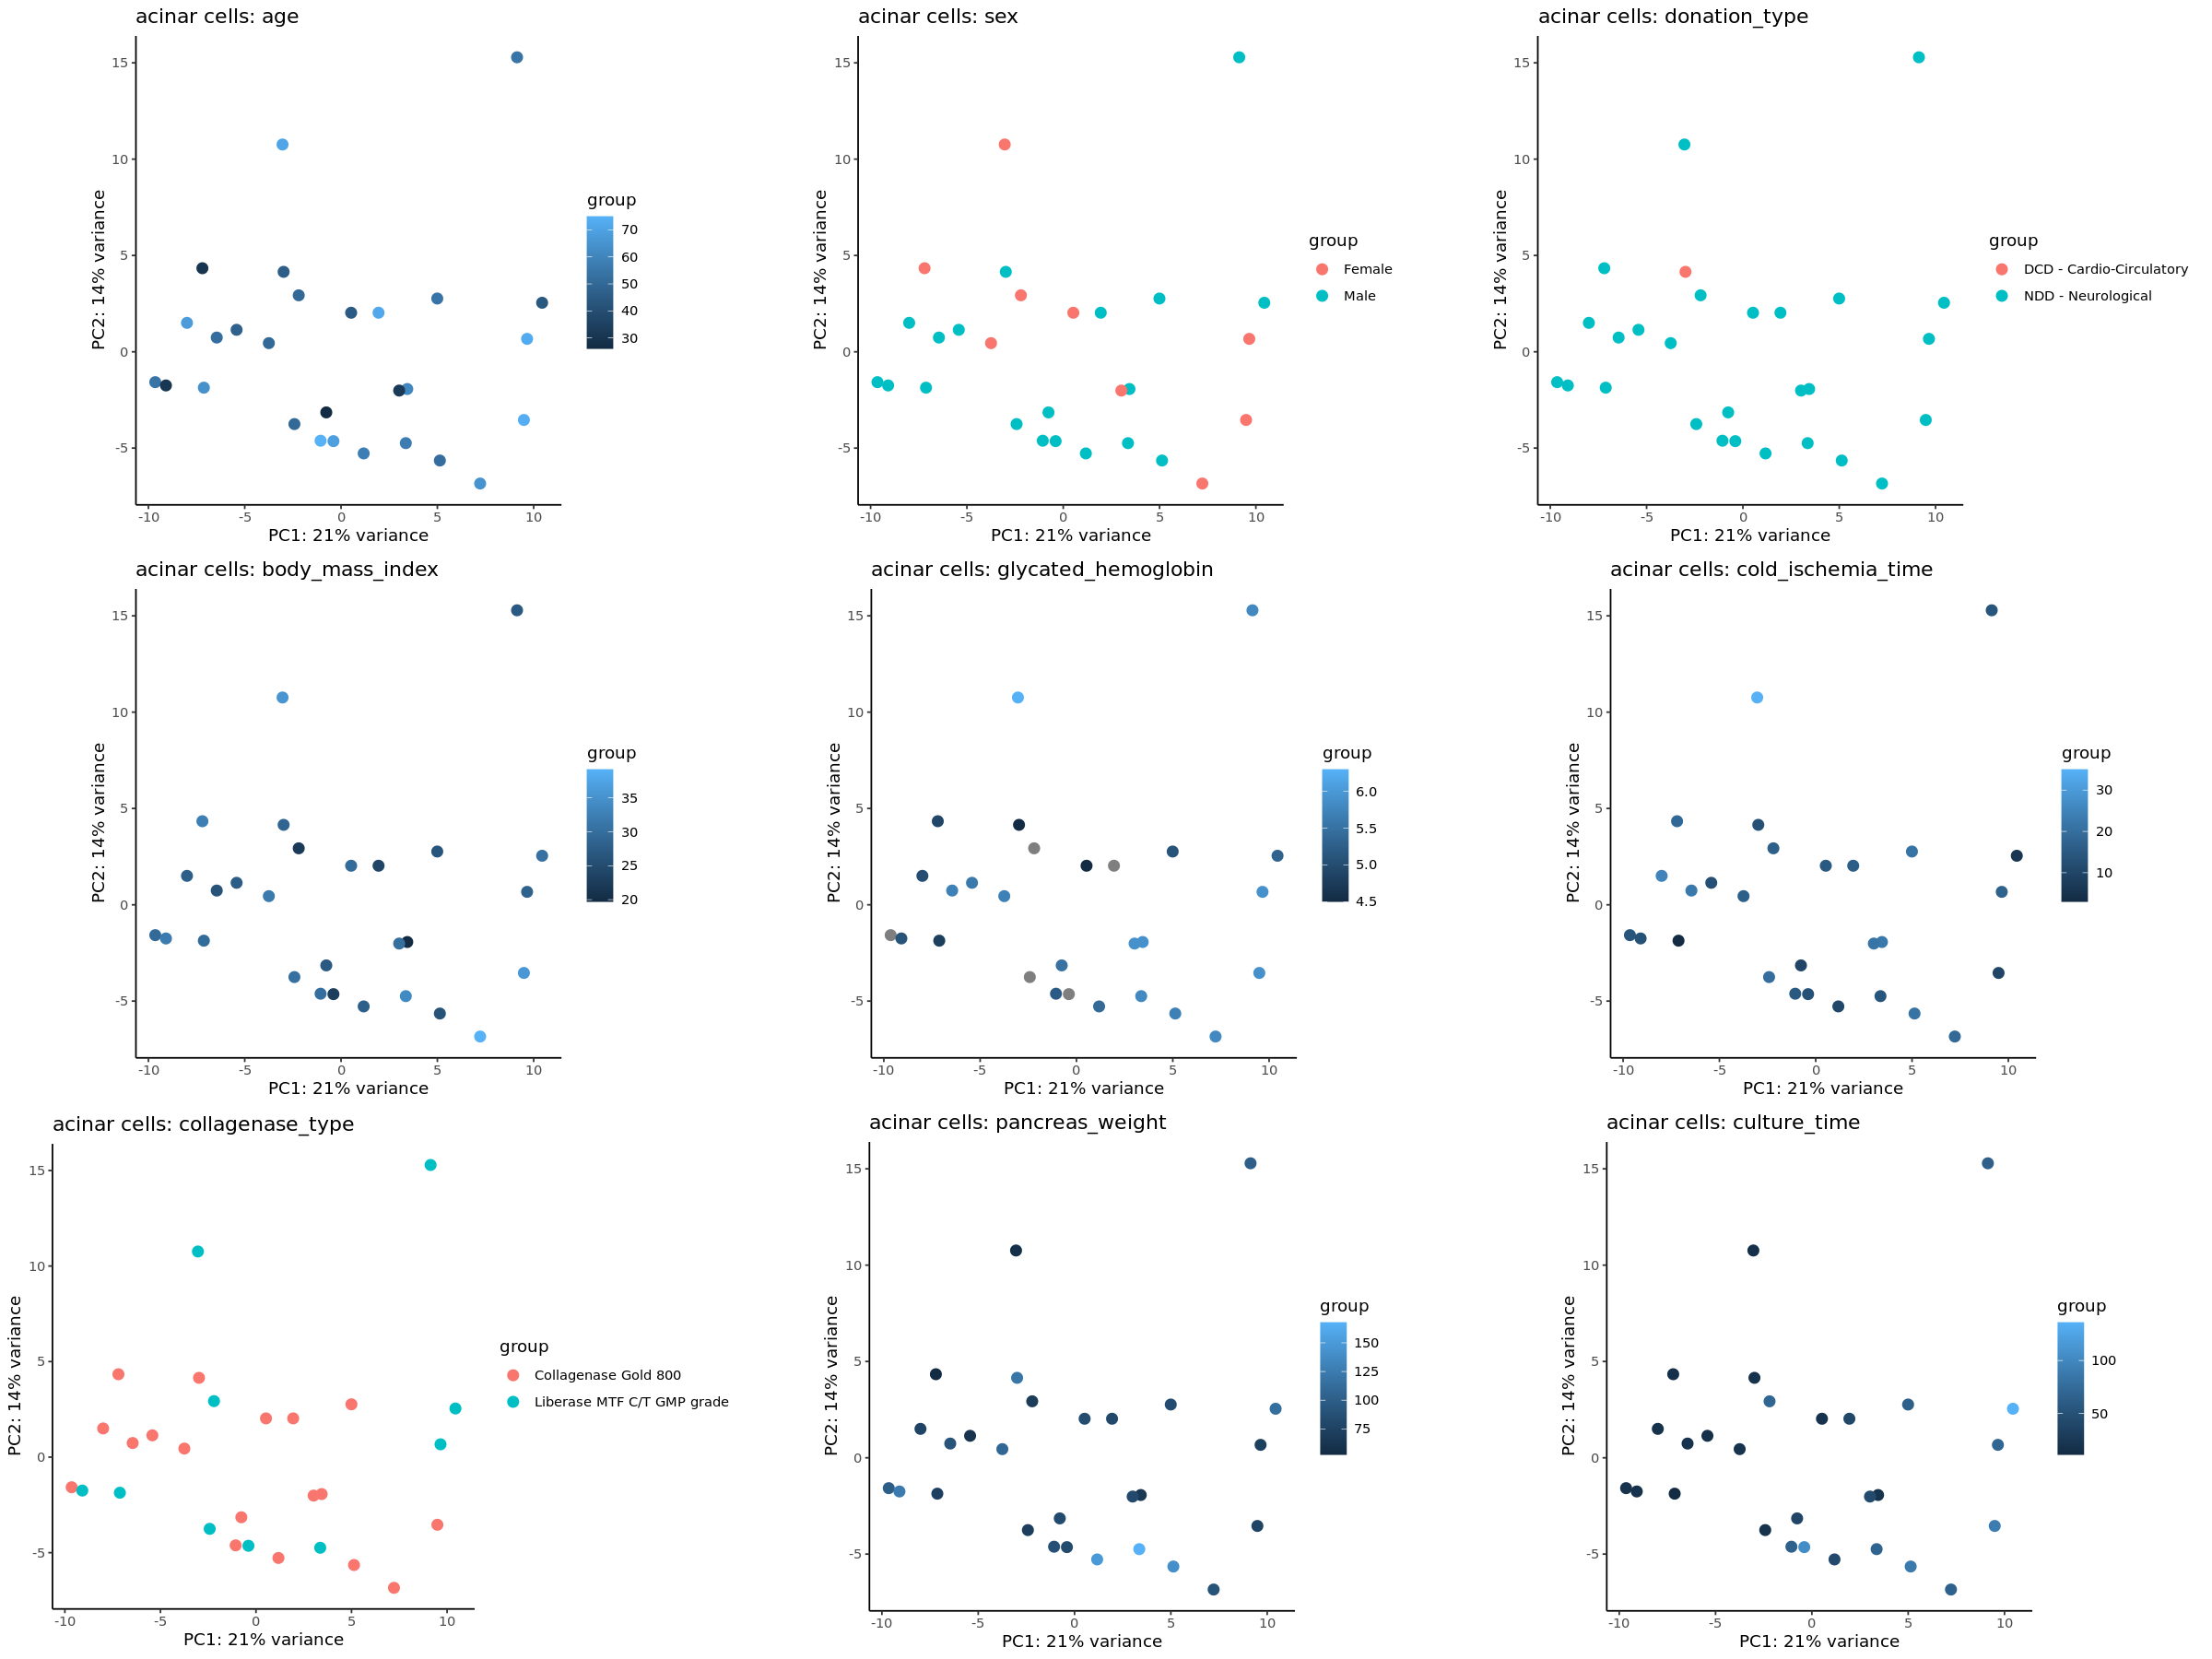

Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



[1] "Using vst normalization!"


-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



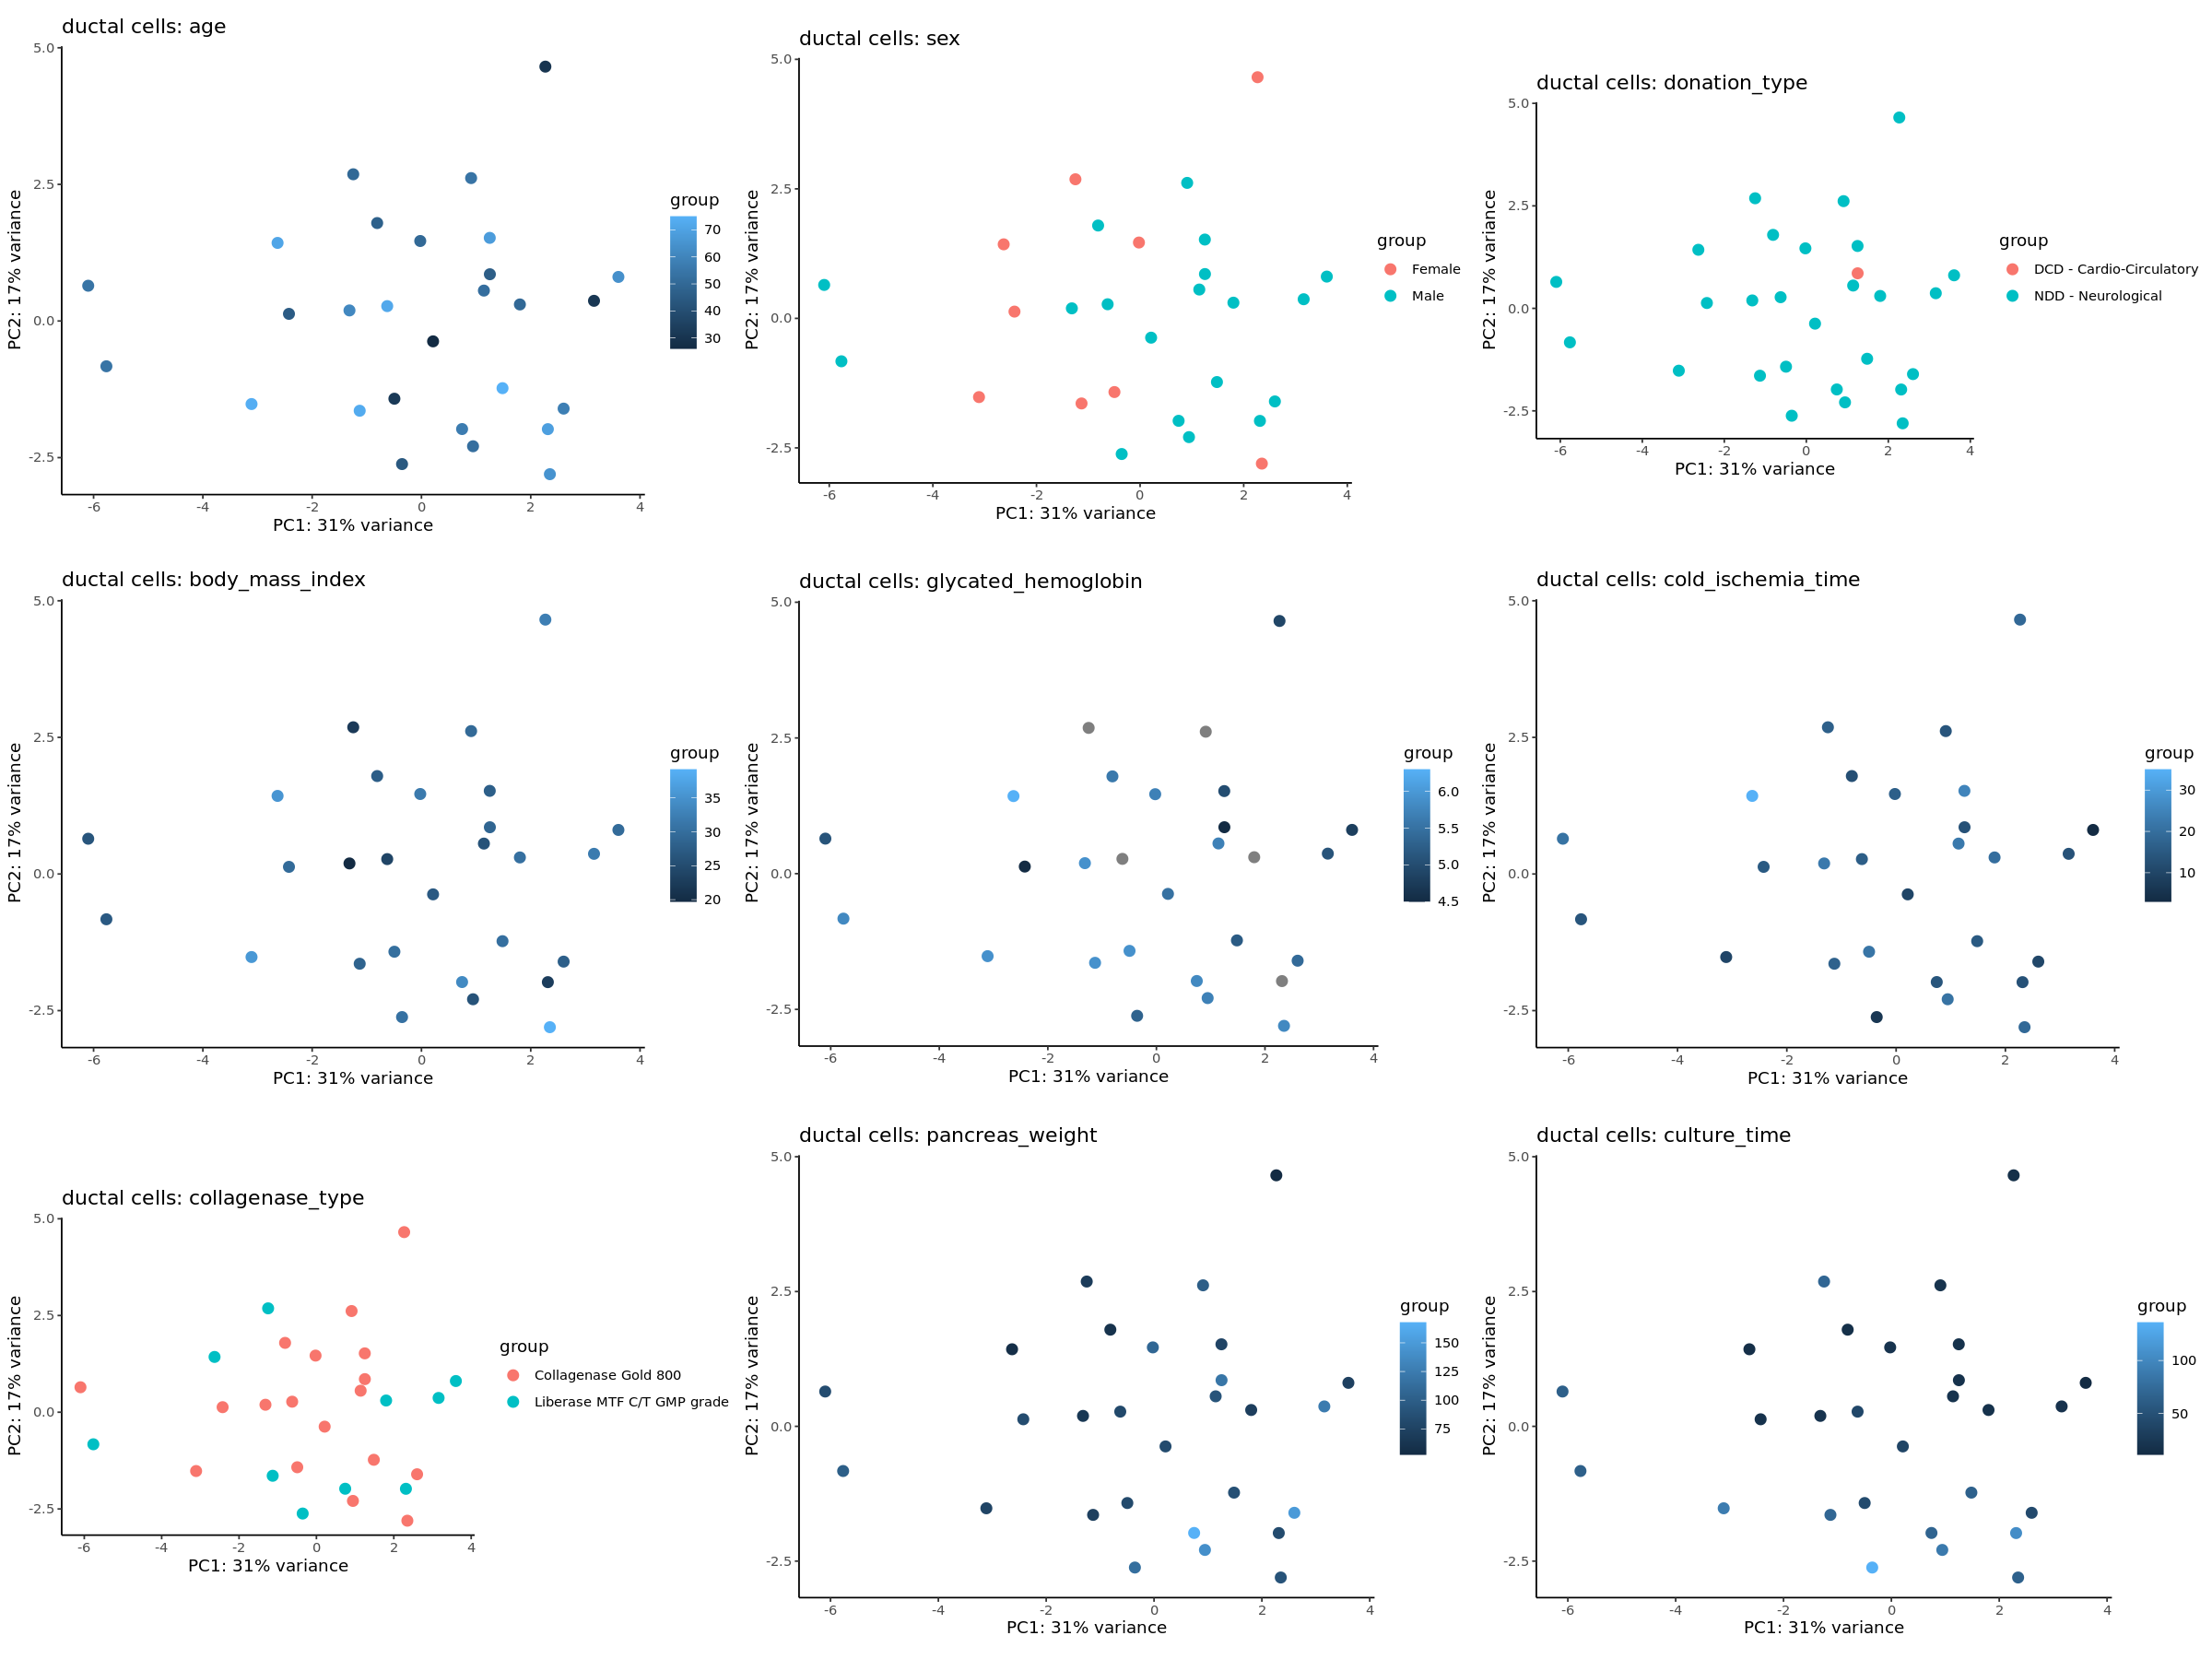

Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



[1] "Using vst normalization!"


-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



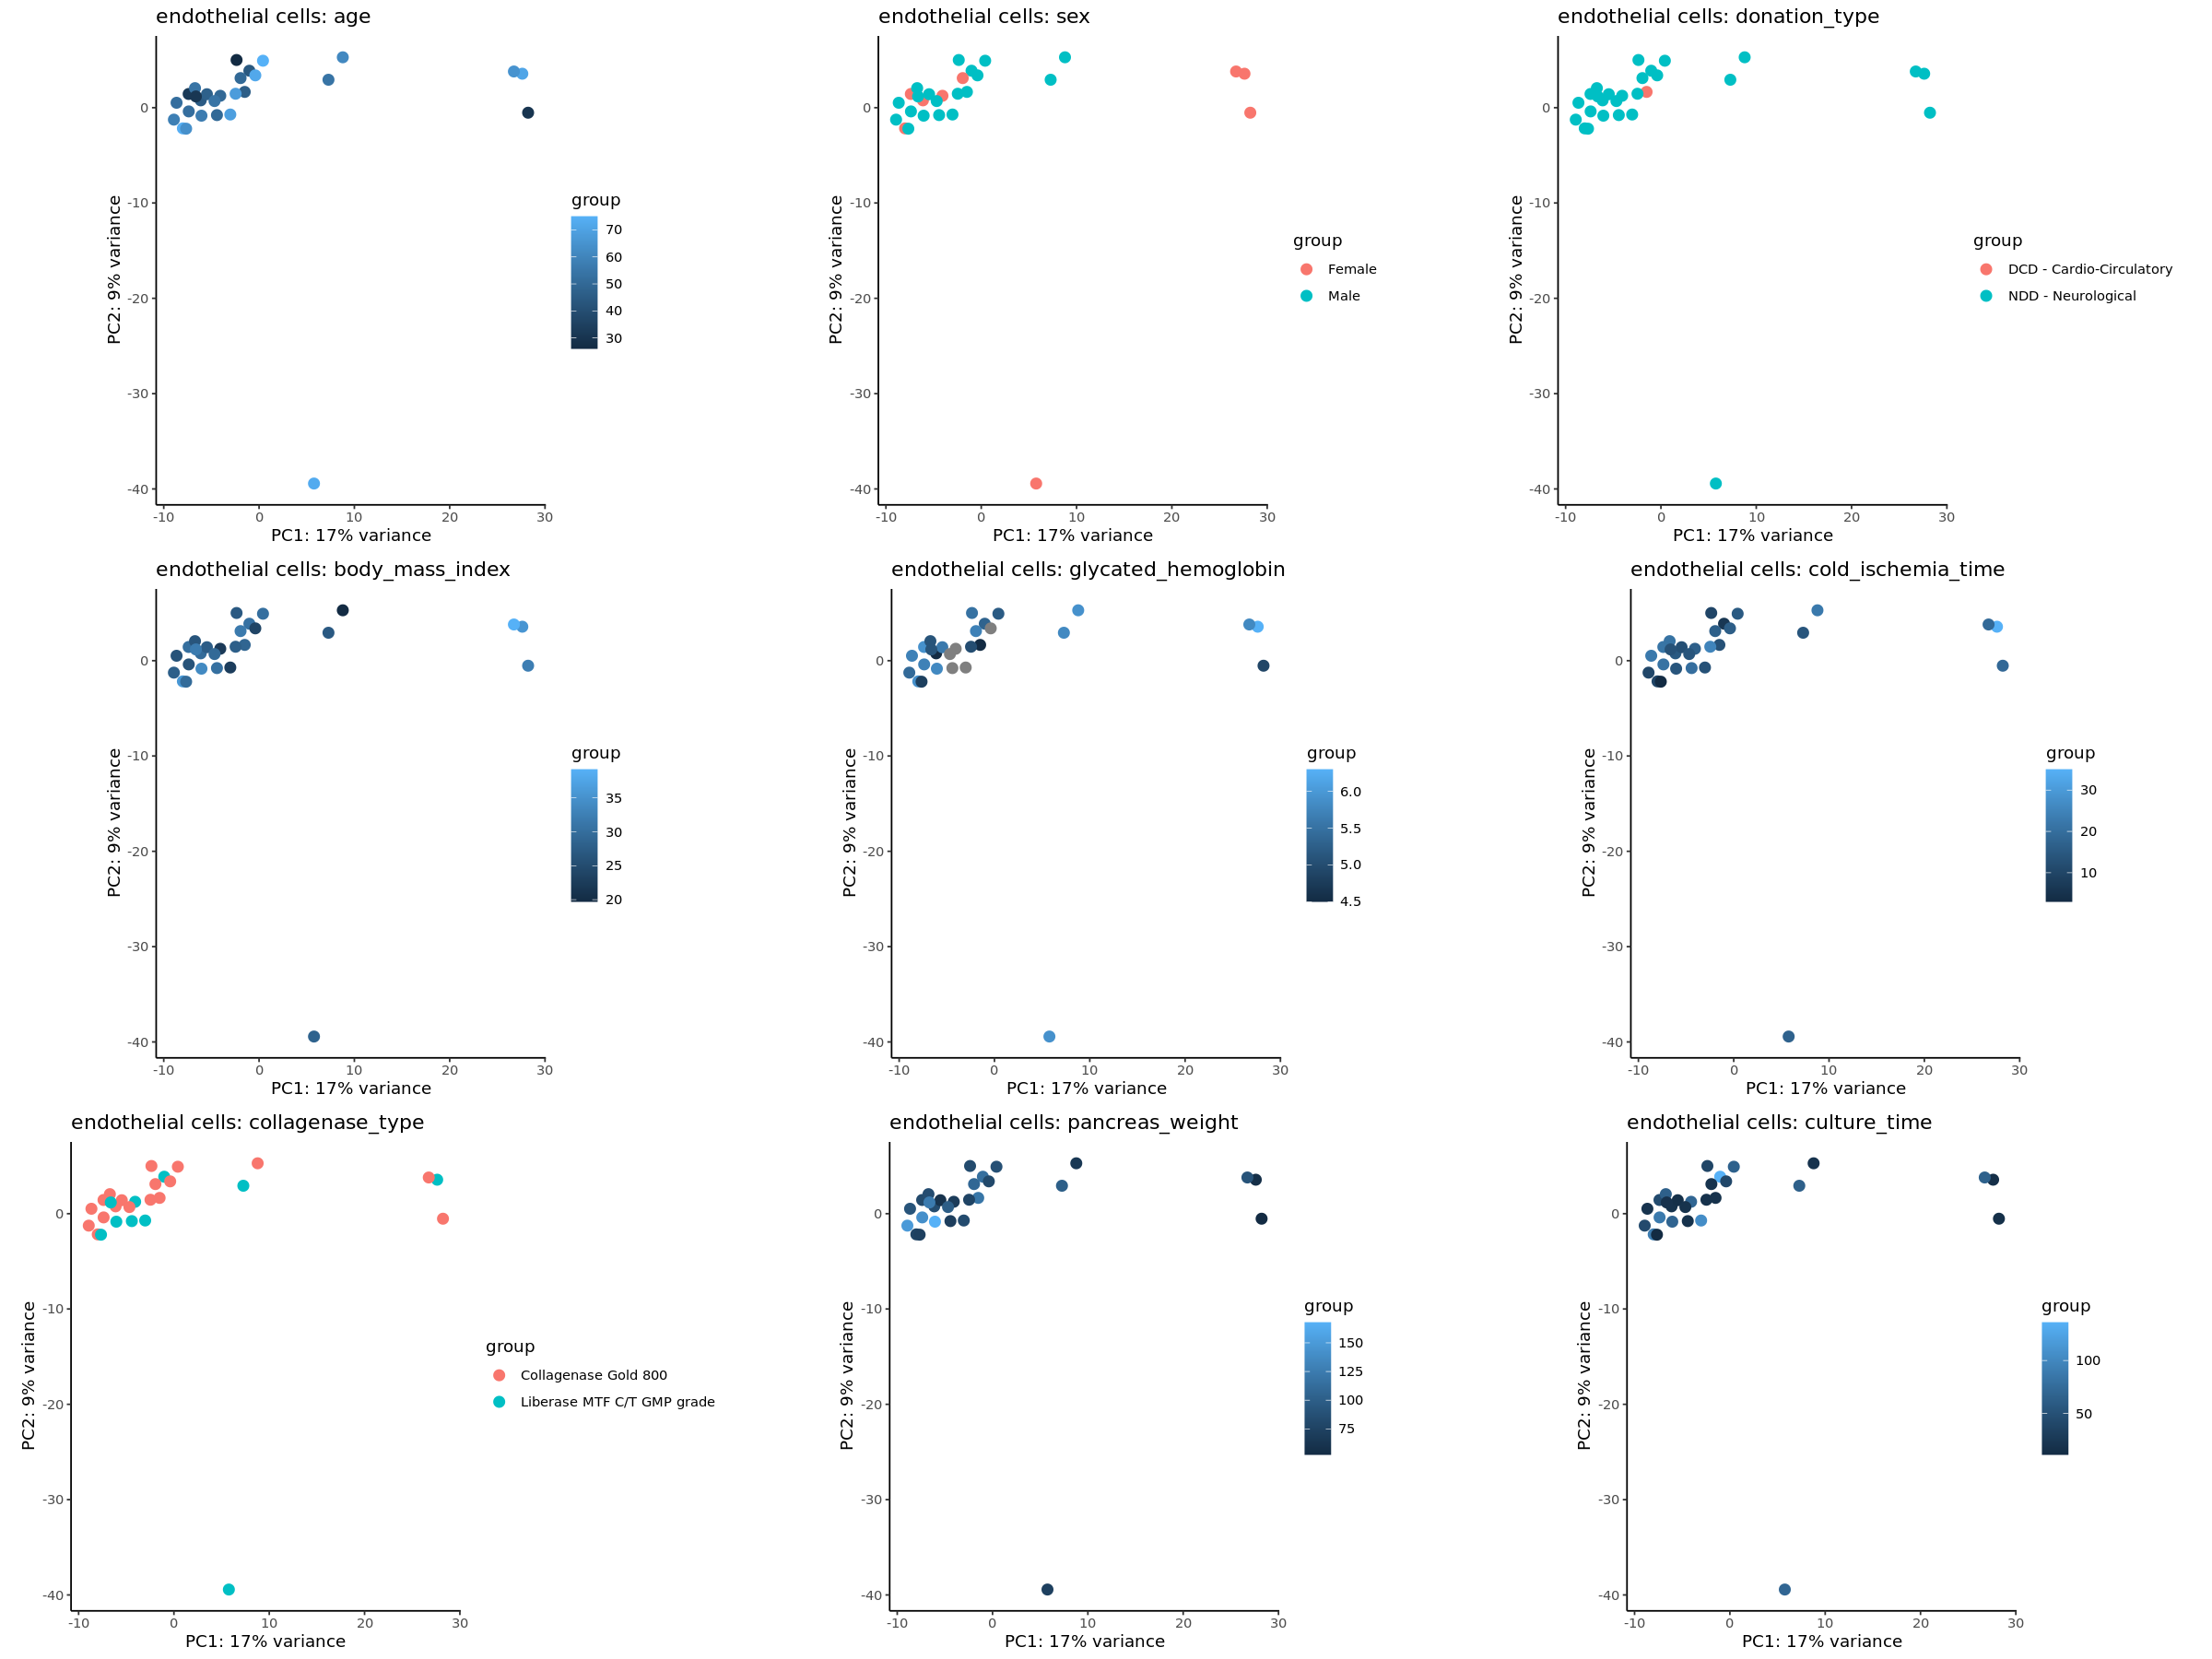

Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”


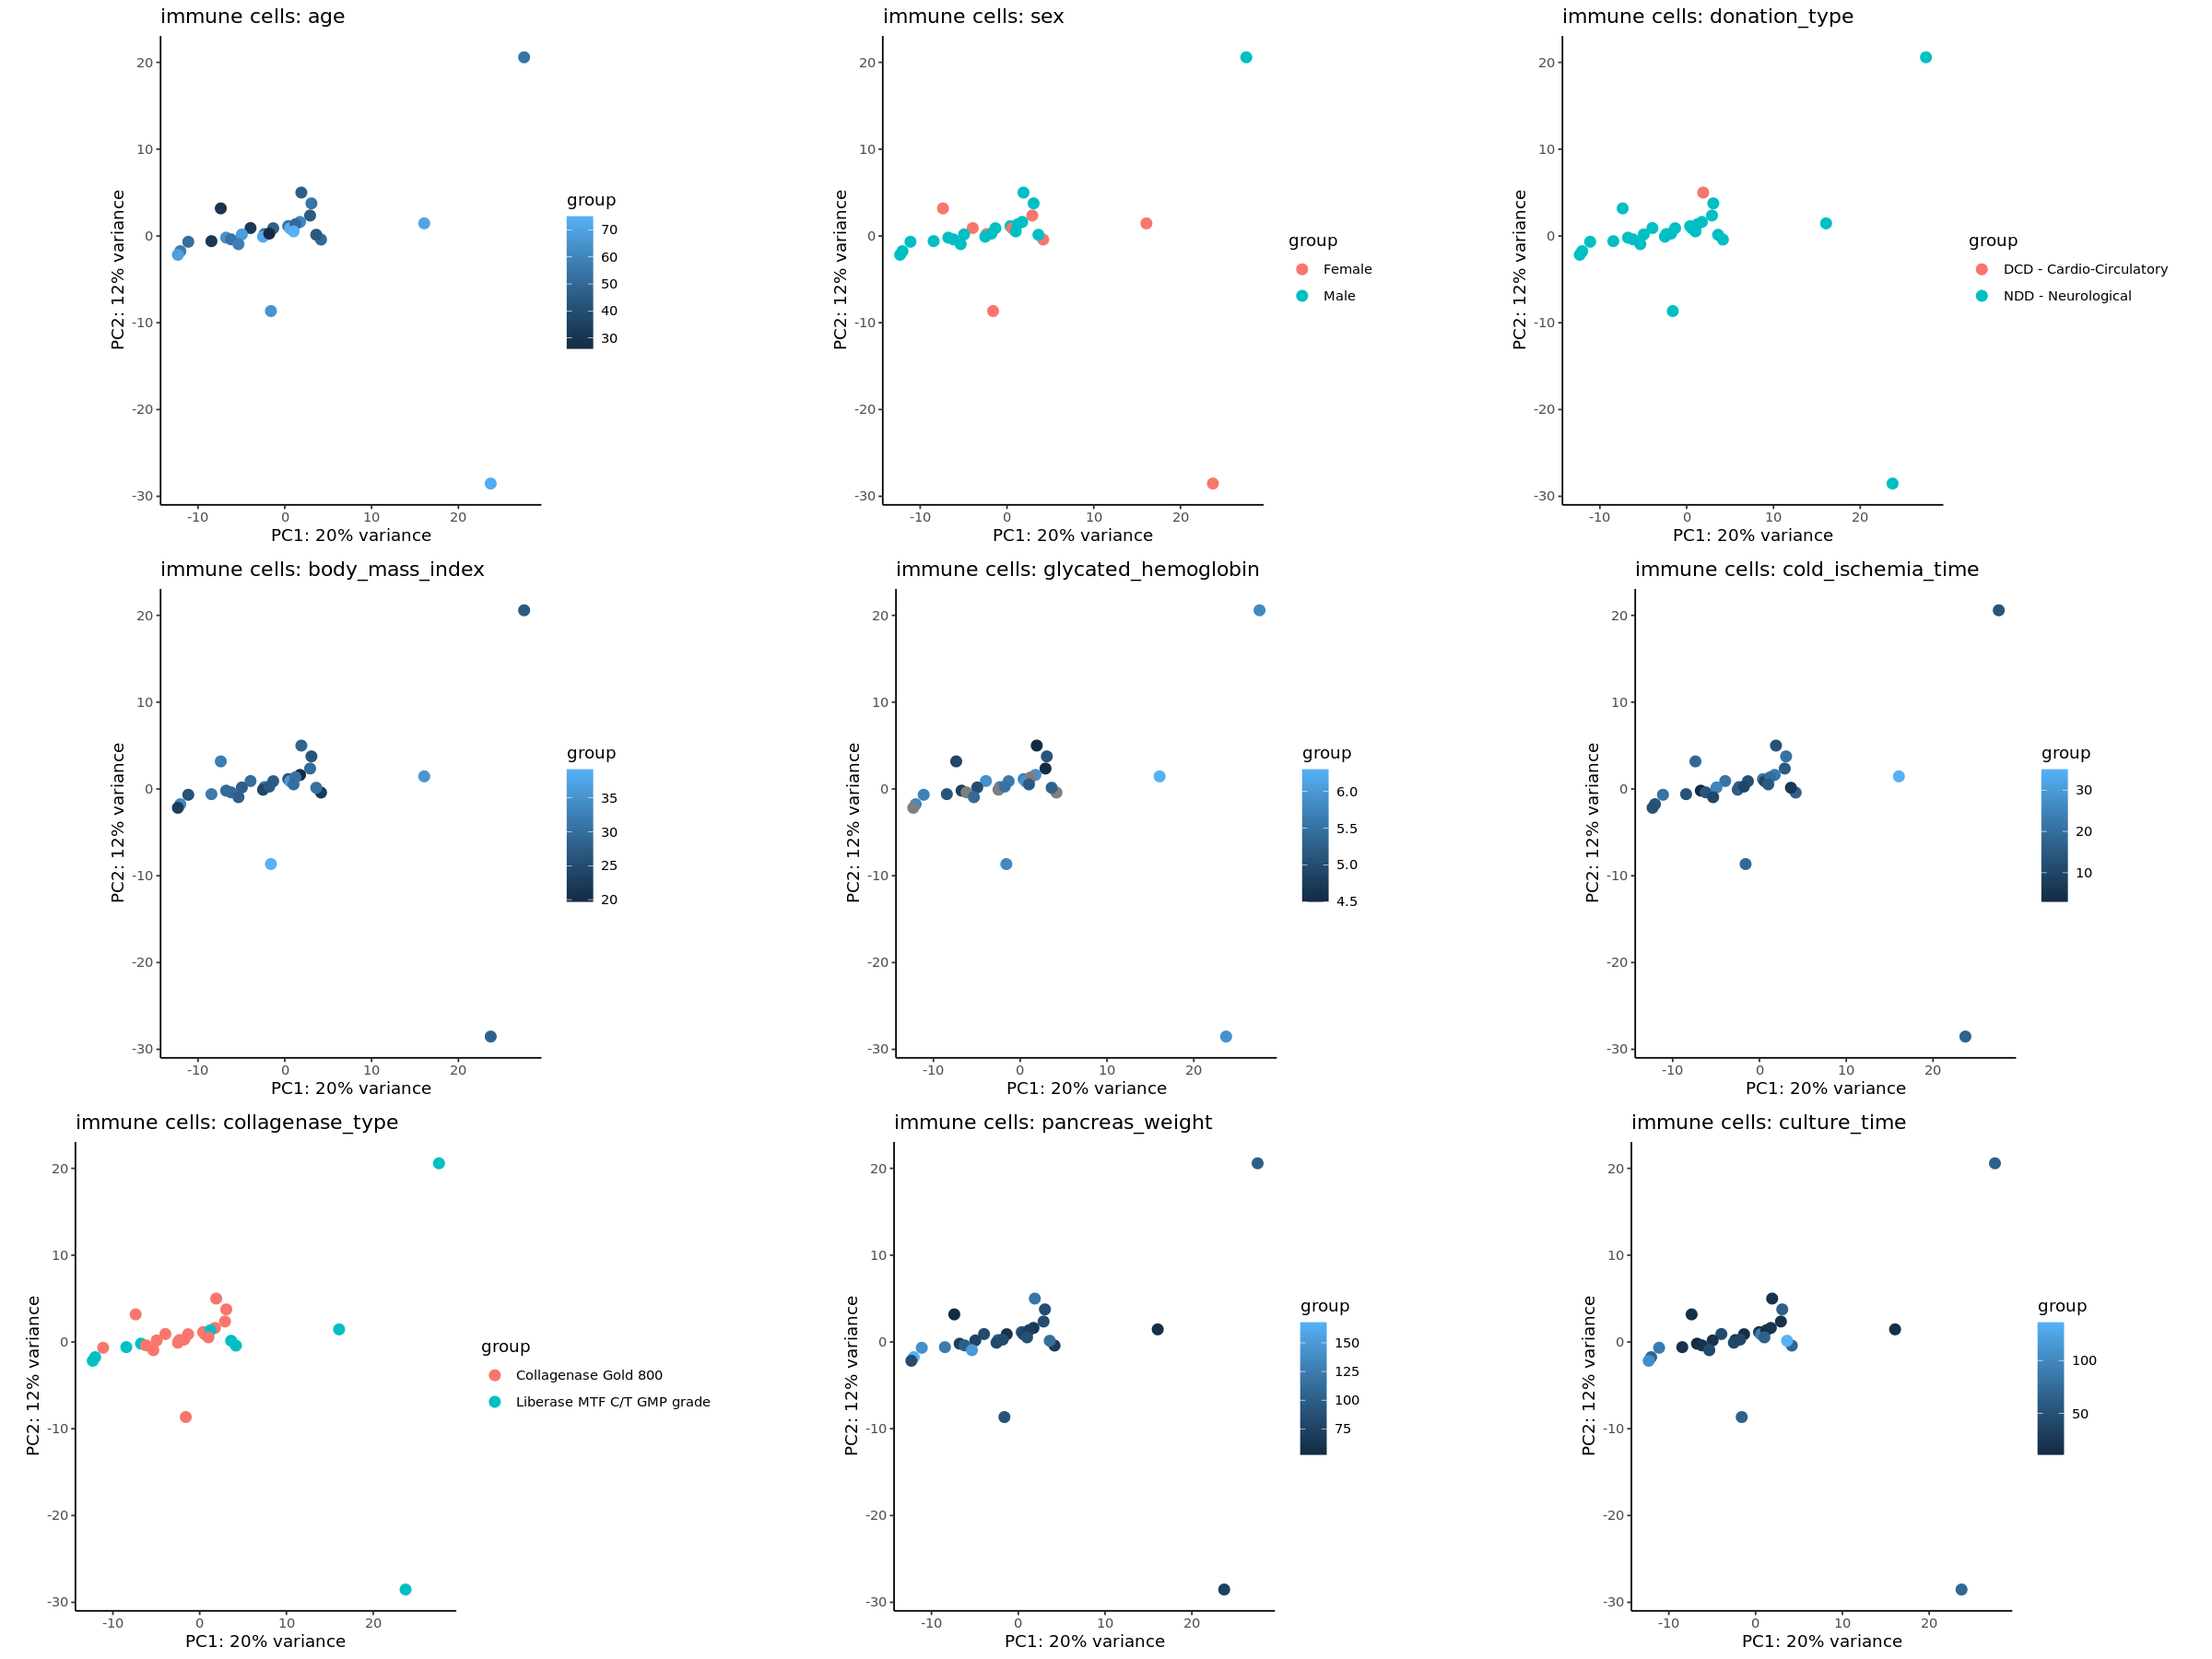

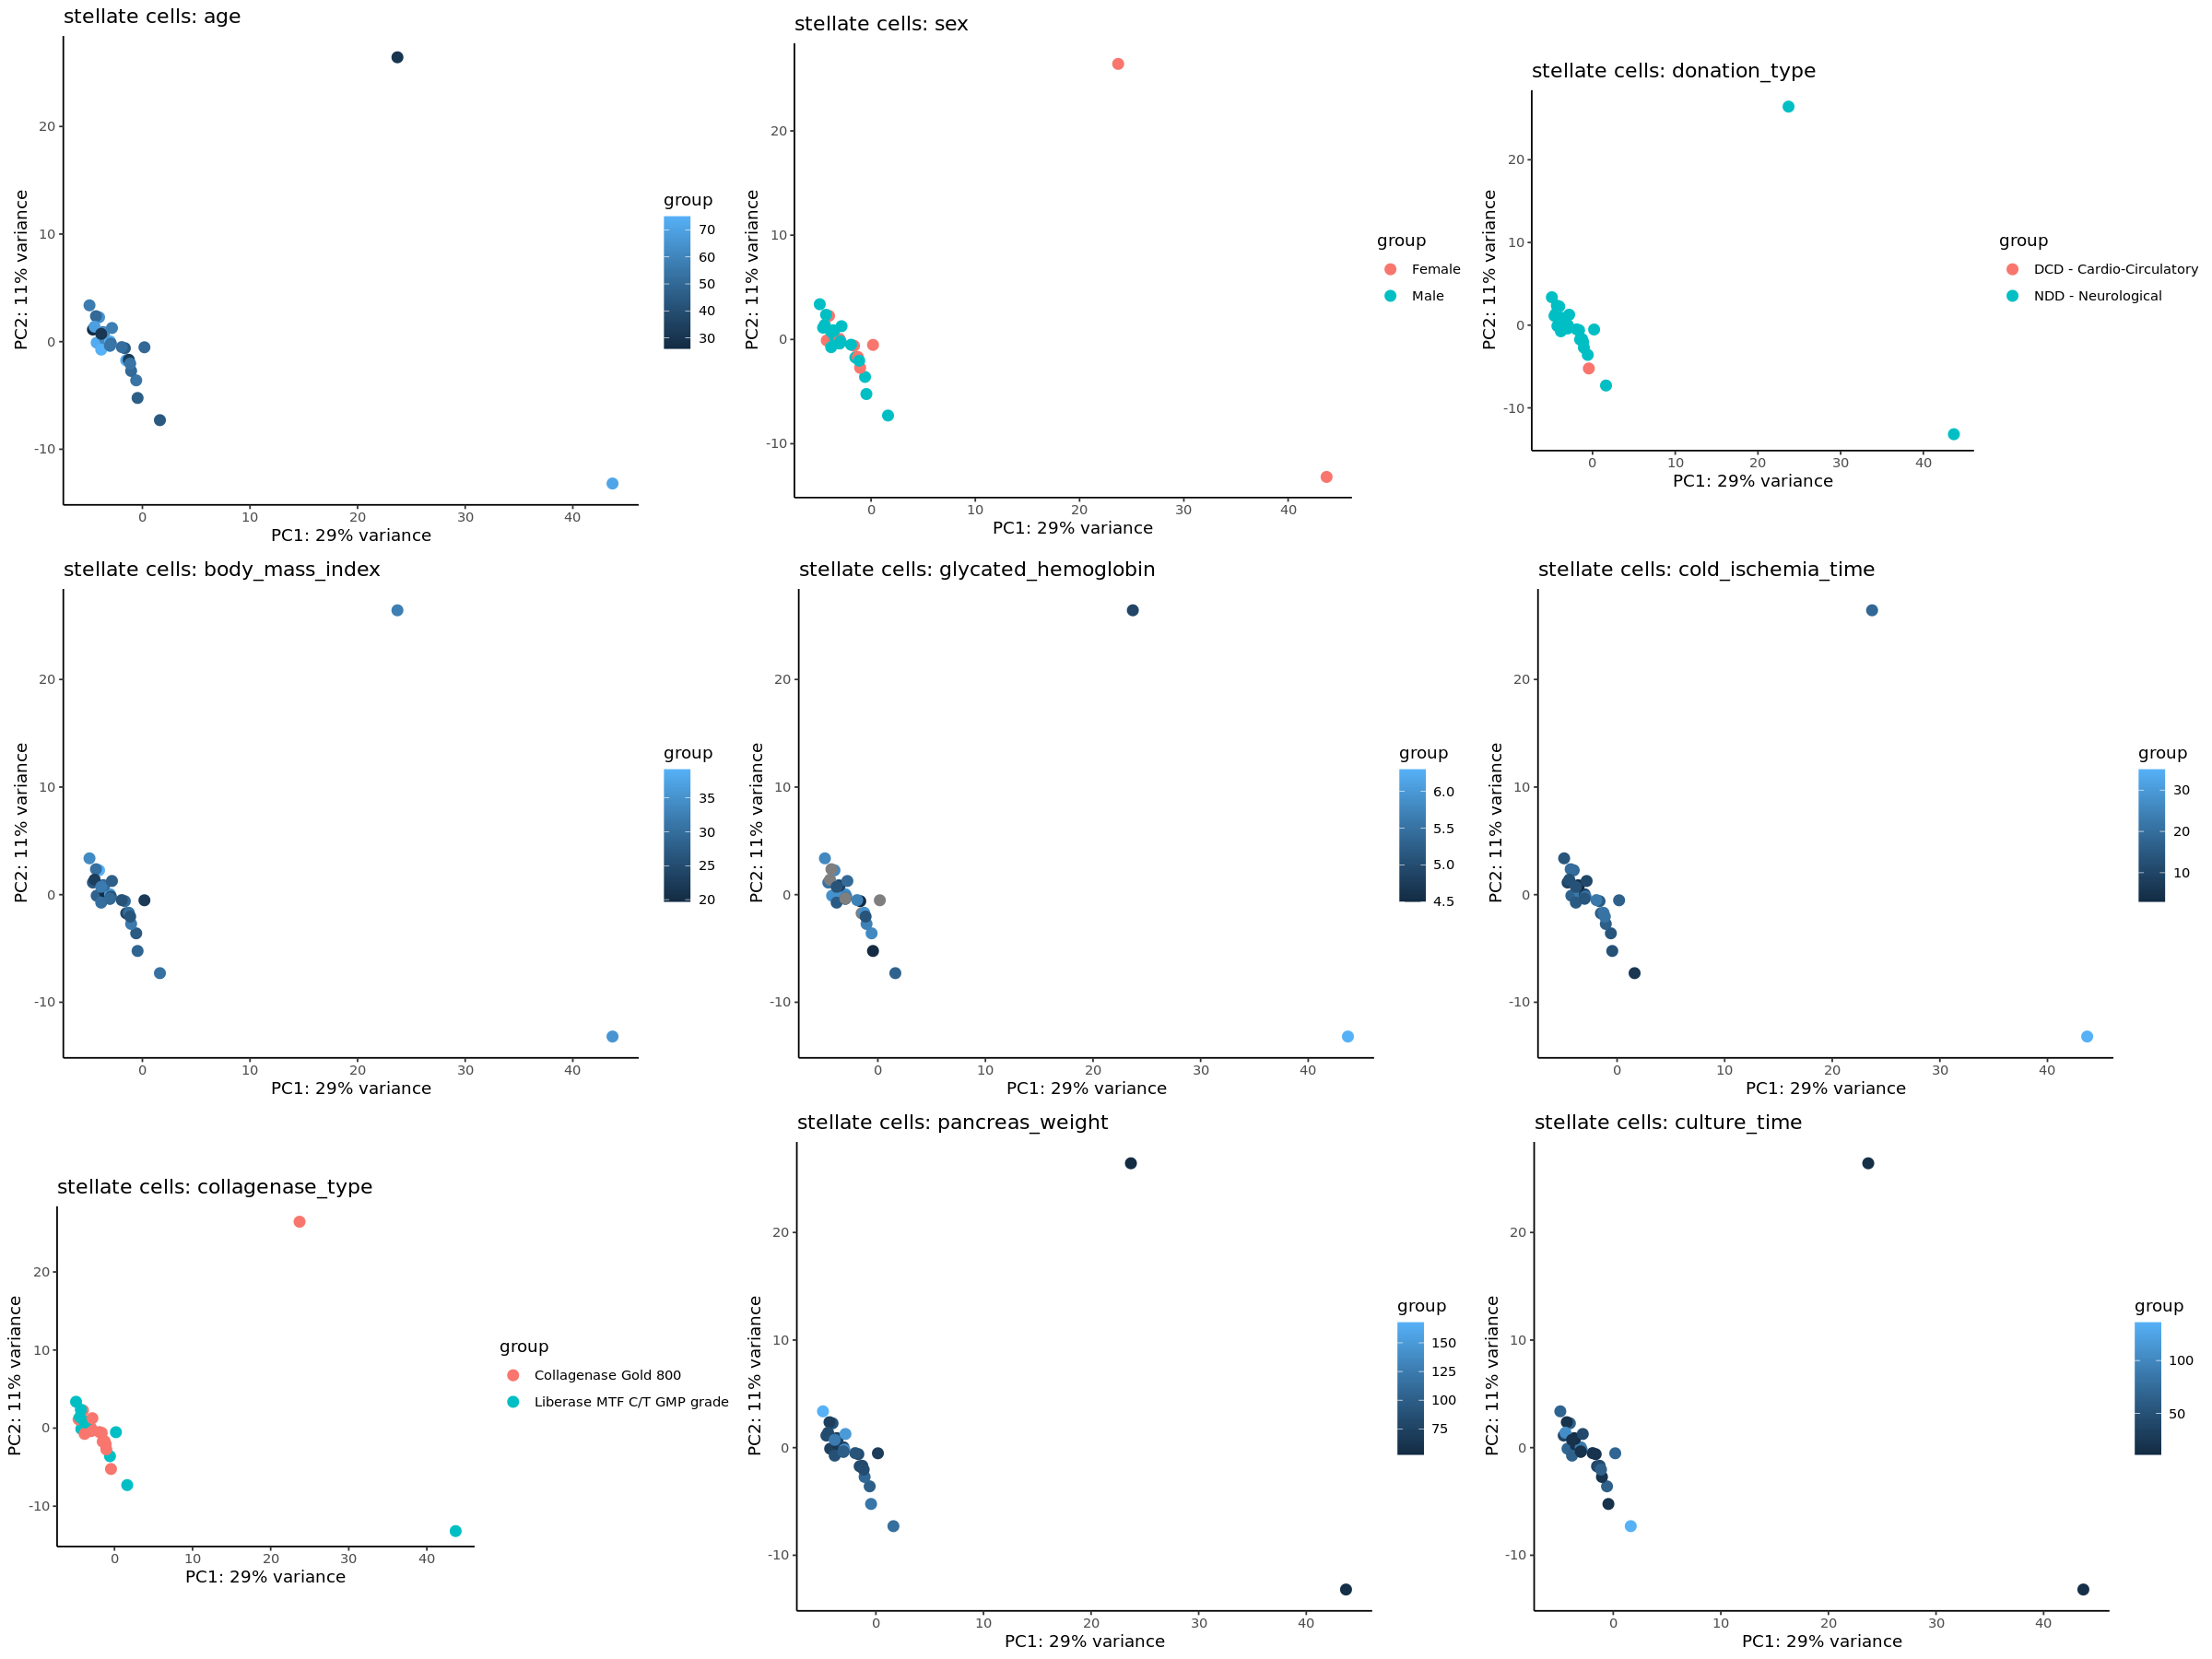

In [151]:
# VST normalized - autosomal peaks
out_dir <- file.path(atac_dir,'embeds')
dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)

for (celltype in celltypes){
    # Get all peaks called in the celltype
    peak.fp <- file.path(peaks_dir,sprintf('%s.merged_peaks.anno.mergedOverlap.bed',celltype)
    ct.peaks <- read.table(peak.fp,sep='\t')
    ct_peaks <- paste(ct.peaks$V1,ct.peaks$V2,ct.peaks$V3,sep="-")
    ct_peaks_auto <- ct_peaks[!grepl('chrX|chrY', ct_peaks)]
        
    # Call function to calculate and save pc embeds
    generate_pc_embeds(celltype, atac_tables, ct_peaks_auto, plot_vars, norm_method = 'vst', 'ATAC', ntop=500, nPCs=20, out_dir)
}

# Test for association with donor covars

In [83]:
### Function to calculate if any samples are clear outliers along a PC embedding
identify_outlier_samples <- function(embed_fp, pc, meta_df, sd_cutoff=3){
    # Read in PC embedding dataframe 
    data <- read.table(embed_fp, sep='\t', header=TRUE)
    data_fin <- head(data,n=28)
    
    # Convert PC embeds to z-scores
    embeds <- data[,pc]
    names(embeds) <- row.names(data)
    zscores <- (embeds - mean(embeds))/sd(embeds)
    
    # Gather outlier samples
    outliers <- names(zscores[abs(zscores) >= sd_cutoff])
    
    # If there are any outliers, adjust data structures to remove them
    if (length(outliers) > 0){
        print(paste0('Outlier samples found for ', pc, ': ', outliers))
    }
    return(outliers)
}

In [187]:
### Function that computes the correlation bt a dataframe of metadata and PC embeddings (avg per donor)
compute_cor <- function(embed_fp, pc, meta_df, cont_covars, outliers){
    # Read in pc embedding dataframe and pull out relevant data
    data <- read.table(embed_fp, sep='\t', header=TRUE)
    data2 <- head(data,n=28)
    
    # If any outliers, remove from data_fin and meta_df
    if (length(outliers) > 0){
        data_fin <- data2[!row.names(data2) %in% outliers,]
        meta_fin <- meta_df[!row.names(meta_df) %in% outliers,]
    } else {
        data_fin <- data2 
        meta_fin <- meta_df
    }
    
    # Test for correlation of pc with cont_covars
    tests <- lapply(meta_fin[,cont_covars], function(y) cor.test(unlist(data_fin[,pc]), y, method="pearson"))
    
    # Extract useful results into 2 df columns
    tests2 <- unlist(tests)
    results <- data.frame(stat = tests2[grepl('estimate',names(tests2))], pvalue = tests2[grepl('p.value',names(tests2))])
    row.names(results) <- str_split_fixed(row.names(results), '.estimate', 2)[,1]
    results_fin <- results %>% mutate_at(1:2, as.numeric)
    return(results_fin)    
}
                    
                    
### Function that performs an anova test for categorical variables effect on PC embeddings
compute_anova <- function(embed_fp, pc, meta_df, covars, outliers){
    # Read in composite dataframe and modify relevant columns
    data_pre <- read.table(embed_fp, sep='\t')
    data_pre$library <- str_split_fixed(row.names(data_pre), '_', 2)[,1]
    data <- data_pre[seq(28),c(pc,'library')]
    colnames(data)[1] <- 'pc'

    # If any outliers, remove 
    if (length(outliers) > 0){
        data_fin <- data[!row.names(data) %in% outliers,]
        meta_fin <- meta_df[!row.names(meta_df) %in% outliers,]
    } else {
        data_fin <- data
        meta_fin <- meta_df
    }

    # Prep data and run anova test
    tests <- list()
    for (covar in covars){
        # Add covar data to the PC embeddings
        categ_map <- meta_fin[,covar]
        names(categ_map) <- meta_fin$library
        data_fin$covar <- plyr::mapvalues(data_fin$library, from=names(categ_map), to=categ_map, warn_missing=FALSE)
        
        # Make sure we still have two groups of samples
        if (dim(table(data_fin$covar)) > 1){
            # Run one way anova on covar
            one.way <- aov(pc ~ covar, data=data_fin)
            tests[[covar]] <- summary(one.way)
        } else {
            # Return filler data
            print(paste('Anova failed for', pc, covar))
            filler_aov <- c('F value1'=NA, 'Pr(>F)1'=1)
            tests[[covar]] <- filler_aov
        }
    }
    
    # Extract useful results into 2 df columns
    tests2 <- unlist(tests)
    results <- data.frame(stat = tests2[grepl('F value1',names(tests2))], pvalue = tests2[grepl('Pr\\(>F\\)1',names(tests2))])
    row.names(results) <- covars
    return(results)
}

In [167]:
### Overall wrapper function for tests
comparison_wrapper <- function(celltype, indir, assay, meta_df, categ_covars, outdir){
    print(celltype)
    
    # Organize metadata columns
    meta_cols <- colnames(meta_df)
    cont_covars <- colnames(tibble(meta_df) %>% select_if(~!is.character(.)))
    
    # Get file path for cell type sample pseudobulk PC embeddings
    fp <- file.path(indir, sprintf('%s_%s_sample_pseudobulk_PC_embeds.txt',celltype,assay))
    
    # Test for significant relationship between each covar in meta_cols and each PC
    # First, remove outlier samples from the test and dataframes
    corr_results <- list()
    anova_results <- list()
    pcs <- paste0('PC', seq(20))
    for (pc in pcs){
        # First test for outlier samples
        outliers <- identify_outlier_samples(fp, pc, meta_df)
        
        # Then perform cor.test and anova (passing list of outliers)
        corr_results[[pc]] <- compute_cor(fp, pc, meta_df, cont_covars, outliers)
        anova_results[[pc]] <- compute_anova(fp, pc, meta_df, categ_covars, outliers)
    }
    # Organize results into one dataframe
    corr_df <- do.call(cbind, corr_results)
    anova_df <- do.call(cbind, anova_results)
    results <- rbind(corr_df, anova_df)
    
    # Bonferroni correct by PC
    qvalues_list <- list()
    for (pc in pcs){
        pvalues <- results[,paste0(pc,'.pvalue')]
        qvalues <- p.adjust(pvalues, method='bonferroni')
        qvalues_list[[pc]] <- qvalues
    }
    qvalues_df <- as.data.frame(qvalues_list)
    colnames(qvalues_df) <- paste0(pcs, '.qvalue')
    fin_results <- cbind(results, qvalues_df)
    column_order <- paste(rep(pcs, each=3), rep(c('stat','pvalue','qvalue'), length(pcs)), sep='.')
    fin_results2 <- fin_results[,column_order]
    
    # Output results to file
    out_fp <- file.path(outdir, sprintf('%s_%s_assoc_covar_results.txt', celltype, assay))
    write.table(fin_results2, out_fp, sep='\t', quote=FALSE)
}

In [ ]:
#manually set which categorical covars to test
categ_covars <- c('sex','donation_type','collagenase_supplier','collagenase_type','pancreas_consistency')

In [188]:
rna_in_dir <- file.path(rna_dir,'embeds')
rna_out_dir <- file.path(rna_dir, 'outputs')

for (celltype in celltypes){
    comparison_wrapper(celltype, rna_in_dir, 'RNA', meta_fin, categ_covars, rna_out_dir)
    print('')
}

[1] "beta"
[1] "Outlier samples found for PC6: R325"
[1] ""
[1] "alpha"
[1] ""
[1] "delta"
[1] "Outlier samples found for PC3: R325"
[1] "Outlier samples found for PC14: R246"
[1] ""
[1] "gamma"
[1] "Outlier samples found for PC2: R221"
[1] "Outlier samples found for PC3: R247"
[1] "Outlier samples found for PC6: R238"
[1] "Outlier samples found for PC7: R363"
[1] "Outlier samples found for PC8: R364"
[1] "Outlier samples found for PC9: R275"
[1] "Anova failed for PC9 donation_type"
[1] "Outlier samples found for PC14: R325"
[1] ""
[1] "acinar"
[1] "Outlier samples found for PC3: R354"
[1] "Outlier samples found for PC11: R218"
[1] "Outlier samples found for PC12: R238"
[1] "Outlier samples found for PC17: R246"
[1] ""
[1] "ductal"
[1] "Outlier samples found for PC2: R317"
[1] "Outlier samples found for PC4: R354"
[1] "Outlier samples found for PC7: R218"
[1] "Outlier samples found for PC11: R207"
[1] ""
[1] "endothelial"
[1] "Outlier samples found for PC2: R218"
[1] "Outlier samples f

In [189]:
atac_in_dir <- file.path(atac_dir, 'embeds')
atac_out_dir <- file.path(atac_dir, 'outputs')

for (celltype in celltypes){
    comparison_wrapper(celltype, atac_in_dir, 'ATAC', meta_fin, categ_covars, atac_out_dir)
    print('')
}

[1] "beta"
[1] "Outlier samples found for PC13: R247"
[1] ""
[1] "alpha"
[1] "Outlier samples found for PC4: R353"
[1] "Outlier samples found for PC12: R326"
[1] ""
[1] "delta"
[1] "Outlier samples found for PC3: R325"
[1] "Outlier samples found for PC8: R246"
[1] ""
[1] "gamma"
[1] "Outlier samples found for PC1: R247"
[1] "Outlier samples found for PC5: R238"
[1] "Outlier samples found for PC6: R364"
[1] "Outlier samples found for PC7: R353"
[1] "Outlier samples found for PC8: R221"
[1] "Outlier samples found for PC9: R223"
[1] "Outlier samples found for PC17: R362"
[1] ""
[1] "acinar"
[1] "Outlier samples found for PC2: R223"
[1] "Outlier samples found for PC7: R246"
[1] "Outlier samples found for PC17: R238"
[1] ""
[1] "ductal"
[1] "Outlier samples found for PC6: R354"
[1] "Outlier samples found for PC8: R362"
[1] "Outlier samples found for PC14: R292"
[1] "Outlier samples found for PC15: R326"
[1] "Outlier samples found for PC16: R325"
[1] "Outlier samples found for PC17: R327"
[1

# Summarize significant associations in one place

In [191]:
### Function to get the significant associations of covar_vs_PC
get_sig_assocs <- function(results, n_top_pcs, qvalue_cutoff=0.1){
    results_sig <- results[,grepl('qvalue',colnames(results))][,seq(n_top_pcs)]
    rows <- rownames(results_sig)[which(results_sig < qvalue_cutoff, arr.ind=TRUE)[,1]]
    cols <- str_split_fixed(colnames(results_sig)[which(results_sig <= 0.1, arr.ind=TRUE)[,2]], '\\.', 2)[,1]
    sig_assocs <- paste(rows, cols, sep='_vs_')
    return(sig_assocs)
}

### RNA

In [192]:
overall_dir <- rna_dir
indir <- rna_in_dir
outdir <- rna_out_dir
assay <- 'RNA'
n_top_pcs <- 5

metadata <- list()
for (celltype in celltypes){
    # Read in embeddings and results, pull out significant results
    embeds <- read.table(file.path(indir, sprintf('%s_%s_sample_pseudobulk_PC_embeds.txt',celltype, assay)), sep='\t')
    results <- read.table(file.path(outdir,sprintf('%s_%s_assoc_covar_results.txt', celltype, assay)), sep='\t')
    sig_assocs <- get_sig_assocs(results, n_top_pcs)
    
    # Gather relevant information for each association (celltype, covar, PC, PC.pct.var, test.type, test.value, pvalue)
    for (assoc in sig_assocs){
        covar <- str_split(assoc, '_vs_')[[1]][1]
        pc <- str_split(assoc, '_vs_')[[1]][2]

        # Collect relevant info
        pct.var <- embeds[29,pc] #pc percent variance
        test.type <- ifelse(covar %in% categ_covars, 'Anova (pc ~ covar)', 'Pearson cor.test (2sided)')
        test.value <- results[covar,paste0(pc,'.stat')] #correlation value
        pvalue <- results[covar,paste0(pc,'.pvalue')] #test pvalue
        qvalue <- results[covar,paste0(pc,'.qvalue')]

        # Add list of info to metadata
        metadata[[paste(celltype,assoc,sep='_')]] <- c(celltype, covar, pc, pct.var, test.type, test.value, pvalue, qvalue)
    }
}

# Convert metadata to a dataframe
meta_df <- as.data.frame(t(as.data.frame(metadata)))
colnames(meta_df) <- c('celltype','covar','PC','PC.pct.var','test.type','test.value','test.pvalue','test.qvalue')
row.names(meta_df) <- NULL
meta_df

# Write dataframe to a file
out_fp <- file.path(overall_dir, sprintf('all_celltypes_%s_sig_assoc_covar_results_top%sPCs.txt', assay, n_top_pcs))
write.table(meta_df, out_fp, sep='\t', row.names=F, quote=F)

celltype covar                                 PC  PC.pct.var        
1 beta     culture_time                          PC1 0.354138795349816 
2 alpha    culture_time                          PC1 0.503894752279927 
3 delta    culture_time                          PC1 0.440157759514024 
4 gamma    culture_time                          PC1 0.437004973683699 
5 acinar   culture_time                          PC1 0.303096527750023 
6 ductal   culture_time                          PC1 0.41040644118811  
7 immune   culture_time                          PC1 0.282147909442163 
8 immune   mean_2.8_mm_div_16.7_mm_content_value PC4 0.0659247128388395
  test.type                 test.value        test.pvalue           
1 Pearson cor.test (2sided) 0.708724783142727 0.0000243337566678958 
2 Pearson cor.test (2sided) 0.665450957305749 0.000111492747199272  
3 Pearson cor.test (2sided) 0.752036046953454 0.00000394377124555771
4 Pearson cor.test (2sided) 0.776911036530282 0.00000116436950569194
5 Pearson cor.test (2sided) 0.698383651086184 0.000035850322667147  
6 Pearson cor.test (2sided) 0.778149277790434 0.00000109139526563096
7 Pearson cor.test (2sided) 0.680204455298368 0.0000682570314214965 
8 Pearson cor.test (2sided) 0.574286773712172 0.00139425238851304   
  test.qvalue          
1 0.000973350266715832 
2 0.00445970988797088  
3 0.000157750849822308 
4 0.0000465747802276776
5 0.00143401290668588  
6 0.0000436558106252384
7 0.00273028125685986  
8 0.0557700955405216

### ATAC

In [193]:
overall_dir <- atac_dir
indir <- atac_in_dir
outdir <- atac_out_dir
assay <- 'ATAC'
n_top_pcs <- 5

metadata <- list()
for (celltype in celltypes){
    # Read in embeddings and results, pull out significant results
    embeds <- read.table(file.path(indir, sprintf('%s_%s_sample_pseudobulk_PC_embeds.txt',celltype, assay)), sep='\t')
    results <- read.table(file.path(outdir,sprintf('%s_%s_assoc_covar_results.txt', celltype, assay)), sep='\t')
    sig_assocs <- get_sig_assocs(results, n_top_pcs)
    
    # Gather relevant information for each association (celltype, covar, PC, PC.pct.var, test.type, test.value, pvalue)
    for (assoc in sig_assocs){
        covar <- str_split(assoc, '_vs_')[[1]][1]
        pc <- str_split(assoc, '_vs_')[[1]][2]

        # Collect relevant info
        pct.var <- embeds[29,pc] #pc percent variance
        test.type <- ifelse(covar %in% categ_covars, 'Anova (pc ~ covar)', 'Pearson cor.test (2sided)')
        test.value <- results[covar,paste0(pc,'.stat')] #correlation value
        pvalue <- results[covar,paste0(pc,'.pvalue')] #test pvalue
        qvalue <- results[covar,paste0(pc,'.qvalue')]

        # Add list of info to metadata
        metadata[[paste(celltype,assoc,sep='_')]] <- c(celltype, covar, pc, pct.var, test.type, test.value, pvalue, qvalue)
    }
}

# Convert metadata to a dataframe
meta_df <- as.data.frame(t(as.data.frame(metadata)))
colnames(meta_df) <- c('celltype','covar','PC','PC.pct.var','test.type','test.value','test.pvalue','test.qvalue')
row.names(meta_df) <- NULL
meta_df

# Write dataframe to a file
out_fp <- file.path(overall_dir, sprintf('all_celltypes_%s_sig_assoc_covar_results_top%sPCs.txt', assay, n_top_pcs))
write.table(meta_df, out_fp, sep='\t', row.names=F, quote=F)

celltype covar                PC  PC.pct.var        
1  beta     culture_time         PC1 0.260212043433949 
2  beta     sex                  PC4 0.0457414887101823
3  alpha    culture_time         PC1 0.347697271708532 
4  alpha    sex                  PC5 0.0424289342511114
5  delta    culture_time         PC1 0.334690228555313 
6  delta    culture_time         PC3 0.0787470161787654
7  delta    mean_2.8_mm_value    PC5 0.0360745710805134
8  gamma    culture_time         PC3 0.103963534431359 
9  acinar   culture_time         PC1 0.205923827952204 
10 acinar   body_mass_index      PC5 0.042025362557057 
11 ductal   culture_time         PC2 0.170635971261906 
12 immune   culture_time         PC3 0.0903322283965437
13 immune   pancreas_consistency PC5 0.0761415670051538
14 stellate donation_type        PC3 0.0892007525846706
15 stellate donation_type        PC4 0.0830225850352527
   test.type                 test.value         test.pvalue           
1  Pearson cor.test (2sided) 0.771934147490296  0.00000150422960461757
2  Anova (pc ~ covar)        12.1469207857223   0.00176097203635167   
3  Pearson cor.test (2sided) 0.727872087643899  0.0000113513425333013 
4  Anova (pc ~ covar)        23.057505482661    0.0000567036704879041 
5  Pearson cor.test (2sided) 0.716887837116614  0.0000177119113323023 
6  Pearson cor.test (2sided) 0.639066403552376  0.000333000188719744  
7  Pearson cor.test (2sided) 0.595175752269308  0.00083503262597055   
8  Pearson cor.test (2sided) 0.662255648825156  0.000123560341826298  
9  Pearson cor.test (2sided) 0.738258632943192  0.00000730704062423867
10 Pearson cor.test (2sided) 0.553089167366663  0.00226831784792864   
11 Pearson cor.test (2sided) -0.682087701816294 0.0000639855606322593 
12 Pearson cor.test (2sided) -0.552801874735693 0.0022828315044181    
13 Anova (pc ~ covar)        6.6514200370589    0.002134134414641     
14 Anova (pc ~ covar)        13.0804807352218   0.00131614991191895   
15 Anova (pc ~ covar)        11.9793792755379   0.00194605368929849   
   test.qvalue          
1  0.0000601691841847028
2  0.0704388814540667   
3  0.000454053701332052 
4  0.00226814681951616  
5  0.000708476453292092 
6  0.0133200075487898   
7  0.033401305038822    
8  0.00494241367305192  
9  0.000292281624969547 
10 0.0907327139171456   
11 0.00255942242529037  
12 0.091313260176724    
13 0.0853653765856399   
14 0.0526459964767581   
15 0.0778421475719397

# Plot significant results

In [217]:
### Function to plot donor level relationship bt a cont covar and PC embedding
plot_cont_cor <- function(embed_fp, celltype, covar, pc, meta_df, color){
    # Reformat data to summarize by library
    embeds <- head(read.table(embed_fp, sep='\t', header=TRUE), 28)
    embeds$library <- str_split_fixed(row.names(embeds), '_', 2)[,1]

    # Prepare key for covar data
    categ_map <- meta_df[,covar]
    names(categ_map) <- meta_df$library
    
    # Make basic dataframe for plotting
    data <- data.frame(embed=embeds[,pc], covar=categ_map, library=names(categ_map))
    
    # Make basic plot
    theme_set(theme_classic())
    options(repr.plot.width=6, repr.plot.height=6)
    p1 <- ggplot(data, aes(x=embed, y=covar)) + 
        geom_point(size=6, aes(colour=color, alpha=0.5)) + 
        labs(y=str_to_title(covar), x=paste0("Pseudobulk Embedding: ",pc), title = celltype) + 
        scale_color_manual(values=color) + 
        geom_smooth(method=lm, formula = y ~ x, se=FALSE, color="black") + 
        theme(axis.text.x=element_text(size=20, vjust=0.5),
            axis.text.y=element_text(size=20, vjust=0.5),
            axis.title.x = element_text(size=20, vjust=-0.35),
            axis.title.y = element_text(size=20, vjust=0.5),
            plot.title = element_text(size=25, hjust=0.5, face="bold"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            legend.position = "none")
    return(p1)
}

In [219]:
### Function to plot donor level relationship bt a cont covar and PC loadings
plot_discrete_covar <- function(embed_fp, celltype, covar, pc, meta_df, color){
    # Reformat data to summarize by library
    embeds <- head(read.table(embed_fp, sep='\t', header=TRUE), 28)
    embeds$library <- str_split_fixed(row.names(embeds), '_', 2)[,1]

    # Prepare key for covar data
    categ_map <- meta_df[,covar]
    names(categ_map) <- meta_df$library
    
    # Make basic dataframe for plotting
    data <- data.frame(embed=embeds[,pc], covar=categ_map, library=names(categ_map))
    
    # Make basic plot
    theme_set(theme_classic())
    options(repr.plot.width=6, repr.plot.height=6)
    p1 <- ggplot(data, aes(x=covar, y=embed)) + 
        geom_violin(fill=color, aes(alpha=0.5)) + 
        geom_boxplot(width=0.1, alpha=0.75) + 
        geom_point(size=3, aes(colour="black")) +
        scale_color_manual(values=color) + 
        labs(x=str_to_title(covar), y=paste0("Pseudobulk Embedding: ",pc), title=celltype) + 
        theme(axis.text.x=element_text(size=20, vjust=0.5),
            axis.text.y=element_text(size=20, vjust=0.5),
            axis.title.x = element_text(size=20, vjust=-0.35),
            axis.title.y = element_text(size=20, vjust=0.5),
            plot.title = element_text(size=25, hjust=0.5, face="bold"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            legend.position = "none")
    return(p1)
}

In [221]:
### Wrapper to read in dataframe of significant associations and then make composite plot from them
sig_plots_wrapper2 <- function(sig_fp, embed_dir, assay, colors){
    # Get the significant PC-covar pairs
    results_sig <- read.table(sig_fp, sep='\t', header=TRUE)
    sig_assocs <- paste(results_sig$celltype, results_sig$covar, results_sig$PC, sep='_vs_')
    
    # Loop through all significant associations and generate a plot for the embed vs. covar
    if(length(sig_assocs) == 0){
        print('no significant associations in file!')
        return()
    } else {
        plots <- list()
        for (assoc in sig_assocs){
            celltype <- str_split(assoc, '_vs_')[[1]][1]
            covar <- str_split(assoc, '_vs_')[[1]][2]
            pc <- str_split(assoc, '_vs_')[[1]][3]
            
            # Get other things we need for plotting
            covar_type <- ifelse(covar %in% categ_covars, 'categ','cont')
            embed_fp <- file.path(embed_dir, sprintf('%s_%s_sample_pseudobulk_PC_embeds.txt',celltype, assay))

            # Make appropriate plot, depending on type of covariate
            if(covar_type == 'cont'){
                plots[[assoc]] <- plot_cont_cor(embed_fp, celltype, covar, pc, meta_fin, colors[[celltype]])            
            } else if(covar_type == 'categ'){
                plots[[assoc]] <- plot_discrete_covar(embed_fp, celltype, covar, pc, meta_fin, colors[[celltype]])            
            }
        }

        # Prep for composite figure
        # Base plot dimensions off of # PCs in list (each plot should be 6x6)
        if(length(plots) < 5){
            plot_width <- 6 * length(plots)
            plot_height <- 6
            ncols <- length(plots)
            nrows <- 1
        } else {
            plot_width <- 30
            plot_height <- 6 * ceiling(length(plots)/5)
            ncols <- 5
            nrows <- ceiling(length(plots)/5)
        }
        
        # Assemble composite figure
        options(repr.plot.width=plot_width,repr.plot.height=plot_height)
        figure <- ggarrange(plotlist = plots, nrow=nrows, ncol=ncols)
        return(figure)
    }    
}

[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/covar_investigation/RNA_pseudobulk/all_celltypes_RNA_sig_assoc_covar_results_top5PCs.txt"


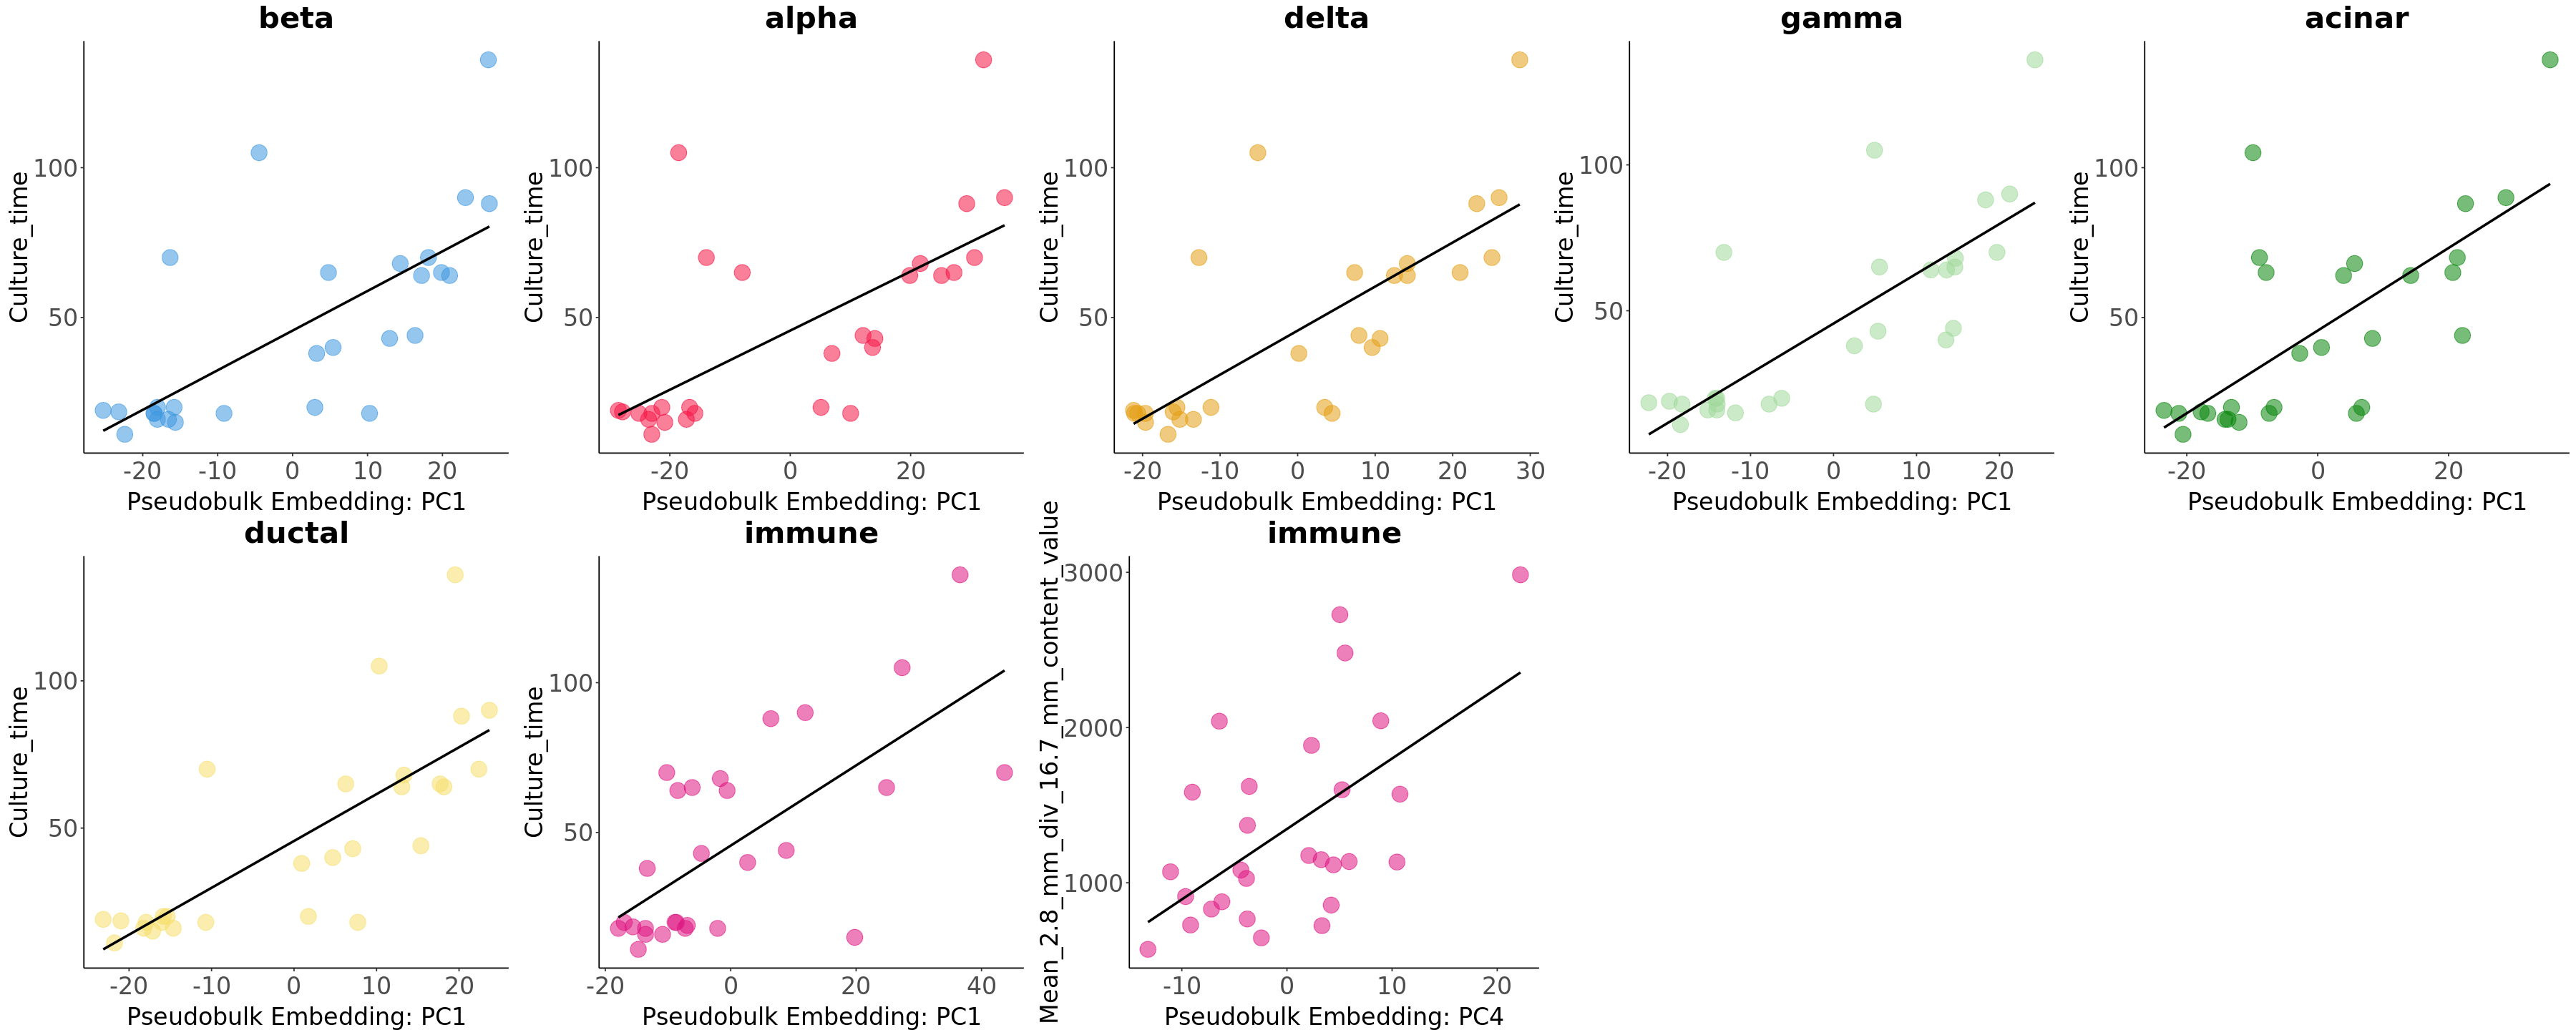

In [222]:
# Sig covars -- RNA
overall_dir <- rna_dir
embeds_dir <- file.path(rna_dir, 'embeds')
assay <- 'RNA'
n_top_pcs <- 5

sig_results_fp <- file.path(overall_dir, sprintf('all_celltypes_%s_sig_assoc_covar_results_top%sPCs.txt', assay, n_top_pcs))
print(sig_results_fp)
print(sig_plots_wrapper2(sig_results_fp, embeds_dir, 'RNA', colors))

[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/covar_investigation/ATAC_pseudobulk/all_celltypes_ATAC_sig_assoc_covar_results_top5PCs.txt"


Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”


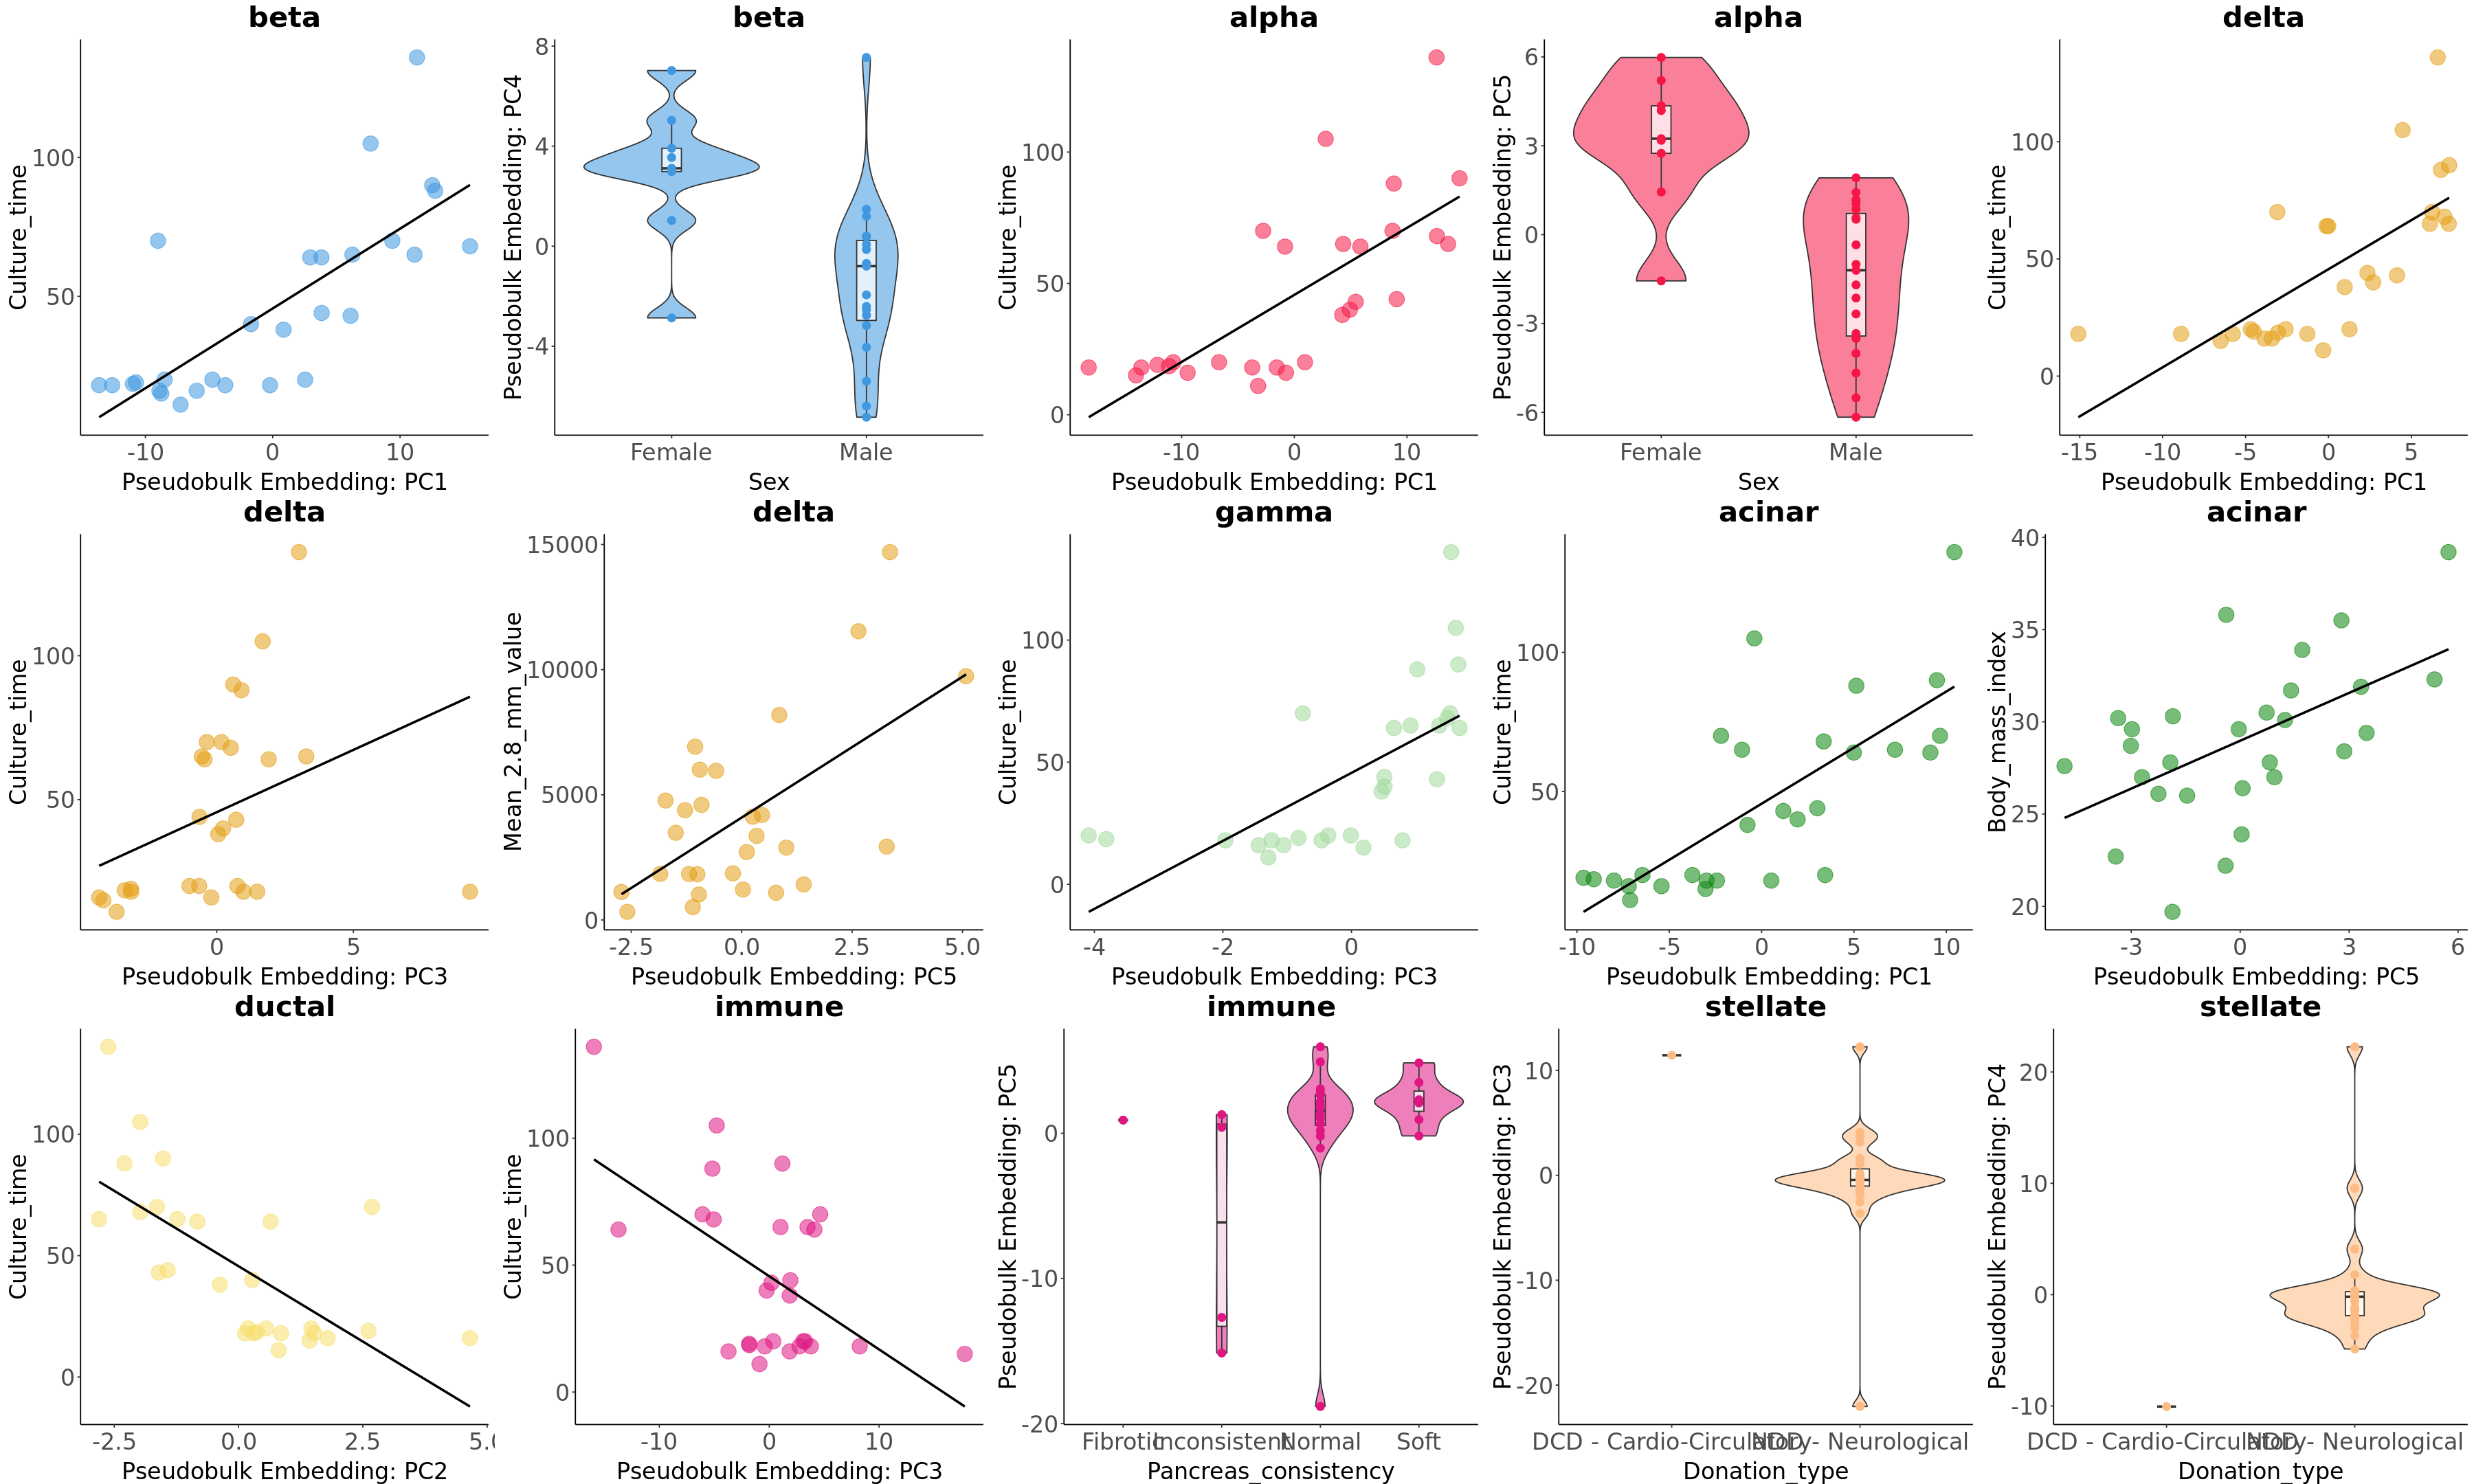

In [223]:
# Sig covars -- ATAC
overall_dir <- atac_dir
embeds_dir <- file.path(atac_dir, 'embeds')
assay <- 'ATAC'
n_top_pcs <- 5

sig_results_fp <- file.path(overall_dir, sprintf('all_celltypes_%s_sig_assoc_covar_results_top%sPCs.txt', assay, n_top_pcs))
print(sig_results_fp)
print(sig_plots_wrapper2(sig_results_fp, embeds_dir, 'ATAC', colors))